# Setup

## Import packages

In [1]:
########################################################################################################################
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
import scipy.io
import h5py
import re  # for regex

from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError

# from igraph import Graph as ig_Graph
# from igraph import plot as ig_plot

import networkx as nx

from scipy.spatial.distance import cdist
from scipy.stats import zscore, pearsonr,spearmanr, kendalltau
from scipy.optimize import curve_fit
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy
from scipy.ndimage import gaussian_filter

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import pairwise_distances
import sklearn.metrics as metrics

from random import choice as random_choice
from itertools import combinations
from numpy import array, unravel_index, argmin, mean

from copy import deepcopy
from functools import reduce
import itertools
from datetime import datetime
from time import time
from tqdm import tqdm

import random
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib
from matplotlib.colors import ListedColormap, BoundaryNorm

# import neuroglancer
# from webbrowser import open as wb_open

import sys
sys.path.append('/Users/kperks/Documents/ell-connectome/efish_em/efish_em')

# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest, import_settings, get_cell_filepaths
import AnalysisCode as efish


def recursively_load(df_dict,group, parent_key=''):
    """
    Recursively load datasets from an HDF5 group into a dictionary of DataFrames.
    Nested keys are flattened as parent_child_dataset.
    """
    for key in group.keys():
        item = group[key]
        new_key = f"{parent_key}_{key}" if parent_key else key  # flatten nested keys
        if isinstance(item, h5py.Dataset):
            data = item[()]
            if data.ndim == 1:
                df = pd.DataFrame(data, columns=[new_key])
            else:
                df = pd.DataFrame(data)
            df_dict[new_key] = df
        elif isinstance(item, h5py.Group):
            # recurse into nested group
            recursively_load(df_dict,item, new_key)

    return df_dict



In [2]:
def view_mat_file(data_mat_path):

    # Open the file
    with h5py.File(data_mat_path, 'r') as f:
        # List all top-level keys
        print("Top-level keys:", list(f.keys()))
        
        # Example: inspect one dataset
        for key in f.keys():
            item = f[key]
            print(f"\nKey: {key}")
            print(f"Type: {type(item)}")
            if isinstance(item, h5py.Dataset):
                print(f"Shape: {item.shape}, dtype: {item.dtype}")
                print(f"Sample data:\n{item[()]}")
            elif isinstance(item, h5py.Group):
                print("Contains a group with sub-keys:", list(item.keys()))


## Datapath settings

If you save a copy of settings_dict.json (found in the "under construction" directory of eCREST repo) locally somewhere outside the repo (like in your save_dir), then you can use the following code cell to import. This avoids needing to re-type the save_dir and db_path each time you "git pull" updates from the repo to this notebook.

In [3]:
dirpath = Path('/Users/kperks/Documents/sawtell_lab/EM_data/reconstructions_published')

vx_sizes = [16,16,30]

## Plotting style settings

In [4]:
filepath = Path('/Users/kperks/Documents/ell-connectome/efish_em')
filename = 'efish_em.mplstyle'
plt.style.use(filepath/filename)

In [5]:
cell_colors = efish.color_palette('cell')
structure_colors = efish.color_palette('structure')

## Molecular layer fit

In [6]:
neuroglancer_path = Path(dirpath.parent / 'data_processed_published/layer-molecular_annotation.json') #Path(dirpath).parent.parent / 'blender/soma_locations/layer-molecular_annotation.json'

with open(Path(neuroglancer_path), 'r') as myfile: # 'p' is the dirpath and 'f' is the filename from the created 'd' dictionary
    neuroglancer_data = json.load(myfile)

set([item['name'] for item in neuroglancer_data['layers'] if item['type']=='annotation'])

nl_ = 'molecular'
neuroglancer_layer = next((item for item in neuroglancer_data['layers'] if item["name"] == nl_), None)
voxel_sizes = [16,16,30]

vertices = [[p['point'][i]*voxel_sizes[i] for i in range(3)] for p in neuroglancer_layer['annotations']] #[p['point'] for p in neuroglancer_layer['annotations']]#

x_pts = [p[0] for p in vertices]
y_pts = [p[1] for p in vertices]
z_pts = [p[2] for p in vertices]

# Perform curve fitting
popt, pcov = curve_fit(efish.func_planar_curve, (x_pts, z_pts), y_pts)

# Print optimized parameters
print(popt)


[ 2.71956920e+05 -5.43115077e-02 -1.87026179e-01 -3.46153667e-07
  2.31048373e-06  9.59242290e-13 -1.51595014e-11  6.68290149e-07]


## Load reconstruction files

In [7]:
nodefiles = efish.get_cell_filepaths(dirpath)

# cell types for all files in directory

From file (see CellTyping.ipynb for how the dataframe was created)

In [8]:
df_type = pd.read_csv(dirpath.parent / 'data_processed_published/df_type_auto_typed.csv')

In [9]:
df_type[df_type['cell_type'].isin(['lf','lg'])]['id'].nunique()

88

In [10]:
df_type[df_type['cell_type'].isin(['lf'])]['id'].nunique()

46

In [11]:
df_type[df_type['cell_type'].isin(['lg'])]['id'].nunique()

42

In [12]:
df_type[df_type['cell_type'].isin(['mg1','mg2'])]['id'].nunique()

136

In [13]:
df_type[df_type['cell_type'].isin(['mg1'])]['id'].nunique()

67

In [14]:
df_type[df_type['cell_type'].isin(['mg2'])]['id'].nunique()

69

# Spine Counts


## spine density estimates

In [138]:
directory_path_mark = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/CREST_reconstructions/Spine_Density_Annotation/from_mark')

In [139]:
cell_filepaths_mark = get_cell_filepaths(directory_path_mark) # gets filepaths for all cells in a directory"
cell_filepaths_mg_network = get_cell_filepaths(Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/CREST_reconstructions/mg-network')) # gets filepaths for all cells in a directory"

In [140]:
cellids = list(cell_filepaths_mark.keys())

In [145]:
anno_loc = 'spineD loc'
anno_pts = 'spineD pts'
vx_sizes = [16, 16, 30]
'''assumes that the annotation is a point annotation stored in the list as ([x,y,z,segment_id],'annotatePoint')
                previous ot Jan 25 2024, it was just [x,y,z,segment_id]'''

data = []

for id_ in cellids: #[c for c in cellids if df_type[df_type['id'].isin([int(c)])]['cell_type'].values[0] in ['mg1','mg2']]:# ['lg','lf']]: #
    # id_ = cellids[0]
    
    # open cell from mg_network for cell type because got deleted from some of Marks files?
    cell = ecrest(settings_dict,filepath = cell_filepaths_mg_network[id_],launch_viewer=False)
    ctype = cell.get_ctype("manual")
    
    # open cell from mark's folder to get spine annotation data
    cell = ecrest(settings_dict,filepath = cell_filepaths_mark[id_],launch_viewer=False)
        
    for loc_ in cell.cell_data['end_points'][anno_loc]:
        x,y,z = [p for p in loc_[0]]     
        y = -(y/16 - 16210)
        x = x/16
        z = z/30
    
        d = [np.linalg.norm(np.array(pt_[0]) - np.array(loc_[0])) for pt_ in cell.cell_data['end_points'][anno_pts] if (np.linalg.norm(np.array(pt_[0]) - np.array(loc_[0])))<5100]
        
        data.append({'id': id_, 'cell_type': ctype[0], 'x': x, 'y': y, 'z': z, 'n': len(d)})#, ignore_index=True)

df = pd.DataFrame(data)

In [148]:
# Define depth bins and labels
bins = [1000, 3000, 5000, 7000, 9000, 12000,14000]
labels = ['d0', 'd1', 'd2', 'd3', 'd4','d5']

# Create a new column for the depth bin based on 'y'
df['depth_bin'] = pd.cut(df['y'], bins=bins, labels=labels, right=False)

# Calculate the mean 'n' for each depth bin
mean_n_per_bin = df.groupby(['depth_bin','cell_type'], observed=False)['n'].mean()

In [151]:
df.groupby(['depth_bin','cell_type'])['n'].mean()

depth_bin  cell_type
d0         l             38.647059
           m             53.000000
           s             20.000000
d1         l             55.360000
           m             95.647059
           s             20.500000
d2         l             64.944444
           m            113.352941
           s             18.500000
d3         l             74.555556
           m            113.388889
           s             16.000000
d4         l             63.800000
           m             88.187500
           s             15.000000
d5         l             70.000000
           m             50.958333
           s                   NaN
Name: n, dtype: float64

In [152]:
density_mg = [53.000000,95.647059,113.352941,113.388889,88.187500,50.958333]/10 #spines per annotation sphere divided by diameter annotation sphere
density_sg = [20,20,20,20,20,20]/10
density_out = [38.647059,55.360000,64.944444,74.555556,63.800000,70.000000]/10

(53.0, 95.647059, 113.352941, 113.388889, 88.1875, 50.958333)

## total branch length estimates Large Examples

In [103]:
jsondir = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/CREST_reconstructions/Spine_Density_Annotation/dend_length')
flist = ['299496636_mg1.json','214581797_mg2.json','301787806_lg.json','393325331_lf.json'] #

df_summary = pd.DataFrame(columns=['label','length','cell_type'])

for fname in flist:
    row_dict = {}
    with open(jsondir / fname, 'r') as myfile: # 'p' is the dirpath and 'f' is the filename from the created 'd' dictionary
        json_data = json.load(myfile)


    data = {}
    dlist = ['d0','d1','d2','d3','d4','d5','d6']
    llist = [2000,2000,2000,2000,2000,2000,2000]
    for i,d in enumerate(dlist[:-1]):
        d1 = len(next((item for item in json_data['layers'] if item["name"] == dlist[i]), None)['annotations'])
        d2 = len(next((item for item in json_data['layers'] if item["name"] == dlist[i+1]), None)['annotations'])
        # print(d1,d2)
        row_dict={
            'label' : [d],
            'length' : [np.mean([d1,d2]) * llist[i] * 16 /1000], # total length in bin = number branches times llist[i] voxels long, 16nm per voxel, 1micron per 1000 nm
            'cell_type' : [fname.split('_')[1].split('.')[0][0]],
            'id' : [fname.split('_')[0]]
        }

        df_summary = pd.concat([df_summary,pd.DataFrame.from_dict(row_dict,orient = 'columns')])
    # df_summary = pd.concat([df_summary,pd.DataFrame.from_dict(data,orient='index').reset_index(names = 'label').rename(columns={0:'length'})],
    #          ignore_index=True)

## calculate spine count per bin and sum for total

In [ ]:
## merge dataframes
df_summary = pd.merge(df, df_summary, on=['label','cell_type'])

In [119]:
for i,r in df_summary.iterrows():
    df_summary.loc[i,'total']=(r['n']/10)*r['length']

In [120]:
df_summary

,label,cell_type,n,length,total
0,d0,l,38.647059,200.0,772.941176
1,d0,m,53.000000,144.0,763.200000
2,d1,l,55.360000,248.0,1372.928000
3,d1,m,95.647059,224.0,2142.494118
4,d2,l,64.944444,232.0,1506.711111
5,d2,m,113.352941,368.0,4171.388235
6,d3,l,74.555556,184.0,1371.822222
7,d3,m,113.388889,456.0,5170.533333
8,d4,l,63.800000,136.0,867.680000
9,d4,m,88.187500,456.0,4021.350000


In [121]:
df_summary.groupby(['cell_type'])['total'].sum()

cell_type
l     6452.08251
m    18429.59902
Name: total, dtype: float64

## Apical Branch Length: subvolume

In [4]:
folder_path = Path("/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/volume_subsample_sg-mg-out_ratio")
df_segments = pd.read_csv(folder_path / 'df_segments_assigned.csv')

In [6]:
df_segments[df_segments['cell_type'].isin(['lg','lf'])]['cell_id'].nunique()

8

In [7]:
df_segments[df_segments['cell_type'].isin(['mg1','mg2'])]['cell_id'].nunique()

15

In [8]:
df_segments[df_segments['cell_type'].isin(['sg1','sg2'])]['cell_id'].nunique()

95

In [9]:
def create_bins(boundaries):
    bins = []
    for i in range(len(boundaries) - 1):
        bins.append((boundaries[i], boundaries[i + 1]))
    return bins
    

In [1681]:
'''
In terminal, prompt:
igneous view subvolume_apical_revision --port 8001

processing previous to view was:
igneous mesh forge subvolume_apical_revision --queue ./queue 
igneous execute -x ./queue
igneous mesh merge subvolume_apical_revision --queue ./queue
igneous execute -x ./queue

igneous skeleton forge subvolume_apical_revision --mip 0 --scale 25 --const 5 --soma-scale 3 --soma-detect 3000 --soma-accept 4500 --queue ./queue
igneous execute -x ./queue
igneous skeleton merge subvolume_apical_revision --queue ./queue 
igneous execute -x ./queue

original export of mesh was at mip4 (128,128,120)
with bounding box of 
[[ 9843,  1940,     0],
 [22520, 20235,  3535]]
'''

vol = CloudVolume('precomputed://http://localhost:8001',progress=False)

NameError: name 'CloudVolume' is not defined

In [13]:
# HOW GET NUMBER OF SEGMENTS IN PRECOMPUTED TO LOOP THROUGH THEM?

In [14]:
segIDs_all = vol.unique(bbox=vol.bounds) - set([0]) # get all segment IDs in volume and remove segment ID 0, which is background

In [15]:
seglist = list(segIDs_all)

In [ ]:
df_result= pd.DataFrame()

# seglist = [386392158,213590737]# MG 
# seglist = list(segIDs_all)
# seglist = [128879866,214627855,128849661] # mature SG
# seglist = [4,2,6]

mol_bounds = [1000, 3000, 5000, 7000, 9000, 12000,14000]
bins = create_bins(mol_bounds)


for seg in seglist:
    skel = vol.skeleton.get(seg)
    
    swc = skel.to_swc()
    
    df = npskel.skeleton_swc_to_df(swc)
    
    # change positions to 16nm segmentation scale(because that is the resolution in which y positions are marked)
    df['y'] = -(df['y']/16 - (16210)) # offset y position like do for spine density analysis
    df['x'] = df['x']/16
    df['z'] = df['z']/30
    vox_to_nm = 16 # to transform distance back into nm later
    
    d_total = []
    sp_total = []
    for i,b in enumerate(bins):
        mask = (df['y']>b[0]) & (df['y']<b[1])
        G = npskel.skeleton_df_to_nx(df[mask], with_attributes=True, directed=True, with_distances=True, virtual_roots=True)
        distance=nx.get_edge_attributes(G,'distance')
        d_total.append(sum(filter(lambda x: x != float('inf'), np.asarray(list(distance.values()))))*vox_to_nm/1000)
        # sp_total.append(d_total[i]*spd[i])

    df_ = pd.DataFrame({
        'depth' : bins,
        'labels' : ['d0', 'd1', 'd2', 'd3', 'd4','d5'],
        'dx_total' : d_total
        # 'sp_total' : sp_total
        # 'seg' : seg        
    })
    df_['seg']=seg
    df_['ctype'] = df_type[df_type['id'].isin([seg])]['cell_type'].values[0]
    df_result = pd.concat([df_result,df_],ignore_index=True)

In [20]:
df_result.loc[df_result['ctype'].isin(['sg1','sg2']),'class'] = 'sg'
df_result.loc[df_result['ctype'].isin(['mg1','mg2']),'class'] = 'mg'
df_result.loc[df_result['ctype'].isin(['lg','lf']),'class'] = 'output'

In [ ]:
# Function to get density for each row
def get_density(row):
    return density_lookup[row['class']][row['labels']]


density_sg = np.asarray([20,20,20,20,20,20])/10
density_mg = np.asarray([53.000000,95.647059,113.352941,113.388889,88.187500,50.958333])/10
density_out = np.asarray([38.647059,55.360000,64.944444,74.555556,63.800000,70.000000])/10

# Map depth labels to density indices
depth_order = ['d0','d1','d2','d3','d4','d5']#[
#     (1000, 3000),
#     (3000, 5000),
#     (5000, 7000),
#     (7000, 9000),
#     (9000, 12000),
#     (12000, 14000)
# ]


# Create lookup dictionary for each class
density_lookup = {
    'sg': dict(zip(depth_order, density_sg)),
    'mg': dict(zip(depth_order, density_mg)),
    'output': dict(zip(depth_order, density_out))
}


# Apply and compute sp_total
df_result['sp_density'] = df_result.apply(get_density, axis=1)
df_result['sp_total'] = df_result['dx_total'] * df_result['sp_density']

In [30]:
df_result[['class','sp_total']].groupby('class').sum()#.div()

,sp_total
class,
mg,115068.070223
output,29856.335819
sg,30481.183821


In [33]:
[s[0]/c for s,c in zip(df_result[['class','sp_total']].groupby('class').sum().values,[15,8,95])]

[7671.204681521606, 3732.0419773932354, 320.8545665324964]

In [28]:
df_result[['class','sp_total']].groupby('class').sum().div(df_result[['class','sp_total']].groupby('class').sum().sum())

,sp_total
class,
mg,0.656011
output,0.170213
sg,0.173775


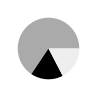

In [37]:
# total spines per cell type
df_pie = pd.DataFrame.from_dict({'class':['MG','output','SG'],
                                 'spines':[115068,29856,30481]},orient='columns')

class_colors = {
    'output':'#000000',
    'MG':'#aaaaaa',
    'SG':'#eeeeee'
}

plt.figure(figsize=(1,1))
ax = plt.gca()
plt.pie(df_pie['spines'], colors=[class_colors[key] for key in df_pie['class']], 
                      wedgeprops=dict(edgecolor='none'),
                      startangle=0)
ax.set_aspect('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


plt.savefig('/Users/kperks/Downloads/spine_count_total_pie_all.svg', format='svg', transparent=True)

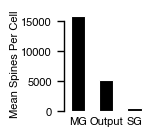

In [1733]:
# average spines per cell per type
df_pie = pd.DataFrame.from_dict({'class':['MG','Output','SG'],
                                 'spines':[15811,5163,482]},orient='columns') # average spines per cell
class_colors = {
    'output':'#000000',
    'MG':'#aaaaaa',
    'SG':'#eeeeee'
}

plt.figure(figsize=(1.1,1.25))
ax = plt.gca()
# plt.pie(df_pie['spines'], colors=[class_colors[key] for key in df_pie['class']], 
#                       wedgeprops=dict(edgecolor='none'),
#                       startangle=0)
# ax.set_aspect('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
sns.barplot(df_pie,x = 'class',y='spines',color='black',width=0.5)
ax.set_yticks([0,5000,10000,15000])
ax.set_ylim(0,16000)
ax.tick_params(axis='x', which='major', length=0)
ax.set_xlabel('')
ax.set_ylabel('Mean Spines Per Cell')
sns.despine(bottom=True,trim=True)

plt.savefig('/Users/kperks/Downloads/spine_count_total_bar.svg', format='svg', transparent=True)

In [42]:
[d *16/1000 for d in [1000, 3000, 5000, 7000, 9000, 12000,14000]]

[16.0, 48.0, 80.0, 112.0, 144.0, 192.0, 224.0]

In [41]:
np.asarray(mol_bounds) * 16/1000

array([ 16.,  48.,  80., 112., 144., 192., 224.])

/var/folders/4n/x3rls3t16fn723p1tbd7w7fr0000gn/T/ipykernel_24013/3476063936.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['16-48','48-80','80-112','112-144','144-192','192-224'])


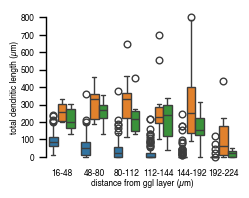

In [45]:
fig, ax = plt.subplots(figsize=(2.5, 2))
sns.boxplot(data = df_result,x = 'labels', y = 'dx_total',hue='class',legend=False)
ax.set_ylabel('total dendritic length (µm)') # this needs to match diff between ylims
ax.set_xlabel('distance from ggl layer (µm)')

ax.set_xticklabels(['16-48','48-80','80-112','112-144','144-192','192-224'])
ax.tick_params(axis='x', which='major', length=0)
sns.despine(bottom=True,trim=True)

plt.savefig(f'/Users/kperks/Downloads/dendritic_length.svg')

/var/folders/4n/x3rls3t16fn723p1tbd7w7fr0000gn/T/ipykernel_24013/3671181971.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['16-48','48-80','80-112','112-144','144-192','192-224'])


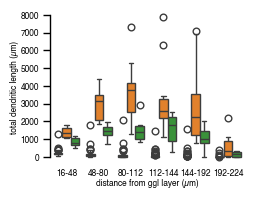

In [51]:
fig, ax = plt.subplots(figsize=(2.5, 2))
sns.boxplot(data = df_result,x = 'labels', y = 'sp_total',hue='class',legend=False)
ax.set_ylabel('total spine count') # this needs to match diff between ylims
ax.set_xlabel('distance from ggl layer (µm)')

ax.set_xticklabels(['16-48','48-80','80-112','112-144','144-192','192-224'])
ax.tick_params(axis='x', which='major', length=0)
sns.despine(bottom=True,trim=True)

plt.savefig(f'/Users/kperks/Downloads/spine_count.svg')

# Granule Cell Axons

## Synapses dataframe

In [905]:
df_syn = pd.read_csv(dirpath.parent / 'data_processed_published/df_postsyn.csv')

for v in ['x','y','z']:
    df_syn[v] = df_syn[v]/1000  

## add cell type to df_syn

In [906]:
for i,r in df_syn.iterrows():
    try:
        df_syn.loc[i,'pre_type'] =df_type[df_type['id'].isin([r['pre']])].cell_type.values[0]
        df_syn.loc[i,'post_type']=df_type[df_type['id'].isin([r['post']])].cell_type.values[0]
    except:
        print(r['pre'],r['post'])
        continue

## Completeness of synapses



In [907]:
syn = 'post-synaptic'
source = 'pre'

check_types = ['pf']

df_progress = efish.check_annot_reconstruction_completeness(df_syn, nodefiles, df_type, syn, source, check_types)

In [908]:
df_progress

,id,cell_type,n_syn,done,todo,completed
0,283546452,pf,60,60,0,1.0
1,368151599,pf,50,50,0,1.0
2,369254559,pf,55,55,0,1.0
3,369312360,pf,38,38,0,1.0
4,283547027,pf,21,21,0,1.0
...,...,...,...,...,...,...
60,282249246,pf,3,3,0,1.0
61,282249203,pf,2,2,0,1.0
62,283409751,pf,1,1,0,1.0
63,283409598,pf,1,1,0,1.0


In [909]:
mask = df_progress['completed']<0.95
pre_incomplete = np.asarray([int(c) for c in df_progress[mask]['id'].unique()])

## filter df_syn

In [910]:
df_syn = df_syn[~df_syn['pre'].isin(pre_incomplete) & df_syn['pre_type'].isin(['pf'])]

## df_syn --> df_edges

In [911]:
df_edges=df_syn[['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')

## Connection Patterns

### pie

In [912]:
mask = df_syn['post_type'].isin(['lf','lg','mg1','mg2','sg1','sg2'])#,'smpl','mli'])
df_pie = df_syn[mask].groupby('post_type')['post'].count().reset_index()
df_pie['post_frac'] = (df_pie["post"] / df_pie["post"].sum()) 

# Define custom order
order = ['lg','mg1','sg1','lf','mg2','sg2']
# Set 'post_type' as a categorical column with the desired order
df_pie['post_type'] = pd.Categorical(df_pie['post_type'], categories=order, ordered=True)

# Sort by the categorical column
df_pie = df_pie.sort_values('post_type')
df_pie

,post_type,post,post_frac
1,lg,48,0.097959
2,mg1,137,0.279592
4,sg1,48,0.097959
0,lf,63,0.128571
3,mg2,169,0.344898
5,sg2,25,0.051020


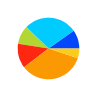

In [96]:
plt.figure(figsize=(1,1))
ax = plt.gca()
plt.pie(df_pie['post'], colors=[cell_colors[key] for key in df_pie['post_type']], 
                      wedgeprops=dict(edgecolor='none'),
                      startangle=0)
ax.set_aspect('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


plt.savefig('/Users/kperks/Downloads/gca_postsyn_pie_all.svg', format='svg', transparent=True)

### Stacked Bar Histogram

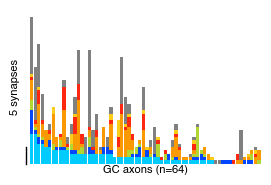

In [167]:
cell_colors['mli']='gray'
mask = (df_edges['post_type'].isin(['sg1','sg2','mg1','mg2','lg','lf','mli'])) 
df_map = df_edges[mask].groupby(
    ['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
    index='pre', columns='post_type', values='weight').fillna(0).reset_index()
df_map = df_map.fillna(0)
df_map = df_map.set_index('pre')

target_order = ['mg1','lg','sg1','mg2','lf','sg2','mli']#['lg','mg1','sg1','lf','mg2','sg2']#
df_map = df_map.loc[:,[t for t in target_order if t in df_map.columns.values]]

OFF_map = df_map[df_map['mg1']>0].sort_values(['mg1'],ascending=False)
ON_map = df_map[~df_map.index.isin(OFF_map.index)].sort_values(['mg2'],ascending=True)
sorted_full = df_map.reindex(OFF_map.index.tolist() + ON_map.index.tolist())

## Figure
ymax = 5 #for scale bar
fig, ax = plt.subplots(figsize=(3, 2))#(figsize=(4.5, 2.25))
sorted_full.loc[:,target_order].plot.bar(stacked=True,color = cell_colors,ax=ax, width=0.9,legend=False,edgecolor='none',linewidth=0)
ax.set_xticks([])
ax.set_yticks([0,ymax])
ax.set_yticklabels([])
ax.tick_params(axis='both', which='major', length=0)
sns.despine(bottom=True,trim=True,offset=2)
ax.set_ylabel(f'{ymax} synapses') # this needs to match diff between ylims
ax.set_xlabel(f'GC axons (n={len(sorted_full)})')
plt.savefig('/Users/kperks/Downloads/gca_postsyn_stacked_bar_all.svg', format='svg', bbox_inches='tight')


In [913]:
mask = df_edges['post_type'].isin(['mg1','mg2','lf','lg','sg1','sg2','mli'])
df_edges[mask]['weight'].sum()

674

In [915]:
mask = df_edges['post_type'].isin(['mg1','mg2','lf','lg','sg1','sg2','mli'])
df_edges[mask]['post'].nunique()

310

In [914]:
mask = df_edges['post_type'].isin(['mg1','mg2','lf','lg','sg1','sg2','mli'])
df_edges[~mask]['weight'].sum()

323

# Sensory Input 

## Synapses dataframe

In [37]:
df_syn = pd.read_csv(dirpath.parent / 'data_processed_published/df_presyn.csv')

'''because this is the presynaptic annotation dataset, the pre and post convension is flipped and needs to be corrected'''
df_syn = df_syn.rename(columns={'pre':'post','post':'pre','pre_type':'post_type','post_type':'pre_type'})


y_adj_col = []
for i,r in df_syn.iterrows():
    yoffset = efish.func_planar_curve((r['x'], r['z']), *popt)
    y_adj = (r['y'] - yoffset)
    y_adj_col.append(y_adj)

df_syn.loc[:,'y_adj']=y_adj_col

for v in ['x','y','z','y_adj']:
    df_syn[v] = df_syn[v]/1000
df_syn['y_adj'] = df_syn['y_adj']*-1    

## add cell type to df_syn

In [38]:
no_pre = []
no_post = []
for i,r in df_syn.iterrows():
    try:
        df_syn.loc[i,'pre_type'] =df_type[df_type['id'].isin([int(r['pre'])])].cell_type.values[0]
    except:
        no_pre.append(r['pre'])
        continue
    try:
        df_syn.loc[i,'post_type']=df_type[df_type['id'].isin([int(r['post'])])].cell_type.values[0]
    except:
        no_post.append(r['post'])
        continue

print(f'{no_post} {no_pre}')

[] []


## Completeness of synapses



In [39]:
syn = 'pre-synaptic'
source = 'post'

check_types = ['lg','lf','mg1','mg2','sg1','sg2','grc','smpl']#set(df_syn['pre_type'].unique()) | set(df_syn['post_type'].unique())

df_progress = efish.check_annot_reconstruction_completeness(df_syn, nodefiles, df_type, syn, source, check_types)

In [41]:
mask = df_progress['completed']<0.95
post_incomplete = np.asarray([int(c) for c in df_progress[mask]['id'].unique()])

## filter df_syn

### include only classic mg for main analysis

In [42]:
mg2_post_classic = [[386426114, 214581797, 213605530, 126649726, 299404889]]
mg2_post_spectrum = [385434515,215492896,387850816,216129202,300226567,386392158]  #toggle with sg: 386392158,221746236,
df_syn = df_syn[~df_syn['post'].isin(mg2_post_spectrum)]

mg1_post_classic = [[386224676, 299405462, 386612701, 299439953, 299496636]]
mg1_post_spectrum = [299392199]  #toggle with sg
df_syn = df_syn[~df_syn['post'].isin(mg1_post_spectrum)]

### include only completed cells for main analysis

In [43]:
df_syn = df_syn[~df_syn['post'].isin(post_incomplete)]

### exclude synapses onto spines (pf and pe) and any mli 


In [44]:
df_syn = df_syn[~df_syn['pre_type'].isin(['pe','pf','mli'])]

## df_syn --> df_edges

In [45]:
df_edges=df_syn[['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')

In [1184]:
mask_post = df_edges['post'].isin([482680782]) #[393325331 ON ,301787806 OFF, 299496636 MG-, 214581797 MG+]
#[389891998 SG+, 387554847 SG-, 482680782 Gr+, 220352606 SP-]
mask_pre = df_edges['pre_type'].isin(['aff']) #'aff','smpl','sg1','grc','sg2'
n_sensory_syn = df_edges[mask_post & mask_pre]['weight'].sum()

mask_pre = ~df_edges['pre_type'].isin(['aff','smpl','sg1','grc','sg2','mg1','mg2']) #['mg1','mg2']
n_uncat = df_edges[mask_post & mask_pre]['weight'].sum()

n_total = df_edges[mask_post]['weight'].sum()

print(f'{n_sensory_syn} sensory')
print(f'{n_total} total synapses annotated')
print(f'{(n_uncat)/n_total} % unclassified')

display(pd.concat([df_edges[mask_post].groupby('pre_type')['pre'].count(),df_edges[mask_post].groupby('pre_type')['weight'].sum()],axis=1))

61 sensory
216 total synapses annotated
0.6898148148148148 % unclassified


,pre,weight
pre_type,,
aff,8,61
fov,98,125
h,12,14
smpl,2,6
uk,9,10


In [1006]:
6/216

0.027777777777777776

In [1175]:
mask_post = df_edges['post_type'].isin(['lf','lg','mg1','mg2']) #[393325331 ON ,301787806 OFF, 299496636 MG-, 214581797 MG+]
mask_pre = df_edges['pre_type'].isin(['aff','grc','smpl','sg1','sg2'])
n_sensory = df_edges[mask_post & mask_pre]['weight'].sum()
n_sensory_cells = df_edges[mask_post & mask_pre]['pre'].nunique()

mask_pre = df_edges['pre_type'].isin(['mg1','mg2'])
n_mg = df_edges[mask_post & mask_pre]['weight'].sum()

mask_pre = ~df_edges['pre_type'].isin(['aff','smpl','sg1','grc','sg2','mg1','mg2'])
n_uncat = df_edges[mask_post & mask_pre]['weight'].sum()

n_total = df_edges[mask_post]['weight'].sum()

print(f'{n_sensory} sensory synapses\n{n_sensory_cells} sensory cells\n{n_total} total synapses annotated\n{n_mg/n_total} % from MG\n{n_uncat/n_total} % unclassified')

2838 sensory synapses
925 sensory cells
5003 total synapses annotated
0.10173895662602439 % from MG
0.3310013991605037 % unclassified


In [1185]:
mask_post = df_edges['post_type'].isin(['grc','smpl','sg1','sg2']) #[393325331 ON ,301787806 OFF, 299496636 MG-, 214581797 MG+]
mask_pre = df_edges['pre_type'].isin(['aff','grc','smpl','sg1','sg2'])
n_sensory = df_edges[mask_post & mask_pre]['weight'].sum()
n_sensory_cells = df_edges[mask_post & mask_pre]['pre'].nunique()

mask_pre = df_edges['pre_type'].isin(['mg1','mg2'])
n_mg = df_edges[mask_post & mask_pre]['weight'].sum()

mask_pre = ~df_edges['pre_type'].isin(['aff','smpl','sg1','grc','sg2','mg1','mg2'])
n_uncat = df_edges[mask_post & mask_pre]['weight'].sum()

n_total = df_edges[mask_post]['weight'].sum()

print(f'{n_sensory} sensory synapses\n{n_sensory_cells} sensory cells\n{n_total} total synapses annotated\n{n_mg} synapses from MG\n{n_uncat/n_total} % unclassified')

1387 sensory synapses
457 sensory cells
2366 total synapses annotated
1 synapses from MG
0.41335587489433645 % unclassified


## synapses locations in df_syn

In [1120]:
class_dict={
    'OUTPUT':['lg','lf'],
    'MG':['mg1','mg2'],
    'SG':['sg1','sg2'],
    'grc-sp':['grc','smpl']
}

for k,v in class_dict.items():
    mask = df_syn['pre_type'].isin(['sg1','sg2','grc','smpl','aff']) & df_syn['post_type'].isin(v)
    plt.figure(figsize=(0.75,1.5))
    ax=plt.gca()
    sns.histplot(data=df_syn[mask],y='y_adj',hue = 'pre_type',palette=cell_colors, element="poly", fill=False,ax=ax,legend=False,bins=20,clip_on=False)
    ax.set_ylim(-120,20)
    ax.set_yticks(np.arange(-120,25,20))
    ax.set_ylabel('depth (µm)')
    ax.set_xlabel('number synapses')
    sns.despine(trim=True,offset=2)

    if k in ['MG','SG','grc-sp']:
        # ax.set_xticklabels('')
        ax.set_yticklabels('')
        ax.set_xlabel('')
        ax.set_ylabel('')
    
    plt.savefig(f'/Users/kperks/Downloads/presyn_locations_{k}_hist-step_all-sensory.svg') 
    plt.close()

## Connection Similarity

DO NOT Z-SCORE: it will then just be correlation coefficient  
(https://stats.stackexchange.com/questions/235673/is-there-any-relationship-among-cosine-similarity-pearson-correlation-and-z-sc)
  
also don't need to normalize to percent total synapses, because cosine similarity is angle not magnitude


In [1075]:
dsource = 'post_type'
idsource = 'post'
dtarget = 'pre_type'

# Desired source and order
source_types_order = ['lg','mg1','sg1','smpl','lf','mg2','sg2','grc']

# Desired targets order
target_types_order = ['aff','grc', 'smpl','sg2', 'sg1']  

In [1076]:
mask = df_syn[dsource].isin(source_types_order) & df_syn[dtarget].isin(target_types_order)
matrix, m_labels, n_labels = efish.get_connect(df_syn[mask],['post','pre_type'])

pivot_df = pd.DataFrame(matrix,m_labels,n_labels)

pivot_df[dsource] = [df_syn[df_syn[idsource].isin([i])][dsource].values[0] for i,r in pivot_df.iterrows()]
pivot_df[dsource] = pd.Categorical(pivot_df[dsource], categories=source_types_order, ordered=True)
pivot_df.sort_values(dsource, inplace=True)

pivot_df_mat = pivot_df.drop(columns=[dsource])

cosine_sim_matrix = pairwise_distances(pivot_df_mat, metric='cosine')
cosine_sim_matrix = 1-cosine_sim_matrix
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=pivot_df_mat.index, columns=pivot_df_mat.index)

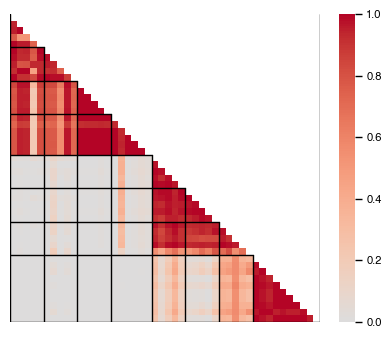

In [1084]:
# Create the heatmap
hfig = plt.figure(figsize=(5, 4))
ax = plt.gca()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(cosine_sim_df, dtype=bool))

heatmap = sns.heatmap(cosine_sim_df, mask=mask,cmap='coolwarm', annot=False, fmt='.2f', cbar=True,center=0,vmax=1) #

# Add post_type labels and lines
current_position = 0
total_position=len(pivot_df)
for dtype in source_types_order:
    n = (pivot_df[dsource] == dtype).sum()
    if n > 0:
        heatmap.axhline(current_position,0, current_position/len(pivot_df), color='black', linewidth=1)
        heatmap.axvline(current_position,0, 1-(current_position/len(pivot_df)), color='black', linewidth=1)
        current_position += n
heatmap.axhline(current_position, color='black', linewidth=1)
heatmap.axvline(current_position, color='black', linewidth=1)

# Set labels
heatmap.set_xticks(range(0,len(pivot_df)))
heatmap.set_yticks(range(0,len(pivot_df)))
heatmap.set_xticklabels(pivot_df[dsource].values, rotation=90)
heatmap.set_yticklabels(pivot_df[dsource].values, rotation=0);
sns.despine(fig=hfig,bottom=True, left=True,right=True,top=True)
ax.tick_params(axis='both', which='major', length=0)
ax.set_yticklabels('')
ax.set_xticklabels('')

plt.savefig('/Users/kperks/Downloads/sensory_input_cosine_similarity_ALL_matrix.svg',transparent=True) 

## Connection patterns

### Pie

In [46]:
for ptype in ['lf','lg','mg1','mg2']:#,'sg1','sg2','grc','smpl']:
    # Define custom order for pre_type
    order = ['aff','smpl','sg1','mg1','grc','sg2','mg2']
    mask = df_syn['post_type'].isin([ptype]) & df_syn['pre_type'].isin(order)
    df_pie = df_syn[mask].groupby('pre_type')['pre'].count().reset_index()
    df_pie['pre_frac'] = (df_pie["pre"] / df_pie["pre"].sum()) 
    # df_pie['post_type']=ptype
    
    # Set 'post_type' as a categorical column with the desired order
    df_pie['pre_type'] = pd.Categorical(df_pie['pre_type'], categories=order, ordered=True)
    
    # Sort by the categorical column
    df_pie = df_pie.sort_values('pre_type')
    df_pie.to_csv(f'/Users/kperks/Downloads/uncat_input_pie_{ptype}.csv',index=False)
    print(f'input to {ptype}')
    display(df_pie)

    hfig = plt.figure(figsize=(0.8,0.8))
    plt.pie(df_pie['pre'], colors=[cell_colors[key] for key in df_pie['pre_type']], 
                          wedgeprops=dict(edgecolor='none'),
                          startangle=0)
    ax = plt.gca()
    ax.set_aspect('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        
    plt.savefig(f'/Users/kperks/Downloads/input_pie_{ptype}_all.svg', format='svg', transparent=True)
    plt.close(hfig)

input to lf


,pre_type,pre,pre_frac
0,aff,80,0.090703
5,smpl,94,0.106576
3,sg1,511,0.579365
2,mg1,190,0.215420
1,grc,2,0.002268
4,sg2,5,0.005669


input to lg


,pre_type,pre,pre_frac
5,smpl,5,0.004174
3,sg1,1,0.000835
1,mg1,1,0.000835
0,grc,663,0.553422
4,sg2,386,0.322204
2,mg2,142,0.118531


input to mg1


,pre_type,pre,pre_frac
4,smpl,15,0.025000
2,sg1,2,0.003333
0,grc,278,0.463333
3,sg2,230,0.383333
1,mg2,75,0.125000


input to mg2


,pre_type,pre,pre_frac
0,aff,12,0.017991
6,smpl,134,0.200900
4,sg1,415,0.622189
2,mg1,100,0.149925
1,grc,3,0.004498
5,sg2,2,0.002999
3,mg2,1,0.001499


### stacked bar

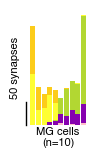

In [52]:
cls = 'MG' #'Gr+SP-' #'MG' #'OUTPUT'
ctype = ['mg1','mg2'] #['lg','lf'] #['grc','smpl']#['sg1','sg2'] #
sortby = ['sg1','sg2'] #['aff','grc'] ## sort by sg1/sg2 input (for lg/lf and mg1/mg2) or by aff/grc input (for sg1/sg2 and grc/sp)
ymax = 50 #change as needed for scale bar

target_order = ['aff','smpl','sg1','grc','sg2'] #]# 
mask = (df_edges['pre_type'].isin(target_order)) & (df_edges['post_type'].isin(ctype))#,'mli','tsd','dml'])) # 

df_map = df_edges[mask].groupby(
    ['post','post_type','pre_type']).sum(numeric_only=True).reset_index().pivot(
    index='post', columns='pre_type', values='weight').fillna(0).reset_index()
df_map = df_map.fillna(0)
df_map = df_map.set_index('post')
df_map = df_map.loc[:,[t for t in target_order if t in df_map.columns.values]]
off_map = df_map[df_map[sortby[0]]>0].sort_values([sortby[0]]) 
on_map = df_map[~df_map.index.isin(off_map.index)].sort_values([sortby[1]],ascending=False) # sort all the rest according to grc input
sorted_full = pd.concat([on_map,off_map])

fig, ax = plt.subplots(figsize=(0.75, 1.5))
sorted_full.loc[:,target_order].plot.bar(stacked=True,color = cell_colors,ax=ax, width=0.9,legend=False,edgecolor='none')
ax.set_xticks([])
ax.set_yticks([0,ymax])
ax.set_yticklabels([])
ax.tick_params(axis='both', which='major', length=0)
sns.despine(bottom=True,trim=True,offset=2)
ax.set_ylabel(f'{ymax} synapses') # this needs to match diff between ylims
ax.set_xlabel(f'{cls} cells\n(n={len(sorted_full)})')
plt.savefig(f'/Users/kperks/Downloads/input_stacked_bar_{cls}.svg', format='svg', transparent=True)

### asymmetry analysis

In [1085]:
# Avoid division by zero warnings
def safe_ratio(num, denom):
    return np.where(denom != 0, num / denom, np.nan)

In [130]:
cls = 'MG' #'OUTPUT'
ctype = ['mg1','mg2','lg','lf','sg1','sg2','grc','smpl']

target_order = ['aff','smpl','sg1','grc','sg2']
mask = (df_edges['pre_type'].isin(target_order)) & (df_edges['post_type'].isin(ctype))#,'mli','tsd','dml'])) # 

df_map = df_edges[mask].groupby(
    ['post','post_type','pre_type']).sum(numeric_only=True).reset_index().pivot(
    index='post', columns='pre_type', values='weight').fillna(0).reset_index()

df_map = df_map.fillna(0)
df_map = df_map.set_index('post')

# Compute asymmetry variables
# df_map['r_mg'] = safe_ratio(df_map['mg1'] - df_map['mg2'], df_map['mg1'] + df_map['mg2'])
df_map['r_sg'] = safe_ratio(df_map['sg1'] - df_map['sg2'], df_map['sg1'] + df_map['sg2'])
df_map['r_grsp'] = safe_ratio(df_map['smpl'] - df_map['grc'], df_map['smpl'] + df_map['grc'])
df_map['aff_syn'] = df_map['aff'] 

cols = ['r_sg', 'r_grsp', 'aff_syn']

# Prepare empty matrices/dataframes to hold r-values and p-values
cor_vals = pd.DataFrame(index=cols, columns=cols, dtype=float)
p_vals = pd.DataFrame(index=cols, columns=cols, dtype=float)
n_vals = pd.DataFrame(index=cols, columns=cols, dtype=int)

for i in range(len(cols)):
    for j in range(len(cols)):
        x = df_map[cols[i]]
        y = df_map[cols[j]]
        # Drop NaNs in either series
        valid = x.notna() & y.notna()
        xi = x[valid]
        yi = y[valid]
        if len(xi) > 1:  # need at least 2 points
            # cor, p = pearsonr(xi, yi)
            cor, p = spearmanr(xi, yi)
            # cor, p = kendalltau(xi, yi)
        else:
            cor, p = np.nan, np.nan
        cor_vals.iloc[i, j] = cor
        p_vals.iloc[i, j] = p
        n_vals.iloc[i, j] = len(xi)

print("Correlation matrix:")
print(cor_vals)
print("\nP-value matrix:")
print(p_vals)
print("\nnsamples matrix:")
print(n_vals)


Correlation matrix:
             r_sg    r_grsp   aff_syn
r_sg     1.000000  0.575703  0.520321
r_grsp   0.575703  1.000000  0.862573
aff_syn  0.520321  0.862573  1.000000

P-value matrix:
                  r_sg         r_grsp       aff_syn
r_sg     3.202552e-247   3.674467e-04  1.608082e-03
r_grsp    3.674467e-04  1.064144e-314  2.101789e-13
aff_syn   1.608082e-03   2.101789e-13  0.000000e+00

nsamples matrix:
         r_sg  r_grsp  aff_syn
r_sg     34.0    34.0     34.0
r_grsp   34.0    42.0     42.0
aff_syn  34.0    42.0     46.0


Text(0, 0.5, 'Number of Neurons')

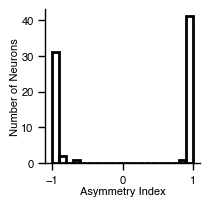

In [131]:
# histogram of asymmetry index values 

# Convert to long format
df_long = df_map[['r_sg', 'r_grsp']].melt(var_name='variable', value_name='value')

hfig,ax = plt.subplots(1,figsize=(2,2))
sns.histplot(
    data=df_long,
    x='value',
    # hue='variable',
    common_norm=False,   # keep individual scaling
    fill=False,          
    linewidth=2,
    bins=20,
    color='black'
)
ax.set_xlabel('Asymmetry Index')
ax.set_ylabel('Number of Neurons')


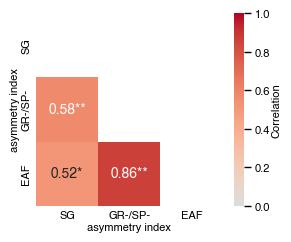

In [133]:
# Create significance stars
def sig_stars(p):
    if p < 0.001:
        return '**'
    elif p < 0.0167:
        return '*'
    else:
        return ''

annot = cor_vals.round(2).astype(str) + p_vals.applymap(sig_stars)

# Mask upper triangle
mask = np.triu(np.ones_like(cor_vals, dtype=bool))

hfig,ax = plt.subplots(1,figsize=(3,2.5))
ax_labels = ['SG','GR-/SP-','EAF']
sns.heatmap(cor_vals, mask=mask, annot=annot, fmt='', cmap="coolwarm", center=0,vmin =0,vmax=1,
            cbar_kws={'label': f'Correlation'},ax = ax);
ax.tick_params(axis='both', which='major', length=0)
ax.set_xticks(ax.get_xticks(),ax_labels)
ax.set_yticks(ax.get_yticks(),ax_labels)
ax.set_ylabel('asymmetry index')
ax.set_xlabel('asymmetry index');


### conditional input analysis

In [1112]:
post_class = 'Output' #'MG' #'SG' #'GrSP'
pre_groups = ['aff','smpl','sg1','grc','sg2']# ]#
post_groups = ['lg','lf']#['sg1','sg2']#['mg1','mg2']#['lg','lf']#['grc','smpl','sg1','sg2','lg','lf','mg1','mg2']#

ticks_list = ['EAF', 'SP-', 'SG-', 'Gr+', 'SG+']# ] #

#### shuffle result

In [1113]:
result_shuff = []
mask = df_syn['pre_type'].isin(pre_groups) & df_syn['post_type'].isin(post_groups)  # Filter out rows with post_type not in post_types_order and pre_tyep not in 

# Iterate the specified number of times
for i in range(50):
    df_syn_shuff = efish.shuffle_synapses(df_syn[mask],['pre','pre_type'])

    result_,order = efish.get_conditional_input(df_syn_shuff,pre_groups, normalize=True)
    result_ = np.asarray(result_)
    
    # Append the result as a row to the result_df
    result_shuff.append(result_)

result_shuff = np.asarray(result_shuff)
u_mat = result_shuff.mean(axis=0)
std_mat = result_shuff.std(axis=0)

#### data

In [1114]:
result_data,order = efish.get_conditional_input(df_syn[mask], pre_groups,normalize=True)

# Calculate the z-scores
z_scores = (result_data - u_mat) / std_mat
z_scores[np.isclose(std_mat, 0)] = 0  # Replace z-scores with 0 where std is 0 # Handle cases where std_2d is zero to avoid division by zero

cond_input_mat = pd.DataFrame(z_scores,columns = order, index = order)


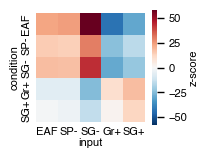

In [1115]:
# Ensure the color range is centered around 0
vmin = -max(abs(cond_input_mat.min().min()), abs(cond_input_mat.max().max()))
vmax = -vmin

plt.figure(1,figsize=(1.75,1.5))
ax = plt.gca()
sns.heatmap(cond_input_mat,
    cmap="RdBu_r",  # Diverging colormap from red to blue
    vmin=vmin,
    vmax=vmax,
    center=0,square=True,
           cbar_kws={'label': 'z-score'})
ax.tick_params(axis='both', which='major', length=0)
ax.set_xticks(ax.get_xticks(),ticks_list)
ax.set_yticks(ax.get_yticks(),ticks_list) 
ax.tick_params(axis='x', labelrotation=0)
ax.set_ylabel('condition')
ax.set_xlabel('input')

plt.savefig(f'/Users/kperks/Downloads/sensory_input_conditional_input_analysis_{post_class}.svg')

#### raw data probability

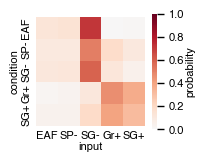

In [1116]:
result_ = np.asarray(result_data)

cond_input_mat = pd.DataFrame(result_,columns = order, index = order)

# Ensure the color range is centered around 0
vmin = 0 
vmax = 1 #max(abs(cond_input_mat.min().min()), abs(cond_input_mat.max().max()))

hfig,ax = plt.subplots(1,figsize=(1.75,1.5))
sns.heatmap(cond_input_mat,
    cmap="RdBu_r",  # Diverging colormap from red to blue
    vmin=vmin,
    vmax=vmax,
    center=0,square=True,cbar_kws={'label': 'probability'})

ax.tick_params(axis='both', which='major', length=0)
ax.set_xticks(ax.get_xticks(),ticks_list)
ax.set_yticks(ax.get_yticks(),ticks_list) 
ax.tick_params(axis='x', labelrotation=0)
ax.set_ylabel('condition')
ax.set_xlabel('input')

plt.savefig(f'/Users/kperks/Downloads/sensory_input_conditional_input_analysis_{post_class}_raw.svg')

#### an example of shuffle result

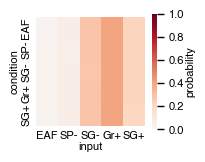

In [1117]:
mask = df_syn['pre_type'].isin(pre_groups) & df_syn['post_type'].isin(post_groups)  # Filter out rows with post_type not in post_types_order and pre_tyep not in 
df_syn_shuff = efish.shuffle_synapses(df_syn[mask],['pre','pre_type'])

result_,order = efish.get_conditional_input(df_syn_shuff,pre_groups, normalize=True)
result_ = np.asarray(result_)

cond_input_mat = pd.DataFrame(result_,columns = order, index = order)

# Ensure the color range is centered around 0
vmin = 0 
vmax = 1 #max(abs(cond_input_mat.min().min()), abs(cond_input_mat.max().max()))

hfig,ax = plt.subplots(1,figsize=(1.75,1.5))
sns.heatmap(cond_input_mat,
    cmap="RdBu_r",  # Diverging colormap from red to blue
    vmin=vmin,
    vmax=vmax,
    center=0,square=True,cbar_kws={'label': 'probability'})

ax.tick_params(axis='both', which='major', length=0)
ax.set_xticks(ax.get_xticks(),ticks_list)
ax.set_yticks(ax.get_yticks(),ticks_list) 
ax.tick_params(axis='x', labelrotation=0)
ax.set_ylabel('condition')
ax.set_xlabel('input')

plt.savefig(f'/Users/kperks/Downloads/sensory_input_conditional_input_analysis_{post_class}_randomized.svg')

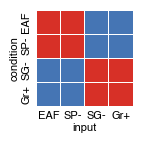

In [140]:


quantiles = np.quantile(result_shuff, [0.01, 0.5, 0.99], axis=0)
# Boolean masks
ci_diff_upper = result_data > quantiles[2]
ci_diff_lower = result_data < quantiles[0]

# Combine masks into a single numeric code
#  1 = upper (red), -1 = lower (blue), 0 = neither (gray)
combined = np.zeros_like(result_data, dtype=int)
combined[ci_diff_upper] = 1
combined[ci_diff_lower] = -1

# Make DataFrame for seaborn
CI_df = pd.DataFrame(combined, index=order, columns=order)


# --- Seaborn Heatmap ---
# Define discrete colormap (blue, gray, red)
cmap = ListedColormap(["#4575b4", "#d3d3d3", "#d73027"])
norm = BoundaryNorm([-1.5, -0.5, 0.5, 1.5], cmap.N)

plt.figure(figsize=(1.5,1.25))
ax = sns.heatmap(
    CI_df,
    cmap=cmap,
    norm=norm,
    linewidths=0.5,
    linecolor='white',
    square=True,
    cbar=False
)
ax.tick_params(axis='both', which='major', length=0)
ax.set_xticks(ax.get_xticks(),['EAF', 'SP-', 'SG-', 'Gr+'])#, 'SG+'])#
ax.set_yticks(ax.get_yticks(),['EAF', 'SP-', 'SG-', 'Gr+'])#, 'SG+'])#
ax.set_ylabel('condition')
ax.set_xlabel('input');

plt.savefig('/Users/kperks/Downloads/sensory_input_CIA_confint99_grsp.svg')

# MG and Output Connectivity

## Synapses dataframe

In [10]:
df_syn = pd.read_csv(dirpath.parent / 'data_processed_published/df_postsyn.csv')

y_adj_col = []
for i,r in df_syn.iterrows():
    yoffset = efish.func_planar_curve((r['x'], r['z']), *popt)
    y_adj = (r['y'] - yoffset)
    y_adj_col.append(y_adj)

df_syn.loc[:,'y_adj']=y_adj_col

for v in ['x','y','z','y_adj']:
    df_syn[v] = df_syn[v]/1000
df_syn['y_adj'] = df_syn['y_adj']*-1    

## add cell type to df_syn

In [11]:
for i,r in df_syn.iterrows():
    try:
        df_syn.loc[i,'pre_type'] =df_type[df_type['id'].isin([r['pre']])].cell_type.values[0]
        df_syn.loc[i,'post_type']=df_type[df_type['id'].isin([r['post']])].cell_type.values[0]
    except:
        print(r['pre'],r['post'])
        continue

## Completeness of synapses



In [12]:
syn = 'pre-synaptic'
source = 'post'

check_types = ['mg1','mg2']#set(df_syn['pre_type'].unique()) | set(df_syn['post_type'].unique())

df_progress = efish.check_annot_reconstruction_completeness(df_syn, nodefiles, df_type, syn, source, check_types)

In [13]:
mask = df_progress['completed']<0.95
pre_incomplete = np.asarray([int(c) for c in df_progress[mask]['id'].unique()])

## filter df_syn

In [14]:
df_syn = df_syn[~df_syn['pre'].isin(pre_incomplete) & df_syn['pre_type'].isin(['mg1','mg2'])]

## df_syn --> df_edges

In [15]:
df_edges=df_syn[['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')

In [1514]:
df_edges['weight'].sum()

6756

In [1515]:
mask = df_edges['post_type'].isin(['mg1','mg2','lg','lf','sg1','sg2','grc','smpl'])
df_edges[mask]['weight'].sum()

4957

In [1516]:
4957/6756

0.7337181764357608

In [1517]:
df_edges[mask]['post'].nunique()

293

In [1518]:
df_edges['post'].nunique()

1051

In [1519]:
mask = df_edges['post_type'].isin(['lf','lg'])
df_edges[mask]['weight'].sum()

3527

In [1520]:
mask = df_edges['post_type'].isin(['mg1','mg2'])
df_edges[mask]['weight'].sum()

1322

In [1521]:
df_edges.groupby(['pre'])['weight'].sum().describe()

count    103.000000
mean      65.592233
std       30.529779
min       11.000000
25%       40.500000
50%       63.000000
75%       82.500000
max      128.000000
Name: weight, dtype: float64

In [16]:
mask_post = df_edges['post'].isin([387338914]) #convergence onto: [393464000 ON ,214503199 OFF, 387338914 MG+, 299496636 MG-]

# mask_pre = df_edges['pre_type'].isin(['aff','smpl','sg1']) #'aff','smpl','sg1','grc','sg2'
# n_sensory_syn = df_edges[mask_post & mask_pre]['weight'].sum()

mask_pre = df_edges['pre_type'].isin(['mg1','mg2']) #['mg1','mg2']
n_mg_syn = df_edges[mask_post & mask_pre]['weight'].sum()
n_mg = df_edges[mask_post & mask_pre]['pre'].nunique()
# mask_pre = df_edges['pre_type'].isin(['grc']) #['mg1','mg2']
# n_grc = df_edges[mask_post & mask_pre]['weight'].sum()

mask_pre = ~df_edges['pre_type'].isin(['aff','smpl','sg1','grc','sg2','mg1','mg2']) #['mg1','mg2']
n_uncat = df_edges[mask_post & mask_pre]['weight'].sum()

n_total = df_edges[mask_post]['weight'].sum()

# print(f'{n_sensory_syn} sensory')
print(f'{n_mg_syn} syn from mg')
print(f'{n_mg} mg cells converging')
print(f'{n_total} total synapses annotated')
print(f'{n_mg/n_total} % from MG')
print(f'{(n_uncat)/n_total} % unclassified')

32 syn from mg
14 mg cells converging
32 total synapses annotated
0.4375 % from MG
0.0 % unclassified


In [17]:
mask_pre = df_edges['pre_type'].isin(['mg1','mg2']) #['mg1','mg2']
df_edges[mask_post & mask_pre]['pre'].unique()

array([474373577, 214411806, 557092670,  42632020, 126618353, 387197529,
       214550811, 128536704, 472994717,  41579854, 644005141, 300459385,
       298228381, 472282894])

## synapses locations in df_syn

### absolute

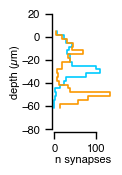

In [810]:
mask = df_syn['post_type'].isin(['mg1','mg2']) #['lg','lf'] ['mg1','mg2']

plt.figure(figsize=(0.75,1.5))
ax = plt.gca()
sns.histplot(data=df_syn[mask],y='y_adj',hue = 'post_type',palette=cell_colors, element="step", fill=False,ax=ax,legend=False,bins=20,clip_on=False)
ax.set_ylim(-80,20)
sns.despine(offset=2, trim=True)
plt.xlabel('n synapses')
plt.ylabel('depth (µm)')

plt.savefig('/Users/kperks/Downloads/mg_postsyn_locations_hist-step_OUTPUT.svg') 


### structure specificity

how many synapses do MG tend to make or get onto each substructure?

In [842]:
mask = df_syn['post_type'].isin(['lg','lf']) #['lg','lf'] ['mg1','mg2']

df_pie = df_syn[mask].groupby('structure')['post'].count().reset_index()
df_pie['post_frac'] = (df_pie["post"] / df_pie["post"].sum())

df_pie

,structure,post,post_frac
0,apical dendrite,431,0.122200
1,axon,33,0.009356
2,basal dendrite,1024,0.290332
3,multiple,342,0.096966
4,unknown,1697,0.481145


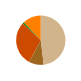

In [843]:
hfig = plt.figure(figsize=(0.8,0.8))
ax = plt.gca()
plt.pie(df_pie['post'], colors=[structure_colors[key] for key in df_pie['structure']], 
                      wedgeprops=dict(edgecolor='none'),
                      startangle=90)
ax.set_aspect('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig('/Users/kperks/Downloads/MG_postsyn_pie_Output-Structure.svg')

In [844]:
mask = df_syn['post_type'].isin(['lg','lf']) # ['mg1','mg2']) #['lg','lf']) #
df_sum = df_syn[mask][['post','structure']].value_counts().reset_index(name='weight')
df_sum[['weight','structure']].groupby('structure').describe()

weight                                                    
                 count       mean        std  min   25%   50%    75%   max
structure                                                                 
apical dendrite   66.0   6.530303   5.757189  1.0  3.00   5.0   7.75  25.0
axon              14.0   2.357143   2.060886  1.0  1.00   1.0   3.75   7.0
basal dendrite    68.0  15.058824  15.157760  1.0  4.75   9.0  21.25  75.0
multiple          27.0  12.666667  11.485777  1.0  4.50  10.0  16.00  49.0
unknown           76.0  22.328947  18.481983  1.0  9.00  18.5  30.50  70.0

## Connection patterns

### Pie

In [897]:
mask = df_syn['post_type'].isin(['lf','lg','mg1','mg2','sg1','sg2','smpl','grc','aff'])
df_pie = df_syn[mask].groupby('post_type')['post'].count().reset_index()
df_pie['post_frac'] = (df_pie["post"] / df_pie["post"].sum()) 

# Define custom order
order = ['lg','mg1','sg1','smpl','aff','lf','mg2','sg2','grc']
# Set 'post_type' as a categorical column with the desired order
df_pie['post_type'] = pd.Categorical(df_pie['post_type'], categories=order, ordered=True)

# Sort by the categorical column
df_pie = df_pie.sort_values('post_type')
df_pie

,post_type,post,post_frac
2,lg,1859,0.375025
3,mg1,627,0.126488
5,sg1,36,0.007262
7,smpl,13,0.002623
1,lf,1668,0.336494
4,mg2,695,0.140206
6,sg2,46,0.009280
0,grc,13,0.002623


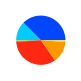

In [898]:
plt.figure(figsize=(0.8,0.8))
plt.pie(df_pie['post'], colors=[cell_colors[key] for key in df_pie['post_type']], 
                      wedgeprops=dict(edgecolor='none'),
                      startangle=0)
ax.set_aspect('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


plt.savefig('/Users/kperks/Downloads/MG_postsyn_pie_all.svg', format='svg', transparent=True)

### stacked bar

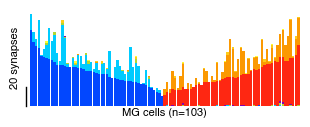

In [845]:
mask = (df_edges['post_type'].isin(['sg1','sg2','mg1','mg2','lg','lf','smpl','grc','aff']))#,'mli','tsd','dml'])) # 

df_map = df_edges[mask].groupby(
    ['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
    index='pre', columns='post_type', values='weight').fillna(0).reset_index()

df_map = df_map.fillna(0)
df_map = df_map.set_index('pre')

# target_order = ['lg','mg1','sg1','smpl','lf','mg2','sg2','grc']#['lg','mg1','sg1','lf','mg2','sg2']#
# df_map = df_map.loc[:,[t for t in target_order if t in df_map.columns.values]]
# lg_map = df_map[df_map['lg']>1].sort_values(['lg'])
# lf_map = df_map[~df_map.index.isin(lg_map.index)].sort_values(['lf'],ascending=False)
# sorted_full = pd.concat([lf_map,lg_map])

target_order = ['lg','mg1','sg1','smpl','lf','mg2','sg2','grc']#['lg','mg1','sg1','lf','mg2','sg2']#
df_map = df_map.loc[:,[t for t in target_order if t in df_map.columns.values]]
OFF_map = df_map[df_map['lg']>1].sort_values(['lg'],ascending=False)
ON_map = df_map[~df_map.index.isin(OFF_map.index)].sort_values(['lf'],ascending=True)
sorted_full = df_map.reindex(OFF_map.index.tolist() + ON_map.index.tolist())

# Plotting
fig, ax = plt.subplots(figsize=(3.5, 1.25))
sorted_full.loc[:,target_order].plot.bar(stacked=True,color = cell_colors,ax=ax, width=0.9,legend=False,edgecolor='none')
ax.set_xticks([])
ax.set_yticks([0,20])
ax.set_yticklabels([])
ax.tick_params(axis='both', which='major', length=0)
sns.despine(bottom=True,trim=True,offset=2)
ax.set_ylabel('20 synapses') # this needs to match diff between ylims
ax.set_xlabel(f'MG cells (n={len(sorted_full)})')
# ax.legend(title='Postsynaptic \n Type', bbox_to_anchor=(1.15, 1), loc='upper right')
plt.savefig('/Users/kperks/Downloads/MG_postsyn_stacked_bar_all.svg', format='svg', transparent=True)

### Adjacency Matrix

Graph with individual cells as nodes

allows to search paths through network using all connections in df_edges

Uses df_edges

In [848]:
nodes_to_graph = set(df_edges['pre'].unique())|set(df_edges['post'].unique())

G = nx.DiGraph()

# Add nodes with unique IDs and cell_type attribute
for k in nodes_to_graph:
    G.add_node(k, cell_type=df_type[df_type['id'].isin([k])]['cell_type'].values[0])
# Add more nodes as needed

# Add edges between nodes (neurons
for index, row in df_edges.iterrows():
    pre_type = row['pre']
    post_type = row['post']
    weight = row['weight']
    
    G.add_edge(pre_type, post_type, weight=weight)


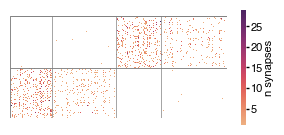

In [850]:
nlist = []
tlist = ['lg','mg1','lf','mg2']#['lg','mg1','sg1','lf','mg2','sg2']
for t in tlist:
    for i in G.nodes():
        if G.nodes[i]['cell_type']==t:
            nlist.append(i)

nm1 = len([x for x,y in G.nodes(data=True) if y['cell_type'] in ['mg1']])
nm2 = len([x for x,y in G.nodes(data=True) if y['cell_type'] in ['mg2']])
no1 = len([x for x,y in G.nodes(data=True) if y['cell_type'] in ['lg']])
no2 = len([x for x,y in G.nodes(data=True) if y['cell_type'] in ['lf']])

nt = nm1+nm2+no1+no2

A = nx.to_numpy_array(G,nodelist=nlist,nonedge=np.NaN)

dfA = pd.DataFrame(A)

ctype_col = [df_type[df_type['id'].isin([n])]['cell_type'].values[0] for n in nlist]
dfA['cell_type']=ctype_col

mask = (dfA.drop(columns=['cell_type']).sum(axis=1)>1)

dfA=dfA[mask]

hfig,ax = plt.subplots(1,figsize=(3.5,1.5))
htmp = sns.heatmap(data=dfA.drop(columns=['cell_type']),ax=ax,cmap='flare',clip_on=False,
                   xticklabels=False,yticklabels=False, square=True,
                  cbar_kws={'ticks':[5,10,15,20,25],'label':'n synapses'}) #'flare_r'

n_hlines =  [0,sum(dfA['cell_type']=='lg'),sum(dfA['cell_type']=='mg1'),
            sum(dfA['cell_type']=='lf'),sum(dfA['cell_type']=='mg2'),len(dfA)]

nacc = 0
for nh in n_hlines:
    ax.hlines([nacc],0,nt,color='gray',linewidth=0.5)
    nacc+=nh

n_vlines = [0,no1,nm1,no2,nm2,nt]#,ng,ns1,ns2,ntsd,ngd,ngs,nt]
nacc = 0
for nv in n_vlines:
    ax.vlines([nacc],0,nm1+nm2,color='gray',linewidth=0.5)
    nacc+=nv

cax = htmp.figure.axes[-1]
cax.tick_params(size=2,pad=1)

plt.savefig('/Users/kperks/Downloads/MG_postsyn_adjacency_MG-OUT.svg',transparent=True) 

### asymmetry analysis

In [182]:
# Avoid division by zero warnings
def safe_ratio(num, denom):
    return np.where(denom != 0, num / denom, np.nan)

cls = 'MG'
ctype = ['mg1','mg2']

target_order = ['mg1','mg2','lg','lf']
mask = (df_edges['pre_type'].isin(ctype)) & (df_edges['post_type'].isin(target_order))#,'mli','tsd','dml'])) # 

df_map = df_edges[mask].groupby(
    ['pre','post_type','pre_type']).sum(numeric_only=True).reset_index().pivot(
    index='pre', columns='post_type', values='weight').fillna(0).reset_index()

df_map = df_map.fillna(0)
df_map = df_map.set_index('pre')

# Compute asymmetry variables
df_map['r_mg'] = safe_ratio(df_map['mg1'] - df_map['mg2'], df_map['mg1'] + df_map['mg2'])
df_map['r_out'] = safe_ratio(df_map['lg'] - df_map['lf'], df_map['lg'] + df_map['lf'])


In [42]:
# Suppose df_map has your r1–r4 columns:
cols = ['r_mg', 'r_out',]

# Prepare empty matrices/dataframes to hold r-values and p-values
cor_vals = pd.DataFrame(index=cols, columns=cols, dtype=float)
p_vals = pd.DataFrame(index=cols, columns=cols, dtype=float)

for i in range(len(cols)):
    for j in range(len(cols)):
        x = df_map[cols[i]]
        y = df_map[cols[j]]
        # Drop NaNs in either series
        valid = x.notna() & y.notna()
        xi = x[valid]
        yi = y[valid]
        if len(xi) > 1:  # need at least 2 points
            # cor, p = pearsonr(xi, yi)
            cor, p = spearmanr(xi, yi)
            # cor, p = kendalltau(xi, yi)
        else:
            cor, p = np.nan, np.nan
        cor_vals.iloc[i, j] = cor
        p_vals.iloc[i, j] = p

print("Correlation matrix:")
print(cor_vals)
print("\nP-value matrix:")
print(p_vals)


Correlation matrix:
           r_mg     r_out
r_mg   1.000000  0.950466
r_out  0.950466  1.000000

P-value matrix:
               r_mg         r_out
r_mg   0.000000e+00  1.430518e-53
r_out  1.430518e-53  0.000000e+00


Text(0, 0.5, 'Number of Neurons')

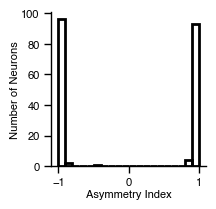

In [185]:
# Convert to long format
df_long = df_map[['r_mg', 'r_out']].melt(var_name='variable', value_name='value')

hfig,ax = plt.subplots(1,figsize=(2,2))
sns.histplot(
    data=df_long,
    x='value',
    # hue='variable',
    common_norm=False,   # keep individual scaling
    fill=False,          
    linewidth=2,
    bins=20,
    color='black'
)
ax.set_xlabel('Asymmetry Index')
ax.set_ylabel('Number of Neurons')

### conditional OUTPUT analysis

In [26]:
pre_groups = ['mg1','mg2']
post_groups = ['mg1','lg','mg2','lf']

ticks_list = ['MG-', 'LG', 'MG+', 'LF']# ] #

#### shuffle result

In [27]:
result_shuff = []

# Iterate the specified number of times
for i in range(100):
    mask = df_syn['pre_type'].isin(pre_groups) & df_syn['post_type'].isin(post_groups)  # Filter out rows with post_type not in post_types_order and pre_tyep not in 
    df_syn_shuff = efish.shuffle_synapses(df_syn[mask],['post','post_type'])

    result_,order = efish.get_conditional_output(df_syn_shuff,post_groups, normalize=True)
    result_ = np.asarray(result_)
    
    # Append the result as a row to the result_df
    result_shuff.append(result_)

result_shuff = np.asarray(result_shuff)
u_mat = result_shuff.mean(axis=0)
std_mat = result_shuff.std(axis=0)

#### data

In [28]:
result_data,order = efish.get_conditional_output(df_syn[mask], post_groups,normalize=True)

# Calculate the z-scores
z_scores = (result_data - u_mat) / std_mat
z_scores[np.isclose(std_mat, 0)] = 0  # Replace z-scores with 0 where std is 0 # Handle cases where std_2d is zero to avoid division by zero

cond_input_mat = pd.DataFrame(z_scores,columns = order, index = order)

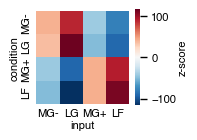

In [29]:
# Ensure the color range is centered around 0
vmin = -max(abs(cond_input_mat.min().min()), abs(cond_input_mat.max().max()))
vmax = -vmin

plt.figure(1,figsize=(1.5,1.25))
ax = plt.gca()
sns.heatmap(cond_input_mat,
    cmap="RdBu_r",  # Diverging colormap from red to blue
    vmin=vmin,
    vmax=vmax,
    center=0,square=True,
           cbar_kws={'label': 'z-score'})
ax.tick_params(axis='both', which='major', length=0)
ax.set_xticks(ax.get_xticks(),ticks_list)
ax.set_yticks(ax.get_yticks(),ticks_list) 
ax.set_ylabel('condition')
ax.set_xlabel('input')


plt.savefig('/Users/kperks/Downloads/conditional_output_analysis_mg.svg')

#### an example of shuffle result

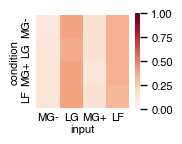

In [31]:
mask = df_syn['pre_type'].isin(pre_groups) & df_syn['post_type'].isin(post_groups)  # Filter out rows with post_type not in post_types_order and pre_tyep not in 
df_syn_shuff = efish.shuffle_synapses(df_syn[mask],['post','post_type'])

result_,order = efish.get_conditional_output(df_syn_shuff,post_groups, normalize=True)
result_ = np.asarray(result_)

cond_input_mat = pd.DataFrame(result_,columns = order, index = order)

# Ensure the color range is centered around 0
vmin = 0 
vmax = 1 #max(abs(cond_input_mat.min().min()), abs(cond_input_mat.max().max()))

hfig,ax = plt.subplots(1,figsize=(1.5,1.25))
sns.heatmap(cond_input_mat,
    cmap="RdBu_r",  # Diverging colormap from red to blue
    vmin=vmin,
    vmax=vmax,
    center=0,square=True)

ax.tick_params(axis='both', which='major', length=0)
ax.set_xticks(ax.get_xticks(),ticks_list)
ax.set_yticks(ax.get_yticks(),ticks_list) 
ax.set_ylabel('condition')
ax.set_xlabel('input')

plt.savefig('/Users/kperks/Downloads/conditional_output_analysis_mg_randomized.svg')

#### data non-zscored

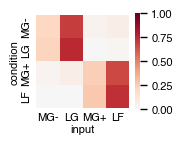

In [36]:
result_data,order = efish.get_conditional_output(df_syn[mask], post_groups,normalize=True)
result_data = np.asarray(result_data)

cond_input_mat = pd.DataFrame(result_data,columns = order, index = order)

# Ensure the color range is centered around 0
vmin = 0 
vmax = 1 #max(abs(cond_input_mat.min().min()), abs(cond_input_mat.max().max()))

hfig,ax = plt.subplots(1,figsize=(1.5,1.25))
sns.heatmap(cond_input_mat,
    cmap="RdBu_r",  # Diverging colormap from red to blue
    vmin=vmin,
    vmax=vmax,
    center=0,square=True)

ax.tick_params(axis='both', which='major', length=0)
ax.set_xticks(ax.get_xticks(),ticks_list)
ax.set_yticks(ax.get_yticks(),ticks_list) 
ax.set_ylabel('condition')
ax.set_xlabel('input')


plt.savefig('/Users/kperks/Downloads/conditional_output_analysis_mg_dataraw.svg')

## divergence and convergence

In [811]:
desired_combinations = [
    ('mg1', 'mg2'),
    ('mg1', 'lf'),
    ('mg2', 'mg1'),
    ('mg2', 'lg')
]
# filtered_df = df_edges[df_edges[['pre_type', 'post_type']].apply(tuple, axis=1).isin(desired_combinations)]


In [864]:
# list(filtered_df.groupby(['pre_type','pre']))

# Initialize an empty DataFrame to store the results
divergence_counts = pd.DataFrame(columns=['pre_type', 'post_type', 'pre', 'divergence_count'])

# Iterate over each desired combination
for pre_type, post_type in desired_combinations:
    # Filter the DataFrame for the current combination
    subset_df = df_edges[(df_edges['pre_type'] == pre_type) & (df_edges['post_type'] == post_type)]
    
    # Group by pre and count unique post cells for each pre cell
    subset_divergence_counts = subset_df.groupby(['pre_type', 'pre'])['post'].nunique().reset_index()
    subset_divergence_counts.rename(columns={'post': 'divergence_count'}, inplace=True)

    # # Group by pre and count synapse total for each pre cell
    # subset_divergence_counts = subset_df.groupby(['pre_type', 'pre'])['weight'].sum().reset_index()
    # subset_divergence_counts.rename(columns={'weight': 'divergence_count'}, inplace=True)
    
    # Add pre_type and post_type columns
    subset_divergence_counts['post_type'] = post_type
    
    # Append the subset DataFrame to the results DataFrame
    divergence_counts = pd.concat([divergence_counts, subset_divergence_counts])

# Display the resulting DataFrame
divergence_counts.head()
divergence_counts[divergence_counts['divergence_count'] != 0]
divergence_counts['divergence_count'] = divergence_counts['divergence_count'].astype(int)

/var/folders/4n/x3rls3t16fn723p1tbd7w7fr0000gn/T/ipykernel_13568/2400149234.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['MG-\nto\nON','MG+\nto\nOFF','MG-\nto\nMG+','MG+\nto\nMG-'])


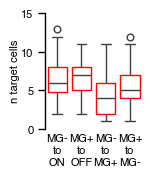

In [825]:
hfig,ax = plt.subplots(1,figsize=(1.25,1.5))
sns.boxplot(data=divergence_counts,y='divergence_count',x='post_type',legend=False,
            order=['lf','lg','mg2','mg1'],
        ax=ax,**{'boxprops':{'facecolor':'none', 'edgecolor':'red'}})#,dodge=0.8)
# sns.stripplot(ax = ax, data=divergence_counts,x = 'pre_type',y='divergence_count',s=3,dodge=True,jitter=0.2,alpha=0.4,color='black',legend=False)

# ax.set_ylabel('number of target cells')
ax.set_ylabel('n target cells')
ax.set_xlabel('')
ax.set_yticks([0,5,10,15])
ax.set_xticklabels(['MG-\nto\nON','MG+\nto\nOFF','MG-\nto\nMG+','MG+\nto\nMG-'])
ax.tick_params(axis='x', which='major', length=0)
sns.despine(bottom=True,trim=True)


plt.savefig('/Users/kperks/Downloads/MG_postsyn_divergence_count_all.svg') 

In [865]:
divergence_counts.loc[divergence_counts['post_type'].isin(['mg1','mg2']),'post_class'] = 'mg'
divergence_counts.loc[divergence_counts['post_type'].isin(['lg','lf']),'post_class'] = 'output'
divergence_counts.loc[divergence_counts['pre_type'].isin(['mg1','mg2']),'pre_class'] = 'mg'


In [866]:
divergence_counts[['post_class','divergence_count']].groupby('post_class').describe()

divergence_count                                              
                      count      mean       std  min  25%  50%  75%   max
post_class                                                               
mg                     93.0  4.892473  2.849342  1.0  2.0  5.0  6.0  12.0
output                103.0  6.572816  2.238706  2.0  5.0  6.0  8.0  13.0

/var/folders/4n/x3rls3t16fn723p1tbd7w7fr0000gn/T/ipykernel_13568/676578400.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['MG\nto\nOutput', 'MG\nto\nMG'])


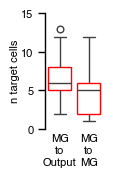

In [828]:
hfig,ax = plt.subplots(1,figsize=(0.75,1.5))
sns.boxplot(data=divergence_counts,y='divergence_count',x='post_class',legend=False,
            order=['output','mg'],
        ax=ax,**{'boxprops':{'facecolor':'none', 'edgecolor':'red'}})#,dodge=0.8)
# sns.stripplot(ax = ax, data=divergence_counts,x = 'pre_type',y='divergence_count',s=3,dodge=True,jitter=0.2,alpha=0.4,color='black',legend=False)

# ax.set_ylabel('number of target cells')
ax.set_ylabel('n target cells')
ax.set_xlabel('')
ax.set_yticks([0,5,10,15])
ax.set_xticklabels(['MG\nto\nOutput', 'MG\nto\nMG'])
ax.tick_params(axis='x', which='major', length=0)
sns.despine(bottom=True,trim=True)


plt.savefig('/Users/kperks/Downloads/MG_postsyn_divergence_count_class.svg') 

In [816]:
# list(filtered_df.groupby(['pre_type','pre']))

# Initialize an empty DataFrame to store the results
convergence_counts = pd.DataFrame(columns=['pre_type', 'post_type', 'post', 'convergence_count'])

# Iterate over each desired combination
for pre_type, post_type in desired_combinations:
    # Filter the DataFrame for the current combination
    subset_df = df_edges[(df_edges['pre_type'] == pre_type) & (df_edges['post_type'] == post_type)]
    
    # # Group by pre and count unique post cells for each pre cell
    # subset_convergence_counts = subset_df.groupby(['pre_type', 'post'])['pre'].nunique().reset_index()
    # subset_convergence_counts.rename(columns={'pre': 'convergence_count'}, inplace=True)

    # Group by pre and count synapse total for each pre cell
    subset_convergence_counts = subset_df.groupby(['pre_type', 'post'])['weight'].sum().reset_index()
    subset_convergence_counts.rename(columns={'weight': 'convergence_count'}, inplace=True)
    
    # Add pre_type and post_type columns
    subset_convergence_counts['post_type'] = post_type
    
    # Append the subset DataFrame to the results DataFrame
    convergence_counts = pd.concat([convergence_counts, subset_convergence_counts])

# Display the resulting DataFrame
convergence_counts.head()
convergence_counts[convergence_counts['convergence_count'] != 0]
convergence_counts['convergence_count'] = convergence_counts['convergence_count'].astype(int)

/var/folders/4n/x3rls3t16fn723p1tbd7w7fr0000gn/T/ipykernel_13568/3220070096.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['ON\nfrom\nMG-','OFF\nfrom\nMG+','MG+\nfrom\nMG-','MG-\nfrom\nMG+'])


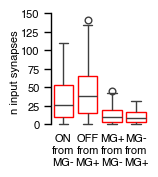

In [818]:
hfig,ax = plt.subplots(1,figsize=(1.25,1.5))
sns.boxplot(data=convergence_counts,y='convergence_count',x='post_type',legend=False,
            order=['lf','lg','mg2','mg1'],
        ax=ax,**{'boxprops':{'facecolor':'none', 'edgecolor':'red'}})#,dodge=0.8)
# sns.stripplot(ax = ax, data=convergence_counts,x = 'post_type',y='convergence_count',s=3,dodge=True,jitter=0.2,alpha=0.4,color='black',legend=False)

# ax.set_ylabel('number of target cells')
ax.set_ylabel('n input synapses')
ax.set_xlabel('')
ax.set_yticks([0,25,50,75,100,125,150]) #([0,20,40,60])#
ax.set_xticklabels(['ON\nfrom\nMG-','OFF\nfrom\nMG+','MG+\nfrom\nMG-','MG-\nfrom\nMG+'])
ax.tick_params(axis='x', which='major', length=0)
sns.despine(bottom=True,trim=True)


plt.savefig('/Users/kperks/Downloads/MG_postsyn_convergence_weight_all.svg') 

In [861]:
# list(filtered_df.groupby(['pre_type','pre']))

# Initialize an empty DataFrame to store the results
convergence_counts = pd.DataFrame(columns=['pre_type', 'post_type', 'post', 'convergence_count'])

# Iterate over each desired combination
for pre_type, post_type in desired_combinations:
    # Filter the DataFrame for the current combination
    subset_df = df_edges[(df_edges['pre_type'] == pre_type) & (df_edges['post_type'] == post_type)]
    
    # Group by pre and count unique post cells for each pre cell
    subset_convergence_counts = subset_df.groupby(['pre_type', 'post'])['pre'].nunique().reset_index()
    subset_convergence_counts.rename(columns={'pre': 'convergence_count'}, inplace=True)

    # # Group by pre and count synapse total for each pre cell
    # subset_convergence_counts = subset_df.groupby(['pre_type', 'post'])['weight'].sum().reset_index()
    # subset_convergence_counts.rename(columns={'weight': 'convergence_count'}, inplace=True)
    
    # Add pre_type and post_type columns
    subset_convergence_counts['post_type'] = post_type
    
    # Append the subset DataFrame to the results DataFrame
    convergence_counts = pd.concat([convergence_counts, subset_convergence_counts])

# # Display the resulting DataFrame
convergence_counts.head()
convergence_counts[convergence_counts['convergence_count'] != 0]
convergence_counts['convergence_count'] = convergence_counts['convergence_count'].astype(int)

/var/folders/4n/x3rls3t16fn723p1tbd7w7fr0000gn/T/ipykernel_13568/2090931759.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['ON\nfrom\nMG-','OFF\nfrom\nMG+','MG+\nfrom\nMG-','MG-\nfrom\nMG+'])#ax.set_xticklabels(['MG+\nfrom\nMG-','MG-\nfrom\nMG+'])


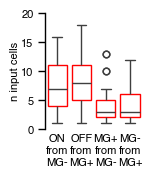

In [820]:
hfig,ax = plt.subplots(1,figsize=(1.25,1.5))
sns.boxplot(data=convergence_counts,y='convergence_count',x='post_type',legend=False,
            order=['lf','lg','mg2','mg1'],
        ax=ax,**{'boxprops':{'facecolor':'none', 'edgecolor':'red'}})#,dodge=0.8)
# sns.stripplot(ax = ax, data=convergence_counts,x = 'post_type',y='convergence_count',s=3,dodge=True,jitter=0.2,alpha=0.4,color='black',legend=False)

# ax.set_ylabel('number of target cells')
ax.set_ylabel('n input cells')
ax.set_xlabel('')
ax.set_yticks([0,5,10,15,20])
ax.set_xticklabels(['ON\nfrom\nMG-','OFF\nfrom\nMG+','MG+\nfrom\nMG-','MG-\nfrom\nMG+'])#ax.set_xticklabels(['MG+\nfrom\nMG-','MG-\nfrom\nMG+'])
ax.tick_params(axis='x', which='major', length=0)
sns.despine(bottom=True,trim=True)


plt.savefig('/Users/kperks/Downloads/MG_postsyn_convergence_cells_all.svg') 

In [862]:
convergence_counts.loc[convergence_counts['post_type'].isin(['mg1','mg2']),'post_class'] = 'mg'
convergence_counts.loc[convergence_counts['post_type'].isin(['lg','lf']),'post_class'] = 'output'
convergence_counts.loc[convergence_counts['pre_type'].isin(['mg1','mg2']),'pre_class'] = 'mg'


In [863]:
convergence_counts[['post_class','convergence_count']].groupby('post_class').describe()

convergence_count                                               
                       count      mean       std  min  25%  50%   75%   max
post_class                                                                 
mg                     112.0  4.062500  2.990318  1.0  2.0  3.0   6.0  13.0
output                  87.0  7.781609  4.354696  1.0  5.0  7.0  11.0  18.0

/var/folders/4n/x3rls3t16fn723p1tbd7w7fr0000gn/T/ipykernel_13568/1134479282.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['MG\nto\nOutput', 'MG\nto\nMG'])


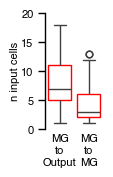

In [823]:
hfig,ax = plt.subplots(1,figsize=(0.75,1.5))
sns.boxplot(data=convergence_counts,y='convergence_count',x='post_class',legend=False,
            order=['output','mg'],
        ax=ax,**{'boxprops':{'facecolor':'none', 'edgecolor':'red'}})#,dodge=0.8)
# sns.stripplot(ax = ax, data=divergence_counts,x = 'pre_type',y='divergence_count',s=3,dodge=True,jitter=0.2,alpha=0.4,color='black',legend=False)

# ax.set_ylabel('number of target cells')
ax.set_ylabel('n input cells')
ax.set_xlabel('')
ax.set_yticks([0,5,10,15,20])
ax.set_xticklabels(['MG\nto\nOutput', 'MG\nto\nMG'])
ax.tick_params(axis='x', which='major', length=0)
sns.despine(bottom=True,trim=True)


plt.savefig('/Users/kperks/Downloads/MG_postsyn_convergence_count_class.svg') 

## Density and Proximity of connected cells

In [829]:
def euclidean_distance(df_loc, cell_id1, cell_id2, dimensions = ['soma_x', 'soma_y_adj', 'soma_z']):
    if cell_id1 not in df_loc.index or cell_id2 not in df_loc.index:
        raise ValueError("Cell IDs not found in the DataFrame.")

    # Extract the coordinates for the two cell IDs
    coordinates1 = df_loc.loc[cell_id1, dimensions]
    coordinates2 = df_loc.loc[cell_id2, dimensions]

    # Check for NaN values in the coordinates
    if any(coordinates1.isna()) or any(coordinates2.isna()):
        raise ValueError("Coordinates contain NaN values.")

    # Calculate the Euclidean distance
    distance = np.linalg.norm(coordinates1 - coordinates2)

    return distance

def pairwise_distances(df, target_ids, dimensions = ['soma_x', 'soma_y_adj', 'soma_z'], source_ids = None, source_coords = None):
    # Extract source coordinates
    if source_ids is not None:
        # source_ids is a tuple of ('column_name',[column_values])
        source_coords = df[df[source_ids[0]].isin(source_ids[1])].loc[:, dimensions].values
    
    # Extract target coordinates
    # target_ids is a tuple of ('column_name',[column_values])
    target_coords = df[df[target_ids[0]].isin(target_ids[1])].loc[:, dimensions].values

    # Handle NaN values
    source_coords = np.nan_to_num(source_coords, nan=np.nan)
    target_coords = np.nan_to_num(target_coords, nan=np.nan)

    # Calculate pairwise distances
    distances = np.linalg.norm(source_coords - target_coords, axis=-1)
    
    return distances

def compute_distance_connectivity(df_loc, df_syn, pre_type, post_type, bin_size=20, max_dist=500):
    # Filter neurons by type
    pre_neurons = df_loc[df_loc["cell_type"] == pre_type]
    post_neurons = df_loc[df_loc["cell_type"] == post_type]

    # Generate all pairwise combinations
    pairs = list(itertools.product(pre_neurons.index, post_neurons.index))
    df_pairs = pd.DataFrame(pairs, columns=["id_a", "id_b"])

    # Merge to get soma positions
    df_pairs = df_pairs.merge(df_loc, left_on="id_a", right_index=True)
    df_pairs = df_pairs.merge(df_loc, left_on="id_b", right_index=True, suffixes=("_a", "_b"))

    # Remove self-pairs
    df_pairs = df_pairs[df_pairs["id_a"] != df_pairs["id_b"]]

    # Compute Euclidean distance (x and z only)
    df_pairs["distance"] = np.sqrt((df_pairs["soma_x_a"] - df_pairs["soma_x_b"])**2 + 
                                   (df_pairs["soma_z_a"] - df_pairs["soma_z_b"])**2)

    # Prepare synaptic connection info
    df_connect = df_syn[['pre', 'post', 'pre_type', 'post_type']].value_counts().reset_index(name='weight')
    df_connect['connection'] = 1
    df_connect = df_connect.rename(columns={'pre': 'id_a', 'post': 'id_b'})

    # Merge connection info into pairs
    df_pairs = df_pairs.merge(df_connect[['id_a', 'id_b', 'weight', 'connection']], 
                              on=['id_a', 'id_b'], how='left')

    df_pairs["weight"] = df_pairs["weight"].fillna(0)
    df_pairs["connection"] = df_pairs["connection"].fillna(0)

    df_pairs = df_pairs[df_pairs['distance']<260]
    # Bin distances
    # bins = np.arange(0, max_dist, bin_size)
    bins = np.arange(0, 260, bin_size)
    df_pairs['distance_binned'] = pd.cut(df_pairs['distance'], bins=bins, labels=bins[1:])

    # Optional: add type labels
    df_pairs['pre_type'] = pre_type
    df_pairs['post_type'] = post_type

    return df_pairs


### Soma diameter and location

In [830]:
# cell_type = dict(zip(df_type['id'].values, df_type['cell_type'].values))

In [831]:
df_soma = efish.measure_soma(nodefiles)

# Compute y-adjusted values
coords = df_soma[['soma_x', 'soma_z']].values * 1000
yoffsets = np.array([efish.func_planar_curve((x, z), *popt) for x, z in coords])
df_soma['soma_y_adj'] = df_soma['soma_y'] - yoffsets / 1000

In [832]:
mask = df_soma['id'].isin(df_type[df_type['cell_type'].isin(['mg1','mg2','lg','lf'])]['id'].values)
df_loc = df_soma[mask][['id','soma_x','soma_z']].dropna(axis=0).set_index('id')

df_loc['cell_type'] = [df_type[df_type['id'] == cid]['cell_type'].values[0] for cid in df_loc.index]

In [833]:
df_loc.head()

,soma_x,soma_z,cell_type
id,,,
126618353,312.74,20.50,mg1
126649726,321.15,25.08,mg2
127607174,234.80,16.59,mg2
127672247,262.41,25.78,mg2
127870654,360.65,22.58,mg1


In [834]:
df_lg = compute_distance_connectivity(df_loc, df_syn, pre_type="mg2", post_type="lg")
df_lf = compute_distance_connectivity(df_loc, df_syn, pre_type="mg1", post_type="lf")
df_mg1 = compute_distance_connectivity(df_loc, df_syn, pre_type="mg2", post_type="mg1")
df_mg2 = compute_distance_connectivity(df_loc, df_syn, pre_type="mg1", post_type="mg2")

df_all = pd.concat([df_lg, df_lf, df_mg1,df_mg2], ignore_index=True)


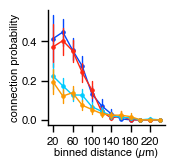

In [839]:
plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
sns.pointplot(data = df_all,x='distance_binned',y='connection',hue='cell_type_b',
              linestyle=None,linewidth=1,palette=cell_colors,legend=False,ax=ax)
# plt.xticks(rotation=90);
# plt.ylim(-0.05,0.75)
# sns.despine(trim=True,offset=1)

x_loc = ax.get_xticks()
ax.set_xticks(x_loc[0::2])
plt.xlabel('binned distance (µm)')
plt.ylabel('connection probability')
plt.savefig('/Users/kperks/Downloads/MG_postsyn_pconnect_distance_Output-and-MG.svg')

# Schematic Fig 1A

In [584]:
# Biphasic EOD waveform

def lognorm(t, t0, tau, sigma):
    x = (t - t0) / tau
    x = np.clip(x, 1e-9, None)
    return np.exp(-(np.log(x)**2) / (2 * sigma**2))

In [589]:
dt = 1e-3
dur_plot = 0.3
t_eod = np.linspace(0, dur_plot, int(dur_plot/dt))

A_pos = 1.6
pos = A_pos * lognorm(t_eod, t0=0.02, tau=0.050, sigma = 0.5)#sigma=0.23)

A_neg = 1.5
neg = A_neg * lognorm(t_eod, t0=0.04, tau=0.055, sigma = 0.5)#, sigma=0.28)

wave = pos - neg
wave /= np.max(np.abs(wave))  # normalized biphasic EOD

# scaling factor (kept from original)
v_stim_mult = 2.5
w_stim = abs(v_stim_mult / np.max(wave))

# plt.plot(t_eod,w_stim * wave)


In [594]:
# Prey modulation parameters
t_prey_plot = np.roll(np.arange(0,  dur_plot, dt),
                      np.random.randint(len(wave)))
amp_prey_plot = np.random.rand(len(t_prey_plot))

seed = 42
rng = np.random.default_rng(seed)

prey = gaussian_filter(
    amp_prey_plot * rng.standard_normal(len(wave)),
    sigma=5/3
)

# prey is only active between these indices
prey_plot = np.zeros(len(prey))
idx_plot = np.arange(int(0.05/dt),
                     int(0.22/dt))
prey_plot[idx_plot] = prey[idx_plot]

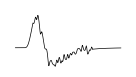

In [597]:
fig, ax = plt.subplots(figsize=(1.5, 0.75))
plt.plot(2*(prey_plot + (w_stim * wave)),color = 'black',linewidth=0.5)
ax.set_ylim(-3,6)
ax.set_xticks([])
ax.set_yticks([])
# ax.set_yticklabels([])
ax.tick_params(axis='both', which='major', length=0)
sns.despine(left=True,bottom=True,trim=True,offset=2)

# ax.set_ylabel('5 synapses') # this needs to match diff between ylims
# ax.set_xlabel(f'GCA fibers (n={len(sorted_full)})')
# ax.legend(title='Postsynaptic \n Type', bbox_to_anchor=(1.15, 1), loc='upper right')
plt.savefig('/Users/kperks/Downloads/EAF_input_biphas.svg')

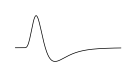

In [598]:
fig, ax = plt.subplots(figsize=(1.5, 0.75))
plt.plot(2*((w_stim * wave)),color = 'black',linewidth=0.5)
ax.set_ylim(-3,6)
ax.set_xticks([])
ax.set_yticks([])
# ax.set_yticklabels([])
ax.tick_params(axis='both', which='major', length=0)
sns.despine(left=True,bottom=True,trim=True,offset=2)

# ax.set_ylabel('5 synapses') # this needs to match diff between ylims
# ax.set_xlabel(f'GCA fibers (n={len(sorted_full)})')
# ax.legend(title='Postsynaptic \n Type', bbox_to_anchor=(1.15, 1), loc='upper right')
plt.savefig('/Users/kperks/Downloads/EOD_input_biphas.svg')

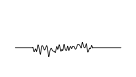

In [599]:
fig, ax = plt.subplots(figsize=(1.5, 0.75))
plt.plot(2*prey_plot,color = 'black',linewidth=0.5)
ax.set_ylim(-3,6)
ax.set_xticks([])
ax.set_yticks([])
# ax.set_yticklabels([])
ax.tick_params(axis='both', which='major', length=0)
sns.despine(left=True,bottom=True,trim=True,offset=2)
# ax.set_ylabel('5 synapses') # this needs to match diff between ylims
# ax.set_xlabel(f'GCA fibers (n={len(sorted_full)})')
# ax.legend(title='Postsynaptic \n Type', bbox_to_anchor=(1.15, 1), loc='upper right')
plt.savefig('/Users/kperks/Downloads/ON_output_biphas.svg')

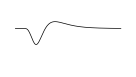

In [600]:
fig, ax = plt.subplots(figsize=(1.5, 0.75))
plt.plot(-w_stim * wave,color = 'black',linewidth=0.5)
ax.set_ylim(-6,3)
ax.set_xticks([])
ax.set_yticks([])
# ax.set_yticklabels([])
ax.tick_params(axis='both', which='major', length=0)
sns.despine(left=True,bottom=True,trim=True,offset=2)
# ax.set_ylabel('5 synapses') # this needs to match diff between ylims
# ax.set_xlabel(f'GCA fibers (n={len(sorted_full)})')
# ax.legend(title='Postsynaptic \n Type', bbox_to_anchor=(1.15, 1), loc='upper right')
plt.savefig('/Users/kperks/Downloads/ON_negimage_biphas.svg')

## granule cell basis

In [1317]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/data_gc.mat')

view_mat_file(data_mat_path)

Top-level keys: ['#refs#', 'data_gc']

Key: #refs#
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['a']

Key: data_gc
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['gc_epsp', 'gc_rate', 'time']


In [1318]:
dfs = {}

# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    recursively_load(f['data_gc'])

print(dfs.keys())

dict_keys(['gc_epsp', 'gc_rate', 'time'])


In [1319]:
# Transpose all DataFrames in the dictionary
for key in dfs:
    dfs[key] = dfs[key].transpose()

2953


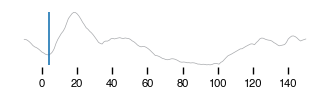

In [1362]:
n = np.random.randint(0,6389)
# n=1572
fig, ax = plt.subplots(figsize=(4, 0.75))
sig = dfs['gc_epsp'][[n]].values#gaussian_filter(dfs['gc_epsp'][[n]],sigma = 3,mode='constant',truncate=1.5)
sig = sig - np.min(sig)
sig = sig/np.max(sig)
plt.plot(dfs['time'].transpose(),sig,color = '#A7A9AC',linewidth=0.5) #[3, 6386, 6385, 6360,2977,5794,3713]
# ax.set_ylim(-0.05,0.1)
# ax.set_xticks([])
ax.set_yticks([])
ax.set_yticklabels([])
ax.vlines(4,0,1)
# ax.tick_params(axis='both', which='major', length=0)
sns.despine(left=True,bottom=True,trim=True,offset=2)
print(n)

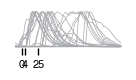

In [1523]:
n_list = [6380,1558,4328,6107,5432,4078,1484,2783,4478,386,3316,2877,6070,6300,4056,6271,6367,2495,3877,6164,2453,6031,2715,4655]
#[2712,3713,4142,1611,5192,2833,3352,6028,3780,6151,4407,6132,6164,1572,3054,1432]#[3, 6386, 6385, 6360,2977,5794,3713] 
fig, ax = plt.subplots(figsize=(1.5, 0.5))
for n in n_list:
# plt.plot(dfs['time'].transpose(),dfs['gc_rate'][n],linewidth=0.5) #[3, 6386, 6385, 
    sig = dfs['gc_epsp'][[n]].values#gaussian_filter(dfs['gc_rate'][[n]],sigma = 3,mode='constant')#,truncate=1.5)
    sig = sig - np.min(sig)
    sig = sig/np.max(sig)
    plt.plot(dfs['time'].transpose(),sig,color = '#A7A9AC',linewidth=0.5) #[3, 6386, 6385, 6360,2977,5794,3713]
# ax.set_ylim(-0.01,0.15)
ax.set_xticks([0,4,25])
ax.set_yticks([])
ax.set_yticklabels([])
# ax.tick_params(axis='both', which='major', length=0)
sns.despine(left=True,bottom=True,trim=True,offset=2)
plt.savefig('/Users/kperks/Downloads/gc_basis_epsp_v2.svg')

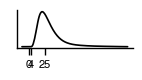

In [1369]:
fig, ax = plt.subplots(figsize=(1.5, 0.5))
plt.plot(dfs['time'].transpose(),dfs['gc_epsp'].sum(axis=1),
        color='black')#gaussian_filter(dfs['gc_rate'].sum(axis=1),sigma = 4,mode='constant'))
ax.set_xticks([0,4,25])
ax.set_yticks([])
ax.set_yticklabels([])
plt.savefig('/Users/kperks/Downloads/gc_basis_epsp_sum.svg')

In [1371]:
df_norm = (dfs['gc_epsp'] - dfs['gc_epsp'].min()) / (dfs['gc_epsp'].max() - dfs['gc_epsp'].min())


In [1374]:
n = len(df_norm)
third = n // 3

set1 = df_norm.iloc[:third]         # first third
set2 = df_norm.iloc[third:2*third]  # second third
set3 = df_norm.iloc[2*third:]       # third third

colsum1 = set1.sum(axis=0)
colsum2 = set2.sum(axis=0)
colsum3 = set3.sum(axis=0)

# Number of columns to select
k = int(len(df_norm.columns) * 0.10)

top10_set1 = colsum1.nlargest(k).index
top10_set2 = colsum2.nlargest(k).index
top10_set3 = colsum3.nlargest(k).index


In [1413]:
top10_set3

Int64Index([6142, 3058, 6154, 2743, 2443, 6143, 4488, 6125, 2951, 2500,
            ...
            3318, 4228, 3237, 6045, 4619, 2082, 2241, 5461, 3119, 2607],
           dtype='int64', length=639)

[4655]


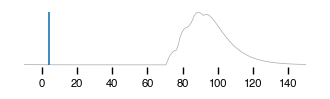

In [1522]:
n = np.random.choice(top10_set3,1)
# n=1572
fig, ax = plt.subplots(figsize=(4, 0.75))
sig = dfs['gc_epsp'][[n[0]]].values#gaussian_filter(dfs['gc_epsp'][[n]],sigma = 3,mode='constant',truncate=1.5)
sig = sig - np.min(sig)
sig = sig/np.max(sig)
plt.plot(dfs['time'].transpose(),sig,color = '#A7A9AC',linewidth=0.5) #[3, 6386, 6385, 6360,2977,5794,3713]
# ax.set_ylim(-0.05,0.1)
# ax.set_xticks([])
ax.set_yticks([])
ax.set_yticklabels([])
ax.vlines(4,0,1)
# ax.tick_params(axis='both', which='major', length=0)
sns.despine(left=True,bottom=True,trim=True,offset=2)
print(n)

In [1442]:
6380,1558,4328,6107,5432,4078,1484,2783,4478,386,3316,2877,6070,6300,4056,6271,6367,2495,3877,6164,2453,6031,2715,4655

(6380, 1558, 4328, 6107, 5432, 4078, 1484, 2783, 4478, 386, 3316, 2877, 6070)

# Modeling Figures

In [1387]:
cmap_dict = {
    'MGm':sns.blend_palette(['#00CBFF','#004D63'], as_cmap=True),#, n_colors= n_colors)#
    'MGp':sns.blend_palette(['#FB9902','#633C01'], as_cmap=True),
    'ON':sns.blend_palette(['#FE2712','#630803'], as_cmap=True),
    'OFF':sns.blend_palette(['#0247FE','#001663'], as_cmap=True),
    'chelix':sns.cubehelix_palette(dark = 0.3, gamma = 1,start=0.5,rot=1,hue=1, as_cmap=True),
    'colorful':sns.color_palette("flare_r", as_cmap=True),
    'grayscale':sns.color_palette(f"ch:rot=0,hue=0,dark={0}, light={light}", as_cmap=True)
}

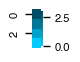

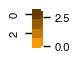

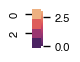

In [1187]:
for d in ['MGm','MGp','colorful']:
    data = np.asarray([3,2,1,0]).reshape(-1, 1)

    fig, ax = plt.subplots(figsize=(0.15,0.5))
    sns.heatmap(data, cmap = cmap_dict[d],ax = ax)
    plt.savefig(f'/Users/kperks/Downloads/{d}.svg', format='svg', transparent=True)

## Figure 4S

In [1188]:
svg_path = '/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/ms/revision_stage/svg/S4/'

### a

In [1239]:
n_colors=3
cmap_dict_s4 = {
    'ON':sns.blend_palette(['#FE2712','#630803'], n_colors= n_colors),
    'OFF':sns.blend_palette(['#0247FE','#001663'], n_colors= n_colors),
}

In [1255]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/figS4/data_fig_8bc_wo_norm.mat')

view_mat_file(data_mat_path)

dfs = {}
# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    recursively_load(dfs,f['data_for_krista_figure_8bc_wo_norm'])

print(dfs.keys())

# Transpose all DataFrames in the dictionary
for key in ['recur_select_no_connec_evolv_E','recur_select_no_connec_evolv_I','sensory_select_no_connec_evolv_E','sensory_select_no_connec_evolv_I']:
    # if len(dfs[key].columns)>1:
    dfs[key] = dfs[key].transpose()

dfs['sensory_select_x_label'].rename(columns={0:'time'},inplace=True)
dfs['recur_select_x_label'].rename(columns={0:'time'},inplace=True)

Top-level keys: ['#refs#', 'data_for_krista_figure_8bc_wo_norm']

Key: #refs#
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['a']

Key: data_for_krista_figure_8bc_wo_norm
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['recur_select_evolv_E', 'recur_select_evolv_I', 'recur_select_no_connec_evolv_E', 'recur_select_no_connec_evolv_I', 'recur_select_param_all', 'recur_select_x_label', 'sensory_select_evolv_E', 'sensory_select_evolv_I', 'sensory_select_no_connec_evolv_E', 'sensory_select_no_connec_evolv_I', 'sensory_select_param_all', 'sensory_select_x_label']
dict_keys(['recur_select_evolv_E', 'recur_select_evolv_I', 'recur_select_no_connec_evolv_E', 'recur_select_no_connec_evolv_I', 'recur_select_param_all', 'recur_select_x_label', 'sensory_select_evolv_E', 'sensory_select_evolv_I', 'sensory_select_no_connec_evolv_E', 'sensory_select_no_connec_evolv_I', 'sensory_select_param_all', 'sensory_select_x_label'])


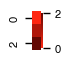

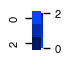

In [1256]:
for d in ['ON','OFF']:
    data = np.asarray([0,1,2]).reshape(-1, 1)

    fig, ax = plt.subplots(figsize=(0.15,0.5))
    sns.heatmap(data, cmap = cmap_dict[d],ax = ax)
    plt.savefig(f'{svg_path}{d}_legend_S4A.svg', format='svg', transparent=True)

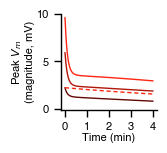

In [1257]:
d = 'sensory_select_evolv_E'
color = 'red'
df_toplot = pd.concat([dfs['sensory_select_x_label'], dfs[d]], axis=1)
df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)
t_ = dfs['sensory_select_x_label']
null = dfs['sensory_select_no_connec_evolv_E']
# manip = dfs[d][2]
# default_mod = dfs[d][0]

hfig = plt.figure(figsize=(1.25,1.25))
ax = plt.gca()
sns.lineplot(data = df_toplot,y = 'rate',x = 'time',hue='condition',linewidth=1, palette = cmap_dict['ON'],legend=False)
# plt.plot(dfs['sensory_select_x_label'],dfs['sensory_select_no_connec_evolv_E'],color=color, dashes = [3,2])

ax.plot(t_,null,color='#FE2712', clip_on=False,linewidth = 1, dashes = [3,2])
# ax.plot(t_,manip,color='#FE2712', clip_on=False, linewidth = 1, linestyle = 'dotted')
# ax.plot(t_,default_mod,color='#FE2712', clip_on=False, linewidth = 1)
# ax.set_xlim(-10,150)
ax.set_xticks([0,1,2,3,4])
ax.set_ylim(-0.1,10)
# ax.set_yticks([10,20,30])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylabel('Peak $V_m$\n(magnitude, mV)') # this needs to match diff between ylims
# ax.set_yticklabels('')
ax.set_xlabel('Time (min)')

plt.savefig(f'{svg_path}{d}.svg', format='svg', transparent=True)

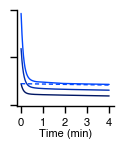

In [1258]:
d = 'sensory_select_evolv_I'
df_toplot = pd.concat([dfs['sensory_select_x_label'], dfs[d]], axis=1)
df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)

t_ = dfs['sensory_select_x_label']
null = dfs['sensory_select_no_connec_evolv_I']
# manip = dfs[d][2]
# default_mod = dfs[d][0]

hfig = plt.figure(figsize=(1.25,1.25))
ax = plt.gca()
sns.lineplot(data = df_toplot,y = 'rate',x = 'time',hue='condition',linewidth=1, palette = cmap_dict['OFF'],legend=False)
# plt.plot(dfs['sensory_select_x_label'],dfs['sensory_select_no_connec_evolv_I'],color='gray',linewidth=0.5)
ax.plot(t_,null,color='#0247FE', clip_on=False,linewidth = 1, dashes = [3,2])
# ax.plot(t_,manip,color='#0247FE', clip_on=False, linewidth = 1, linestyle = 'dotted')
# ax.plot(t_,default_mod,color='#0247FE', clip_on=False, linewidth = 1)
# ax.set_xlim(-10,150)
ax.set_xticks([0,1,2,3,4])
ax.set_ylim(-0.1,10)
# ax.set_yticks([10,20,30])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylabel('') # this needs to match diff between ylims
ax.set_yticklabels('')
ax.set_xlabel('Time (min)')

plt.savefig(f'{svg_path}{d}.svg', format='svg', transparent=True)

### b

In [1246]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/figS4/data_fig_8a.mat')

view_mat_file(data_mat_path)

dfs = {}
# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    recursively_load(dfs,f['data_for_krista_figure_8a'])

print(dfs.keys())

# Transpose all DataFrames in the dictionary
for key in dfs:
    if len(dfs[key].columns)>1:
        dfs[key] = dfs[key].transpose()

dfs['w_mg_mg_param_all']= dfs['w_mg_mg_param_all'].rename(columns={0: 'strength'})
dfs['w_op_mg_param_all']= dfs['w_op_mg_param_all'].rename(columns={0: 'strength'})

Top-level keys: ['#refs#', 'data_for_krista_figure_8a']

Key: #refs#
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['a']

Key: data_for_krista_figure_8a
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['w_mg_mg_E_norm', 'w_mg_mg_E_rand', 'w_mg_mg_E_rever', 'w_mg_mg_I_norm', 'w_mg_mg_I_rand', 'w_mg_mg_I_rever', 'w_mg_mg_param_all', 'w_op_mg_E_norm', 'w_op_mg_E_rand', 'w_op_mg_E_rever', 'w_op_mg_I_norm', 'w_op_mg_I_rand', 'w_op_mg_I_rever', 'w_op_mg_param_all']
dict_keys(['w_mg_mg_E_norm', 'w_mg_mg_E_rand', 'w_mg_mg_E_rever', 'w_mg_mg_I_norm', 'w_mg_mg_I_rand', 'w_mg_mg_I_rever', 'w_mg_mg_param_all', 'w_op_mg_E_norm', 'w_op_mg_E_rand', 'w_op_mg_E_rever', 'w_op_mg_I_norm', 'w_op_mg_I_rand', 'w_op_mg_I_rever', 'w_op_mg_param_all'])


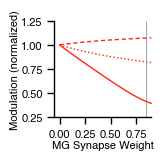

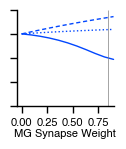

In [1218]:
# ########### ON CELL
d = 'ON_learning_model_MgMg_connections'

t_ = np.asarray(dfs['w_mg_mg_param_all']['strength'].to_list())
on_mg_rev = np.asarray(dfs['w_mg_mg_E_rever'][0].to_list())
on_mg_rand = np.asarray(dfs['w_mg_mg_E_rand'][0].to_list())
on_mg = np.asarray(dfs['w_mg_mg_E_norm'][0].to_list())

plt.figure(figsize=(1.25,1.25))
ax = plt.gca()
ax.plot(t_,on_mg_rev,color='#FE2712', clip_on=False,linewidth = 1, dashes = [3,2])
ax.plot(t_,on_mg_rand,color='#FE2712', clip_on=False, linewidth = 1, linestyle = 'dotted')
ax.plot(t_,on_mg,color='#FE2712', clip_on=False, linewidth = 1)
ax.set_xlim(-0.05,0.9)
ax.set_xticks([0,0.25,0.5,0.75])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylim(0.25,1.25)
ax.set_yticks([0.25,0.5,0.75,1,1.25])
ax.vlines(0.85,0.25,1.25,color='gray',linewidth=0.5)
ax.set_ylabel('Modulation (normalized)') # this needs to match diff between ylims
# ax.set_yticklabels('')
ax.set_xlabel('MG Synapse Weight')

plt.savefig(f'{svg_path}{d}_linestyle.svg', format='svg', transparent=True)

# ########### OFF CELL
d = 'OFF_learning_model_MgMg_connections'


t_ = np.asarray(dfs['w_mg_mg_param_all']['strength'].to_list())
off_mg_rev = np.asarray(dfs['w_mg_mg_I_rever'][0].to_list())
off_mg_rand = np.asarray(dfs['w_mg_mg_I_rand'][0].to_list())
off_mg = np.asarray(dfs['w_mg_mg_I_norm'][0].to_list())

plt.figure(figsize=(1.25,1.25))
ax = plt.gca()
ax.plot(t_,off_mg_rev,color='#0247FE', clip_on=False,linewidth = 1, dashes = [3,2])
ax.plot(t_,off_mg_rand,color='#0247FE', clip_on=False, linewidth = 1, linestyle = 'dotted')
ax.plot(t_,off_mg,color='#0247FE', clip_on=False, linewidth = 1)
ax.set_xlim(-0.05,0.9)
ax.set_xticks([0,0.25,0.5,0.75])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylim(0.25,1.25)
ax.set_yticks([0.25,0.5,0.75,1,1.25])
ax.vlines(0.85,0.25,1.25,color='gray',linewidth=0.5)
ax.set_ylabel('') # this needs to match diff between ylims
ax.set_yticklabels('')
ax.set_xlabel('MG Synapse Weight')

plt.savefig(f'{svg_path}{d}_linestyle.svg', format='svg', transparent=True)

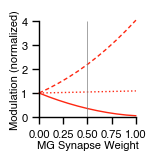

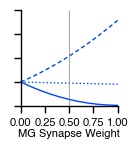

In [1219]:
# ########### ON CELL
d = 'ON_learning_model_MgOutput_connections'

t_ = np.asarray(dfs['w_op_mg_param_all']['strength'].to_list())
on_mg_rev = np.asarray(dfs['w_op_mg_E_rever'][0].to_list())
on_mg_rand = np.asarray(dfs['w_op_mg_E_rand'][0].to_list())
on_mg = np.asarray(dfs['w_op_mg_E_norm'][0].to_list())

plt.figure(figsize=(1.25,1.25))
ax = plt.gca()
ax.plot(t_,on_mg_rev,color='#FE2712', clip_on=False,linewidth = 1, dashes = [3,2])
ax.plot(t_,on_mg_rand,color='#FE2712', clip_on=False, linewidth = 1, linestyle = 'dotted')
ax.plot(t_,on_mg,color='#FE2712', clip_on=False, linewidth = 1)
ax.set_xlim(0,1)
ax.set_xticks([0,0.25,0.5,0.75,1])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylim(0,4)
ax.set_yticks([0,1,2,3,4])
ax.vlines(0.5,0,4,color='gray',linewidth=0.5)
ax.set_ylabel('Modulation (normalized)') # this needs to match diff between ylims
# ax.set_yticklabels('')
ax.set_xlabel('MG Synapse Weight')

plt.savefig(f'{svg_path}{d}_linestyle.svg', format='svg', transparent=True)

# ########### OFF CELL
d = 'OFF_learning_model_MgOutput_connections'


t_ = np.asarray(dfs['w_op_mg_param_all']['strength'].to_list())
off_mg_rev = np.asarray(dfs['w_op_mg_I_rever'][0].to_list())
off_mg_rand = np.asarray(dfs['w_op_mg_I_rand'][0].to_list())
off_mg = np.asarray(dfs['w_op_mg_I_norm'][0].to_list())

plt.figure(figsize=(1.25,1.25))
ax = plt.gca()
ax.plot(t_,off_mg_rev,color='#0247FE', clip_on=False,linewidth = 1, dashes = [3,2])
ax.plot(t_,off_mg_rand,color='#0247FE', clip_on=False, linewidth = 1, linestyle = 'dotted')
ax.plot(t_,off_mg,color='#0247FE', clip_on=False, linewidth = 1)
ax.set_xlim(0,1)
ax.set_xticks([0,0.25,0.5,0.75,1])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylim(0,4)
ax.set_yticks([0,1,2,3,4])
ax.vlines(0.5,0,4,color='gray',linewidth=0.5)
ax.set_ylabel('') # this needs to match diff between ylims
ax.set_yticklabels('')
ax.set_xlabel('MG Synapse Weight')

plt.savefig(f'{svg_path}{d}_linestyle.svg', format='svg', transparent=True)

### c

In [1248]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/figS4/data_fig_8bc_wo_norm.mat')

view_mat_file(data_mat_path)

dfs = {}
# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    recursively_load(dfs,f['data_for_krista_figure_8bc_wo_norm'])

print(dfs.keys())

# Transpose all DataFrames in the dictionary
for key in ['recur_select_no_connec_evolv_E','recur_select_no_connec_evolv_I','sensory_select_no_connec_evolv_E','sensory_select_no_connec_evolv_I']:
    # if len(dfs[key].columns)>1:
    dfs[key] = dfs[key].transpose()

dfs['sensory_select_x_label'].rename(columns={0:'time'},inplace=True)
dfs['recur_select_x_label'].rename(columns={0:'time'},inplace=True)

Top-level keys: ['#refs#', 'data_for_krista_figure_8bc_wo_norm']

Key: #refs#
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['a']

Key: data_for_krista_figure_8bc_wo_norm
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['recur_select_evolv_E', 'recur_select_evolv_I', 'recur_select_no_connec_evolv_E', 'recur_select_no_connec_evolv_I', 'recur_select_param_all', 'recur_select_x_label', 'sensory_select_evolv_E', 'sensory_select_evolv_I', 'sensory_select_no_connec_evolv_E', 'sensory_select_no_connec_evolv_I', 'sensory_select_param_all', 'sensory_select_x_label']
dict_keys(['recur_select_evolv_E', 'recur_select_evolv_I', 'recur_select_no_connec_evolv_E', 'recur_select_no_connec_evolv_I', 'recur_select_param_all', 'recur_select_x_label', 'sensory_select_evolv_E', 'sensory_select_evolv_I', 'sensory_select_no_connec_evolv_E', 'sensory_select_no_connec_evolv_I', 'sensory_select_param_all', 'sensory_select_x_label'])


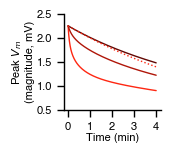

In [1259]:
d = 'recur_select_evolv_E'
df_toplot = pd.concat([dfs['recur_select_x_label'], dfs[d]], axis=1)
df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)
t_ = dfs['sensory_select_x_label']
null = dfs['recur_select_no_connec_evolv_E']
# manip = dfs[d][0]
# default_mod = dfs[d][2]

hfig = plt.figure(figsize=(1.25,1.25))
ax = plt.gca()
sns.lineplot(data = df_toplot,y = 'rate',x = 'time',hue='condition',linewidth=1, palette = cmap_dict['ON'],legend=False)
# plt.plot(dfs['recur_select_x_label'],dfs['recur_select_no_connec_evolv_E'],color='gray',linewidth=0.5)
ax.plot(t_,null,color='#FE2712', clip_on=False,linewidth = 1, linestyle = 'dotted')
# ax.plot(t_,manip,color='#FE2712', clip_on=False, linewidth = 1, linestyle = 'dotted')
# ax.plot(t_,default_mod,color='#FE2712', clip_on=False, linewidth = 1)
# ax.set_xlim(-10,150)
ax.set_xticks([0,1,2,3,4])
ax.set_ylim(0.5,2.5)
# ax.set_yticks([10,20,30])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylabel('Peak $V_m$\n(magnitude, mV)')  # this needs to match diff between ylims
# ax.set_yticklabels('')
ax.set_xlabel('Time (min)')

plt.savefig(f'{svg_path}{d}.svg', format='svg', transparent=True)

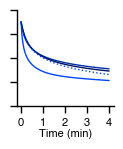

In [1260]:
d = 'recur_select_evolv_I'
df_toplot = pd.concat([dfs['recur_select_x_label'], dfs[d]], axis=1)
df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)
t_ = dfs['sensory_select_x_label']
null = dfs['recur_select_no_connec_evolv_I']
# manip = dfs[d][2]
# default_mod = dfs[d][0]

hfig = plt.figure(figsize=(1.25,1.25))
ax = plt.gca()
sns.lineplot(data = df_toplot,y = 'rate',x = 'time',hue='condition',linewidth=1, palette = cmap_dict['OFF'],legend=False)
# plt.plot(dfs['recur_select_x_label'],dfs['recur_select_no_connec_evolv_I'],color='gray',linewidth=0.5)
ax.plot(t_,null,color='#0247FE', clip_on=False,linewidth = 1, linestyle = 'dotted')
# ax.plot(t_,manip,color='#0247FE', clip_on=False, linewidth = 1, linestyle = 'dotted')
# ax.plot(t_,default_mod,color='#0247FE', clip_on=False, linewidth = 1)
# ax.set_xlim(-10,150)
ax.set_xticks([0,1,2,3,4])

ax.set_ylim(0.5,2.5)
# ax.set_yticks([10,20,30])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylabel('') # this needs to match diff between ylims
ax.set_yticklabels('')
ax.set_xlabel('Time (min)')

plt.savefig(f'{svg_path}{d}.svg', format='svg', transparent=True)

### d

In [1223]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/figS4/data_fig_8d.mat')

view_mat_file(data_mat_path)

dfs = {}
# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    recursively_load(dfs,f['data_for_krista_figure_8d'])

print(dfs.keys())

# Transpose all DataFrames in the dictionary
for key in dfs.keys():
    # if len(dfs[key].columns)>1:
    dfs[key] = dfs[key].transpose()

Top-level keys: ['#refs#', 'data_for_krista_figure_8d']

Key: #refs#
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['a']

Key: data_for_krista_figure_8d
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['recur_non_selective_E', 'recur_non_selective_I', 'recur_partly_selective_E', 'recur_partly_selective_I', 'x_label_min']
dict_keys(['recur_non_selective_E', 'recur_non_selective_I', 'recur_partly_selective_E', 'recur_partly_selective_I', 'x_label_min'])


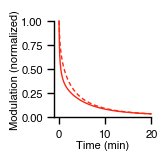

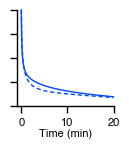

In [1224]:
# ########### ON CELL
d = 'ON_recur_selectivity_timecourse'

non_selective = dfs['recur_non_selective_E'][0].to_list()
partly_selective = dfs['recur_partly_selective_E'][0].to_list()
t_ = dfs['x_label_min'].transpose()[0].to_list()

plt.figure(figsize=(1.25,1.25))
ax = plt.gca()
ax.plot(t_,partly_selective,color='#FE2712', clip_on=False,linewidth = 1, dashes = [3,2])
ax.plot(t_,non_selective,color='#FE2712', clip_on=False, linewidth = 1)
ax.set_xlim(-1,20)
ax.set_xticks([0,10,20])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylim(0,1)
ax.set_ylabel('Modulation (normalized)') # this needs to match diff between ylims
# ax.set_yticklabels('')
ax.set_xlabel('Time (min)')

plt.savefig(f'{svg_path}{d}_linestyle.svg', format='svg', transparent=True)

# ########### OFF CELL
d = 'OFF_recur_selectivity_timecourse'

non_selective = dfs['recur_non_selective_I'][0].to_list()
partly_selective = dfs['recur_partly_selective_I'][0].to_list()
t_ = dfs['x_label_min'].transpose()[0].to_list()

plt.figure(figsize=(1.25,1.25))
ax = plt.gca()
ax.plot(t_,partly_selective,color='#0247FE', clip_on=False,linewidth = 1, dashes = [3,2])
ax.plot(t_,non_selective,color='#0247FE', clip_on=False, linewidth = 1)
ax.set_xlim(-1,20)
ax.set_xticks([0,10,20])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylim(0,1)
ax.set_ylabel('') # this needs to match diff between ylims
ax.set_yticklabels('')
ax.set_xlabel('Time (min)')

plt.savefig(f'{svg_path}{d}_linestyle.svg', format='svg', transparent=True)

### e

In [1225]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/figS4/data_fig_8f.mat')

view_mat_file(data_mat_path)

dfs = {}
# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    recursively_load(dfs,f['data_for_krista_figure_8f'])

print(dfs.keys())

dfs['sg_learn_x_label'].rename(columns={0:'time'},inplace=True)

Top-level keys: ['#refs#', 'data_for_krista_figure_8f']

Key: #refs#
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['a']

Key: data_for_krista_figure_8f
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['sg_learn_evolv_E', 'sg_learn_evolv_I', 'sg_learn_param_all', 'sg_learn_x_label']
dict_keys(['sg_learn_evolv_E', 'sg_learn_evolv_I', 'sg_learn_param_all', 'sg_learn_x_label'])


In [1226]:
dfs['sg_learn_param_all']

,0
0,0.0
1,0.5
2,1.0


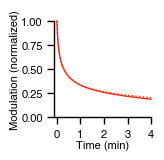

In [1227]:
d = 'sg_learn_evolv_E'
# df_toplot = pd.concat([dfs['sg_learn_x_label'], dfs[d]], axis=1)
# df_toplot = df_toplot.melt(
#     id_vars='time',
#     var_name='condition',
#     value_name='rate'
# )
t_ = dfs['sg_learn_x_label']

manip = dfs[d][2]
default_mod = dfs[d][0]

plt.figure(figsize=(1.25,1.25))
ax = plt.gca()
# sns.lineplot(data = df_toplot,y = 'rate',x = 'time',hue='condition',linewidth=1, palette = cmap_dict['ON'],legend=False)
ax.plot(t_,manip,color='#FE2712', clip_on=False, linewidth = 1, linestyle = 'dotted')
ax.plot(t_,default_mod,color='#FE2712', clip_on=False, linewidth = 1)
ax.set_xlim(-0.1,4)
ax.set_xticks([0,1,2,3,4])
ax.set_ylim(0,1)
# ax.set_yticks([10,20,30])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylabel('Modulation (normalized)') # this needs to match diff between ylims
# ax.set_yticklabels('')
ax.set_xlabel('Time (min)')

plt.savefig(f'{svg_path}{d}.svg', format='svg', transparent=True)

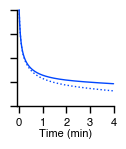

In [1228]:
d = 'sg_learn_evolv_I'
# df_toplot = pd.concat([dfs['sg_learn_x_label'], dfs[d]], axis=1)
# df_toplot = df_toplot.melt(
#     id_vars='time',
#     var_name='condition',
#     value_name='rate'
# )

t_ = dfs['sg_learn_x_label']

manip = dfs[d][2]
default_mod = dfs[d][0]

plt.figure(figsize=(1.25,1.25))
ax = plt.gca()
# sns.lineplot(data = df_toplot,y = 'rate',x = 'time',hue='condition',linewidth=1, palette = cmap_dict['OFF'],legend=False)
ax.plot(t_,manip,color='#0247FE', clip_on=False, linewidth = 1, linestyle = 'dotted')
ax.plot(t_,default_mod,color='#0247FE', clip_on=False, linewidth = 1)
ax.set_xlim(-0.1,4)
ax.set_xticks([0,1,2,3,4])
ax.set_ylim(0,1)
# ax.set_yticks([10,20,30])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylabel('') # this needs to match diff between ylims
ax.set_yticklabels('')
ax.set_xlabel('Time (min)')

plt.savefig(f'{svg_path}{d}.svg', format='svg', transparent=True)

### f

In [1229]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/figS4/data_fig_6S_model.mat')

view_mat_file(data_mat_path)

dfs = {}

# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    recursively_load(dfs,f['data_for_krista_6S_model_progress'])

print(dfs.keys())

# Transpose all DataFrames in the dictionary
for key in dfs:
    if len(dfs[key].columns)>1:
        dfs[key] = dfs[key].transpose()

dfs['time_model'] = dfs['time_model'].rename(columns={0: 'time'})


Top-level keys: ['#refs#', 'data_for_krista_6S_model_progress']

Key: #refs#
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['a']

Key: data_for_krista_6S_model_progress
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['OFF_neg_img_needed', 'OFF_neg_img_network_only', 'OFF_neg_img_network_only_infinty', 'OFF_neg_img_network_plus_self', 'OFF_neg_img_network_plus_self_infinty', 'OFF_pair', 'OFF_pair_mV', 'OFF_recovery', 'ON_neg_img_needed', 'ON_neg_img_network_only', 'ON_neg_img_network_only_infinty', 'ON_neg_img_network_plus_self', 'ON_neg_img_network_plus_self_infinty', 'ON_recovery', 'mgM_pair', 'mgM_recovery', 'mgM_recovery_no_recurr', 'mgP_recovery', 'mgP_simple_pair', 'no_recurr_mgM_recovery', 'time_model', 'v_OFF_alone', 'v_OFF_initial', 'v_OFF_w_mg_with_recur', 'v_OFF_w_mg_wo_recur', 'v_ON_alone', 'v_ON_initial', 'v_ON_w_mg_with_recur', 'v_ON_w_mg_wo_recur']
dict_keys(['OFF_neg_img_needed', 'OFF_neg_img_network_only', 'OFF_neg_img_networ

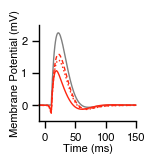

In [1230]:
########### MODEL
d = 'ON_learning_network'

t_ = np.asarray(dfs['time_model']['time'].to_list())
out = np.asarray(dfs['v_ON_alone'][0].to_list())
out_initial = np.asarray(dfs['v_ON_initial'][0].to_list())
out_mg = np.asarray(dfs['v_ON_w_mg_wo_recur'][0].to_list())
out_mg_mg = np.asarray(dfs['v_ON_w_mg_with_recur'][0].to_list())

plt.figure(figsize=(1.25,1.25))
ax = plt.gca()
ax.plot(t_,out_initial,color='gray', clip_on=False, linewidth = 1)
ax.plot(t_,out,color='#FE2712', clip_on=False,linewidth = 1, dashes = [3,2])
ax.plot(t_,out_mg,color='#FE2712', clip_on=False, linewidth = 1, linestyle = 'dotted')
ax.plot(t_,out_mg_mg,color='#FE2712', clip_on=False, linewidth = 1)
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylim(-0.5,2.5)
ax.set_ylabel('Membrane Potential (mV)') # this needs to match diff between ylims
# ax.set_yticklabels('')
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_color.svg', format='svg', transparent=True)

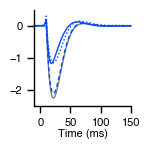

In [1231]:
########### MODEL
d = 'OFF_learning_network'

t_ = np.asarray(dfs['time_model']['time'].to_list())
out = np.asarray(dfs['v_OFF_alone'][0].to_list())
out_initial = np.asarray(dfs['v_OFF_initial'][0].to_list())
out_mg = np.asarray(dfs['v_OFF_w_mg_wo_recur'][0].to_list())
out_mg_mg = np.asarray(dfs['v_OFF_w_mg_with_recur'][0].to_list())

plt.figure(figsize=(1.25,1.25))
ax = plt.gca()
ax.plot(t_,out_initial,color='gray', clip_on=False, linewidth = 1)
ax.plot(t_,out,color='#0247FE', clip_on=False,linewidth = 1, dashes = [3,2])
ax.plot(t_,out_mg,color='#0247FE', clip_on=False, linewidth = 1, linestyle = 'dotted')
ax.plot(t_,out_mg_mg,color='#0247FE', clip_on=False, linewidth = 1)
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylim(-2.5,0.5)
ax.set_ylabel('') # this needs to match diff between ylims
# ax.set_yticklabels('')
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_color.svg', format='svg', transparent=True)

### g

In [1232]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/figS4/data_fig_6S_data.mat')

view_mat_file(data_mat_path)

dfs = {}

# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    recursively_load(dfs,f['data_for_krista_6S_data_progress'])

print(dfs.keys())

# Transpose all DataFrames in the dictionary
for key in dfs:
    if len(dfs[key].columns)>1:
        dfs[key] = dfs[key].transpose()



Top-level keys: ['#refs#', 'data_for_krista_6S_data_progress']

Key: #refs#
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['a']

Key: data_for_krista_6S_data_progress
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['OFF_baseline', 'OFF_pair', 'OFF_pair_mV', 'OFF_recovery', 'OFF_vm_baseline', 'ON_recovery', 'ON_simple_ratio', 'mgM_baseline', 'mgM_pair', 'mgM_recovery', 'mgP_recovery', 'mgP_simple_baseline', 'mgP_simple_pair', 'mgP_simple_pair_subtracted', 'mg_broad_ratio', 'time_data']
dict_keys(['OFF_baseline', 'OFF_pair', 'OFF_pair_mV', 'OFF_recovery', 'OFF_vm_baseline', 'ON_recovery', 'ON_simple_ratio', 'mgM_baseline', 'mgM_pair', 'mgM_recovery', 'mgP_recovery', 'mgP_simple_baseline', 'mgP_simple_pair', 'mgP_simple_pair_subtracted', 'mg_broad_ratio', 'time_data'])


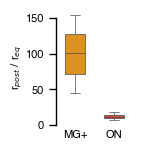

In [1233]:
dfs['mg_broad_ratio']['type']='mg'
dfs['ON_simple_ratio']['type']='output'

df_toplot = pd.concat([dfs['mg_broad_ratio'],dfs['ON_simple_ratio']],ignore_index=True)

plt.figure(figsize=(1,1.5))#0.75))
ax = plt.gca()
# sns.stripplot(df_toplot,y = 0,x='type',legend=False,color='black',s = 3,alpha = 0.5,ax = ax,jitter = 0.25)
sns.boxplot(df_toplot,y = 0,x='type',legend=False,hue = 'type',
            palette = {'mg':"#FB9902",'output':'#FE2712'},width = 0.5,linewidth=0.5,zorder=3)
ax.set_xticks([0, 1])
ax.set_xticklabels(['MG+', 'ON'])
ax.tick_params(axis='x', which='major', length=0)
ax.set_xlabel('')
ax.set_ylabel('r$_{post}$ / r$_{eq}$')#('Max Spike Rate (Hz)\n(normalized to baseline)')
sns.despine(bottom=True,trim=True)

plt.savefig(f'{svg_path}max_spike_rate_norm.svg', format='svg', transparent=True)

### h

In [1234]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/figS4/data_fig_6S_model.mat')

view_mat_file(data_mat_path)

dfs = {}

# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    recursively_load(dfs,f['data_for_krista_6S_model_progress'])

print(dfs.keys())

# Transpose all DataFrames in the dictionary
for key in dfs:
    if len(dfs[key].columns)>1:
        dfs[key] = dfs[key].transpose()

dfs['time_model'] = dfs['time_model'].rename(columns={0: 'time'})


Top-level keys: ['#refs#', 'data_for_krista_6S_model_progress']

Key: #refs#
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['a']

Key: data_for_krista_6S_model_progress
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['OFF_neg_img_needed', 'OFF_neg_img_network_only', 'OFF_neg_img_network_only_infinty', 'OFF_neg_img_network_plus_self', 'OFF_neg_img_network_plus_self_infinty', 'OFF_pair', 'OFF_pair_mV', 'OFF_recovery', 'ON_neg_img_needed', 'ON_neg_img_network_only', 'ON_neg_img_network_only_infinty', 'ON_neg_img_network_plus_self', 'ON_neg_img_network_plus_self_infinty', 'ON_recovery', 'mgM_pair', 'mgM_recovery', 'mgM_recovery_no_recurr', 'mgP_recovery', 'mgP_simple_pair', 'no_recurr_mgM_recovery', 'time_model', 'v_OFF_alone', 'v_OFF_initial', 'v_OFF_w_mg_with_recur', 'v_OFF_w_mg_wo_recur', 'v_ON_alone', 'v_ON_initial', 'v_ON_w_mg_with_recur', 'v_ON_w_mg_wo_recur']
dict_keys(['OFF_neg_img_needed', 'OFF_neg_img_network_only', 'OFF_neg_img_networ

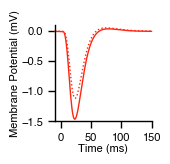

In [1235]:
########### MODEL
d = 'ON_network_contribution'

t_ = np.asarray(dfs['time_model']['time'].to_list())
mg = np.asarray(dfs['ON_neg_img_network_only'][0].to_list())
out_mg = np.asarray(dfs['ON_neg_img_network_plus_self'][0].to_list())

plt.figure(figsize=(1.25,1.25))
ax = plt.gca()
ax.plot(t_,mg,color='#FE2712', clip_on=False, linewidth = 1, linestyle = 'dotted')
ax.plot(t_,out_mg,color='#FE2712', clip_on=False, linewidth = 1)
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylim(-1.5,0.1)
ax.set_ylabel('Membrane Potential (mV)') # this needs to match diff between ylims
# ax.set_yticklabels('')
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_color.svg', format='svg', transparent=True)

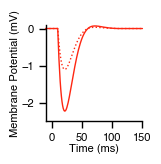

In [1236]:
########### MODEL
d = 'ON_network_contribution_infinity'

t_ = np.asarray(dfs['time_model']['time'].to_list())
mg = np.asarray(dfs['ON_neg_img_network_only_infinty'][0].to_list())
out_mg = np.asarray(dfs['ON_neg_img_network_plus_self_infinty'][0].to_list())
### include?: 'ON_neg_img_needed'

plt.figure(figsize=(1.25,1.25))
ax = plt.gca()
ax.plot(t_,mg,color='#FE2712', clip_on=False, linewidth = 1, linestyle = 'dotted')
ax.plot(t_,out_mg,color='#FE2712', clip_on=False, linewidth = 1)
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylim(-2.5,0.1)
ax.set_ylabel('Membrane Potential (mV)') # this needs to match diff between ylims
# ax.set_yticklabels('')
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_color.svg', format='svg', transparent=True)

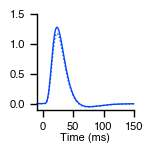

In [1237]:
########### MODEL
d = 'OFF_network_contribution'

t_ = np.asarray(dfs['time_model']['time'].to_list())
mg = np.asarray(dfs['OFF_neg_img_network_only'][0].to_list())
out_mg = np.asarray(dfs['OFF_neg_img_network_plus_self'][0].to_list())

plt.figure(figsize=(1.25,1.25))
ax = plt.gca()
ax.plot(t_,mg,color='#0247FE', clip_on=False, linewidth = 1, linestyle = 'dotted')
ax.plot(t_,out_mg,color='#0247FE', clip_on=False, linewidth = 1)
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylim(-0.1,1.5)
ax.set_ylabel('') # this needs to match diff between ylims
# ax.set_yticklabels('')
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_color.svg', format='svg', transparent=True)

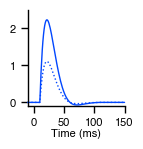

In [1238]:
########### MODEL
d = 'OFF_network_contribution_infinity'

t_ = np.asarray(dfs['time_model']['time'].to_list())
mg = np.asarray(dfs['OFF_neg_img_network_only_infinty'][0].to_list())
out_mg = np.asarray(dfs['OFF_neg_img_network_plus_self_infinty'][0].to_list())
### also include?: 'OFF_neg_img_needed'

plt.figure(figsize=(1.25,1.25))
ax = plt.gca()
ax.plot(t_,mg,color='#0247FE', clip_on=False, linewidth = 1, linestyle = 'dotted')
ax.plot(t_,out_mg,color='#0247FE', clip_on=False, linewidth = 1)
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylim(-0.1,2.5)
ax.set_ylabel('') # this needs to match diff between ylims
# ax.set_yticklabels('')
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_color.svg', format='svg', transparent=True)

## Figure 6

In [1452]:
svg_path = '/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/ms/revision_stage/svg/Fig6/'

### b MG

In [1454]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/fig6/data_fig_6b.mat')

view_mat_file(data_mat_path)

dfs = {}

# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    recursively_load(dfs,f['data_for_krista_figure_6b'])

print(dfs.keys())

# Transpose all DataFrames in the dictionary
for key in dfs:
    dfs[key] = dfs[key].transpose()

dfs['time_data_model'] = dfs['time_data_model'].rename(columns={0: 'time'})


Top-level keys: ['#refs#', 'data_for_krista_figure_6b']

Key: #refs#
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['a']

Key: data_for_krista_figure_6b
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['mean_pre_mgP_data', 'mgP_progression_matrix_data', 'mgP_progression_matrix_model', 'sem_pre_mgP_data', 'time_data_model']
dict_keys(['mean_pre_mgP_data', 'mgP_progression_matrix_data', 'mgP_progression_matrix_model', 'sem_pre_mgP_data', 'time_data_model'])


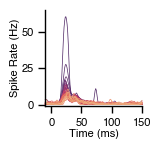

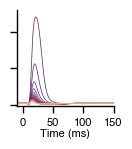

In [1455]:

d = 'mgP_progression_matrix_data'
df_toplot = pd.concat([dfs['time_data_model'], dfs[d]], axis=1)

df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)
t_data = np.asarray(dfs['time_data_model']['time'].to_list())
#######
'''get full pre matrix of data so can do lineplot'''
########
avg_data = np.asarray(dfs['mean_pre_mgP_data'][0].to_list())
sem_data = np.asarray(dfs['sem_pre_mgP_data'][0].to_list())

plt.figure(figsize=(1.25,1.25))#0.75))
ax = plt.gca()
sns.lineplot(data = df_toplot,x = 'time', y = 'rate', hue = 'condition',ax = ax, linewidth = 0.5,clip_on=False,legend = False,palette = cmap_dict['colorful'])
# ax.fill_between(t_data,avg_data+ sem_data,avg_data- sem_data,alpha = 0.2,color='black',zorder = 3,linewidth=0,clip_on=False)
# ax.plot(t_data,avg_data,color='black', linewidth = 0.5,clip_on=False,zorder = 3)
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
ax.set_ylim(-1,65)
ax.set_yticks([0,25,50])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylabel('Spike Rate (Hz)') 
ax.set_xlabel('Time (ms)')
# ax.set_xlabel('') # this needs to match diff between ylims
# ax.set_xticklabels('')

plt.savefig(f'{svg_path}{d}_color.svg', format='svg', transparent=True)

########### MODEL
d = 'mgP_progression_matrix_model'
df_toplot = pd.concat([dfs['time_data_model'], dfs[d]], axis=1)

df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)

plt.figure(figsize=(1.25,1.25))#0.75))
ax = plt.gca()
sns.lineplot(data = df_toplot,x = 'time', y = 'rate', hue = 'condition',ax = ax, linewidth = 0.5,legend = False,palette = cmap_dict['colorful'])
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
ax.set_ylim(-1,65)
ax.set_yticks([0,25,50])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylabel('') # this needs to match diff between ylims
ax.set_yticklabels('')
# ax.set_xlabel('') # this needs to match diff between ylims
# ax.set_xticklabels('')
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_color.svg', format='svg', transparent=True)


### b Output

In [1389]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/fig6/data_fig_6b2.mat')

view_mat_file(data_mat_path)

dfs = {}

# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    recursively_load(dfs,f['data_for_krista_figure_6b2_ON'])

print(dfs.keys())

# Transpose all DataFrames in the dictionary
for key in dfs:
    dfs[key] = dfs[key].transpose()

dfs['time_data_model'] = dfs['time_data_model'].rename(columns={0: 'time'})


Top-level keys: ['#refs#', 'data_for_krista_figure_6b2_ON']

Key: #refs#
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['a']

Key: data_for_krista_figure_6b2_ON
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['mean_pre_opE_data', 'opE_progression_matrix_data', 'opE_progression_matrix_model', 'sem_pre_opE_data', 'time_data_model']
dict_keys(['mean_pre_opE_data', 'opE_progression_matrix_data', 'opE_progression_matrix_model', 'sem_pre_opE_data', 'time_data_model'])


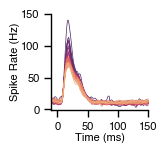

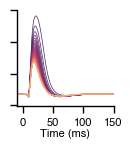

In [1390]:

########### DATA
d = 'opE_progression_matrix_data'
df_toplot = pd.concat([dfs['time_data_model'], dfs[d]], axis=1)

df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)
t_data = np.asarray(dfs['time_data_model']['time'].to_list())
avg_data = np.asarray(dfs['mean_pre_opE_data'][0].to_list())
sem_data = np.asarray(dfs['sem_pre_opE_data'][0].to_list())

plt.figure(figsize=(1.25,1.25))#0.75))
ax = plt.gca()
sns.lineplot(data = df_toplot,x = 'time', y = 'rate', hue = 'condition',ax = ax, linewidth = 0.5,clip_on=False,legend = False,palette = cmap_dict['colorful'])
# ax.fill_between(t_data,avg_data+ sem_data,avg_data- sem_data,alpha = 0.2,color='black',zorder = 3,linewidth=0,clip_on=False)
# ax.plot(t_data,avg_data,color='black', linewidth = 0.5,clip_on=False,zorder = 3)
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
ax.set_ylim(-1,150)
ax.set_yticks([0,50,100,150])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylabel('Spike Rate (Hz)') 
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_color.svg', format='svg', transparent=True)

########### MODEL
d = 'opE_progression_matrix_model'
df_toplot = pd.concat([dfs['time_data_model'], dfs[d]], axis=1)

df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)

plt.figure(figsize=(1.25,1.25))#0.75))
ax = plt.gca()
sns.lineplot(data = df_toplot,x = 'time', y = 'rate', hue = 'condition',ax = ax, linewidth = 0.5,legend = False,palette = cmap_dict['colorful'])
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
ax.set_ylim(-1,150)
ax.set_yticks([0,50,100,150])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylabel('') # this needs to match diff between ylims
ax.set_yticklabels('')
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_color.svg', format='svg', transparent=True)


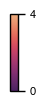

In [505]:
hfig, ax = plt.subplots(1, 1,figsize=(0.1,1))

fraction = 1  # .05

cb = mpl.colorbar.ColorbarBase(ax, orientation='vertical', 
                               norm=mpl.colors.Normalize(0, 4),  # vmax and vmin
                               ticks=[0, 4],
                               cmap=cmap_dict['colorful'])

                               # extend='both',
                               # label='This is a label',
                               

plt.savefig(f'{svg_path}6b_colorful_cmap_color.svg', format='svg', transparent=True)

### c

In [ ]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/fig6/data_fig_6c.mat')

view_mat_file(data_mat_path)

dfs = {}

# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    recursively_load(dfs,f['data_for_krista_figure_6c'])

print(dfs.keys())

# Transpose all DataFrames in the dictionary
# for key in dfs:
#     dfs[key] = dfs[key].transpose()

dfs['time_variance_piring_data'] = dfs['time_variance_piring_data'].rename(columns={0: 'time'})
dfs['time_variance_piring_model'] = dfs['time_variance_piring_model'].rename(columns={0: 'time'})


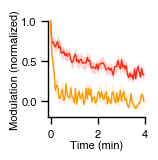

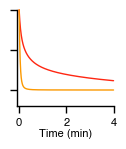

In [1753]:
########### DATA
d = 'mean_variance_pairing_data'

t_data = np.asarray(dfs['time_variance_piring_data']['time'].to_list())
avg_on_data = np.asarray(dfs['ON_mean_variance_piring_data'][0].to_list())
sem_on_data = np.asarray(dfs['ON_sem_variance_piring_data'][0].to_list())
avg_mg_data = np.asarray(dfs['mgP_mean_variance_piring_data'][0].to_list())
sem_mg_data = np.asarray(dfs['mgP_sem_variance_piring_data'][0].to_list())

plt.figure(figsize=(1.25,1.25))
ax = plt.gca()

ax.fill_between(t_data,avg_on_data+ sem_on_data,avg_on_data- sem_on_data,alpha = 0.2,color=cell_colors['lf'],linewidth=0)
ax.plot(t_data,avg_on_data,color=cell_colors['lf'], clip_on=False, linewidth = 1,zorder = 3)

ax.fill_between(t_data,avg_mg_data+ sem_mg_data,avg_mg_data- sem_mg_data,alpha = 0.2,color=cell_colors['mg2'],linewidth=0)
ax.plot(t_data,avg_mg_data,color=cell_colors['mg2'], clip_on=False, linewidth = 1,zorder = 3)

ax.set_xlim(-0.1,4)
ax.set_xticks([0,2,4])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylim(-0.2,1)
ax.set_ylabel('Modulation (normalized)') # this needs to match diff between ylims
ax.set_xlabel('Time (min)')

plt.savefig(f'{svg_path}{d}.svg', format='svg', transparent=True)

# ########### MODEL
d = 'mean_variance_pairing_model'

t_data = np.asarray(dfs['time_variance_piring_model']['time'].to_list())
avg_on_data = np.asarray(dfs['ON_mean_variance_piring_model'].transpose()[0].to_list())
avg_mg_data = np.asarray(dfs['mgP_mean_variance_piring_model'].transpose()[0].to_list())

plt.figure(figsize=(1.25,1.25))
ax = plt.gca()
ax.plot(t_data,avg_on_data,color=cell_colors['lf'], clip_on=False,linewidth = 1,zorder = 3)
ax.plot(t_data,avg_mg_data,color=cell_colors['mg2'], clip_on=False, linewidth = 1,zorder = 3)
ax.set_xlim(-0.1,4)
ax.set_xticks([0,2,4])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylim(-0.2,1)
ax.set_ylabel('') # this needs to match diff between ylims
ax.set_yticklabels('')
ax.set_xlabel('Time (min)')

plt.savefig(f'{svg_path}{d}.svg', format='svg', transparent=True)


### d

In [ ]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/fig6/data_fig_6d.mat')

view_mat_file(data_mat_path)

dfs = {}

# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    recursively_load(dfs,f['data_for_krista_figure_6d'])

print(dfs.keys())

# Transpose all DataFrames in the dictionary
for key in dfs:
    dfs[key] = dfs[key].transpose()

dfs['time_model']= dfs['time_model'].transpose().rename(columns={0: 'time'})

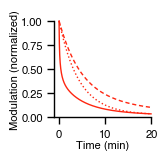

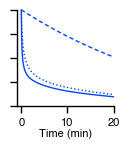

In [1759]:
# ########### ON CELL
d = 'ON_learning_model_timecourse'

t_ = np.asarray(dfs['time_model']['time'].to_list())
on = np.asarray(dfs['ON_alone'][0].to_list())
on_mg = np.asarray(dfs['ON_wo_recurr'][0].to_list())
on_mg_mg = np.asarray(dfs['ON_with_recurr'][0].to_list())

plt.figure(figsize=(1.25,1.25))
ax = plt.gca()
ax.plot(t_,on,color='#FE2712', clip_on=False,linewidth = 1, dashes = [3,2])
ax.plot(t_,on_mg,color='#FE2712', clip_on=False, linewidth = 1, linestyle = 'dotted')
ax.plot(t_,on_mg_mg,color='#FE2712', clip_on=False, linewidth = 1)
ax.set_xlim(-1,20)
ax.set_xticks([0,10,20])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylim(0,1)
ax.set_ylabel('Modulation (normalized)') # this needs to match diff between ylims
# ax.set_yticklabels('')
ax.set_xlabel('Time (min)')

plt.savefig(f'{svg_path}{d}_linestyle.svg', format='svg', transparent=True)

# ########### OFF CELL
d = 'OFF_learning_model_timecourse'

t_ = np.asarray(dfs['time_model']['time'].to_list())
on = np.asarray(dfs['OFF_alone'][0].to_list())
on_mg = np.asarray(dfs['OFF_wo_recurr'][0].to_list())
on_mg_mg = np.asarray(dfs['OFF_with_recurr'][0].to_list())

plt.figure(figsize=(1.25,1.25))
ax = plt.gca()
ax.plot(t_,on,color='#0247FE', clip_on=False,linewidth = 1, dashes = [3,2])
ax.plot(t_,on_mg,color='#0247FE', clip_on=False, linewidth = 1, linestyle = 'dotted')
ax.plot(t_,on_mg_mg,color='#0247FE', clip_on=False, linewidth = 1)
ax.set_xlim(-1,20)
ax.set_xticks([0,10,20])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylim(0,1)
ax.set_ylabel('') # this needs to match diff between ylims
ax.set_yticklabels('')
ax.set_xlabel('Time (min)')

plt.savefig(f'{svg_path}{d}_linestyle.svg', format='svg', transparent=True)

## Figure 6S 

In [1436]:
svg_path = '/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/ms/revision_stage/svg/S6/'

### model

In [1296]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/figS6/data_fig_6S_model.mat')

view_mat_file(data_mat_path)

dfs = {}

# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    recursively_load(dfs,f['data_for_krista_6S_model_progress'])

print(dfs.keys())

# Transpose all DataFrames in the dictionary
for key in dfs:
    if len(dfs[key].columns)>1:
        dfs[key] = dfs[key].transpose()

dfs['time_model'] = dfs['time_model'].rename(columns={0: 'time'})


Top-level keys: ['#refs#', 'data_for_krista_6S_model_progress']

Key: #refs#
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['a']

Key: data_for_krista_6S_model_progress
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['OFF_neg_img_needed', 'OFF_neg_img_network_only', 'OFF_neg_img_network_only_infinty', 'OFF_neg_img_network_plus_self', 'OFF_neg_img_network_plus_self_infinty', 'OFF_pair', 'OFF_pair_mV', 'OFF_recovery', 'ON_neg_img_needed', 'ON_neg_img_network_only', 'ON_neg_img_network_only_infinty', 'ON_neg_img_network_plus_self', 'ON_neg_img_network_plus_self_infinty', 'ON_recovery', 'mgM_pair', 'mgM_recovery', 'mgM_recovery_no_recurr', 'mgP_recovery', 'mgP_simple_pair', 'no_recurr_mgM_recovery', 'time_model', 'v_OFF_alone', 'v_OFF_initial', 'v_OFF_w_mg_with_recur', 'v_OFF_w_mg_wo_recur', 'v_ON_alone', 'v_ON_initial', 'v_ON_w_mg_with_recur', 'v_ON_w_mg_wo_recur']
dict_keys(['OFF_neg_img_needed', 'OFF_neg_img_network_only', 'OFF_neg_img_networ

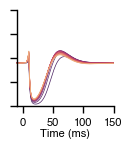

In [1268]:
########### MODEL
d = 'OFF_pair'
df_toplot = pd.concat([dfs['time_model'], dfs[d]], axis=1)

df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)

plt.figure(figsize=(1.25,1.25))#0.75))
ax = plt.gca()
sns.lineplot(data = df_toplot,x = 'time', y = 'rate', hue = 'condition',ax = ax, linewidth = 0.5,clip_on=False,legend = False,palette = cmap_dict['colorful'])
# ax.fill_between(t_data,avg_data+ sem_data,avg_data- sem_data,alpha = 0.2,color='black',zorder = 3,linewidth=0,clip_on=False)
# ax.plot(t_data,avg_data,color='black', linewidth = 0.5,clip_on=False,zorder = 3)
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
ax.set_ylim(0,40)
ax.set_yticks([0,10,20,30,40])
ax.set_ylabel('') # this needs to match diff between ylims
ax.set_yticklabels('')
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_color.svg', format='svg', transparent=True)

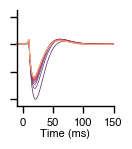

In [1269]:
########### MODEL
d = 'OFF_pair_mV'
df_toplot = pd.concat([dfs['time_model'], dfs[d]], axis=1)

df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)

plt.figure(figsize=(1.25,1.25))#0.75))
ax = plt.gca()
sns.lineplot(data = df_toplot,x = 'time', y = 'rate', hue = 'condition',ax = ax, linewidth = 0.5,clip_on=False,legend = False,palette = cmap_dict['colorful'])
# ax.fill_between(t_data,avg_data+ sem_data,avg_data- sem_data,alpha = 0.2,color='black',zorder = 3,linewidth=0,clip_on=False)
# ax.plot(t_data,avg_data,color='black', linewidth = 0.5,clip_on=False,zorder = 3)
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
ax.set_ylim(-2.25,1.25)
ax.set_ylabel('') # this needs to match diff between ylims
ax.set_yticklabels('')
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_color.svg', format='svg', transparent=True)

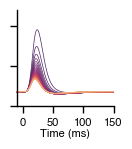

In [1270]:
plt.figure(figsize=(1.25,1.25))#0.75))
ax = plt.gca()

# d = 'OFF_pair'
# df_toplot = pd.concat([dfs['time_model'], dfs[d][12]], axis=1)
# df_toplot = df_toplot.melt(
#     id_vars='time',
#     var_name='condition',
#     value_name='rate'
# )
# sns.lineplot(data = df_toplot,x = 'time', y = 'rate', ax = ax, linewidth = 0.5,clip_on=False,legend = False,color='black',zorder=3,err_kws={'linewidth': 0})

d = 'OFF_recovery'
df_toplot = pd.concat([dfs['time_model'], dfs[d]], axis=1)

df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)
sns.lineplot(data = df_toplot,x = 'time', y = 'rate', hue = 'condition',ax = ax, linewidth = 0.5,clip_on=False,legend = False,palette = cmap_dict['colorful'])
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
ax.set_ylim(0,120)
ax.set_ylabel('') # this needs to match diff between ylims
ax.set_yticklabels('')
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_color.svg', format='svg', transparent=True)

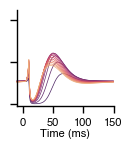

In [1271]:
########### MODEL
d = 'mgM_pair'
df_toplot = pd.concat([dfs['time_model'], dfs[d]], axis=1)

df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)

plt.figure(figsize=(1.25,1.25))#0.75))
ax = plt.gca()
sns.lineplot(data = df_toplot,x = 'time', y = 'rate', hue = 'condition',ax = ax, linewidth = 0.5,clip_on=False,legend = False,palette = cmap_dict['colorful'])
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
ax.set_ylim(-0.1,4.5)
ax.set_ylabel('') # this needs to match diff between ylims
ax.set_yticklabels('')
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_color.svg', format='svg', transparent=True)

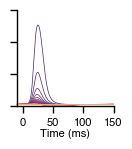

In [1292]:
########### MODEL
d = 'mgM_recovery'
df_toplot = pd.concat([dfs['time_model'], dfs[d]], axis=1)

df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)

plt.figure(figsize=(1.25,1.25))#0.75))
ax = plt.gca()
sns.lineplot(data = df_toplot,x = 'time', y = 'rate', hue = 'condition',ax = ax, linewidth = 0.5,clip_on=False,legend = False,palette = cmap_dict['colorful'])
# ax.plot(dfs['time_model']['time'],dfs['no_recurr_mgM_recovery'][0],color='red',linewidth=0.5)
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
ax.set_ylim(-0.1,60)
ax.set_ylabel('') # this needs to match diff between ylims
ax.set_yticklabels('')
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_color.svg', format='svg', transparent=True)

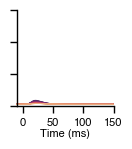

In [1293]:
########### MODEL
d = 'mgM_recovery_no_recurr'
df_toplot = pd.concat([dfs['time_model'], dfs[d]], axis=1)

df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)

plt.figure(figsize=(1.25,1.25))#0.75))
ax = plt.gca()
sns.lineplot(data = df_toplot,x = 'time', y = 'rate', hue = 'condition',ax = ax, linewidth = 0.5,clip_on=False,legend = False,palette = cmap_dict['colorful'])
# ax.plot(dfs['time_model']['time'],dfs['no_recurr_mgM_recovery'][0],color='red',linewidth=0.5)
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
ax.set_ylim(-0.1,60)
ax.set_ylabel('') # this needs to match diff between ylims
ax.set_yticklabels('')
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_color.svg', format='svg', transparent=True)

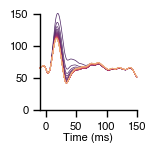

In [1298]:
########### MODEL
d = 'mgP_simple_pair'
df_toplot = pd.concat([dfs['time_model'], dfs[d]], axis=1)

df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)
# df_toplot['rate'] = df_toplot['rate']-60
# df_toplot['rate'] = df_toplot['rate']*2

plt.figure(figsize=(1.25,1.25))#0.75))
ax = plt.gca()
sns.lineplot(data = df_toplot,x = 'time', y = 'rate', hue = 'condition',ax = ax, linewidth = 0.5,clip_on=False,legend = False,palette = cmap_dict['colorful'])
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
ax.set_ylim(-0.1,150)
# ax.set_yticks([0,10,20])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylabel('') 
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_color.svg', format='svg', transparent=True)

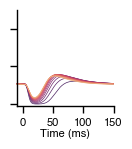

In [1282]:
########### MODEL
d = 'mgP_recovery'
df_toplot = pd.concat([dfs['time_model'], dfs[d]], axis=1)

df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)

plt.figure(figsize=(1.25,1.25))#0.75))
ax = plt.gca()
sns.lineplot(data = df_toplot,x = 'time', y = 'rate', hue = 'condition',ax = ax, linewidth = 0.5,clip_on=False,legend = False,palette = cmap_dict['colorful'])
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
ax.set_ylim(-0.1,5)
# ax.set_yticks([0,10,20])
ax.set_ylabel('') # this needs to match diff between ylims
ax.set_yticklabels('')
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_color.svg', format='svg', transparent=True)

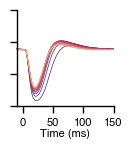

In [1283]:
plt.figure(figsize=(1.25,1.25))#0.75))
ax = plt.gca()

d = 'ON_recovery'
df_toplot = pd.concat([dfs['time_model'], dfs[d]], axis=1)

df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)
sns.lineplot(data = df_toplot,x = 'time', y = 'rate', hue = 'condition',ax = ax, linewidth = 0.5,clip_on=False,legend = False,palette = cmap_dict['colorful'])
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
ax.set_ylim(-0.1,30)
# ax.set_yticks([0,10,20])
ax.set_ylabel('') # this needs to match diff between ylims
ax.set_yticklabels('')
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_color.svg', format='svg', transparent=True)

### data

In [1434]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/figS6/data_fig_6S_data.mat')

view_mat_file(data_mat_path)

dfs = {}

# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    recursively_load(dfs,f['data_for_krista_6S_data_progress'])

print(dfs.keys())

# Transpose all DataFrames in the dictionary
for key in dfs:
    if len(dfs[key].columns)>1:
        dfs[key] = dfs[key].transpose()

dfs['time_data'] = dfs['time_data'].rename(columns={0: 'time'})


Top-level keys: ['#refs#', 'data_for_krista_6S_data_progress']

Key: #refs#
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['a']

Key: data_for_krista_6S_data_progress
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['OFF_baseline', 'OFF_pair', 'OFF_pair_mV', 'OFF_recovery', 'OFF_vm_baseline', 'ON_recovery', 'ON_simple_ratio', 'mgM_baseline', 'mgM_pair', 'mgM_recovery', 'mgP_recovery', 'mgP_simple_baseline', 'mgP_simple_pair', 'mgP_simple_pair_subtracted', 'mg_broad_ratio', 'time_data']
dict_keys(['OFF_baseline', 'OFF_pair', 'OFF_pair_mV', 'OFF_recovery', 'OFF_vm_baseline', 'ON_recovery', 'ON_simple_ratio', 'mgM_baseline', 'mgM_pair', 'mgM_recovery', 'mgP_recovery', 'mgP_simple_baseline', 'mgP_simple_pair', 'mgP_simple_pair_subtracted', 'mg_broad_ratio', 'time_data'])


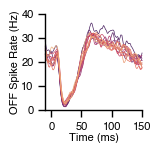

In [1285]:

plt.figure(figsize=(1.25,1.25))#0.75))
ax = plt.gca()
########### 

# d = 'OFF_baseline'
# df_toplot = pd.concat([dfs['time_data'], dfs[d]], axis=1)
# df_toplot = df_toplot.melt(
#     id_vars='time',
#     var_name='condition',
#     value_name='rate'
# )
# sns.lineplot(data = df_toplot,x = 'time', y = 'rate', ax = ax, linewidth = 0.5,clip_on=False,errorbar = 'se',legend = False,color='black',err_kws={'linewidth': 0})

d = 'OFF_pair'
df_toplot = pd.concat([dfs['time_data'], dfs[d]], axis=1)
df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)
sns.lineplot(data = df_toplot,x = 'time', y = 'rate', hue = 'condition',ax = ax, linewidth = 0.5,clip_on=False,legend = False,palette = cmap_dict['colorful'])

# ax.plot(dfs['time_data']['time'],dfs['OFF_baseline'].mean(axis=1),color='black',linewidth=0.5,zorder=0)
# ax.fill_between(t_data,avg_data+ sem_data,avg_data- sem_data,alpha = 0.2,color='black',zorder = 3,linewidth=0,clip_on=False)
# ax.plot(t_data,avg_data,color='black', linewidth = 0.5,clip_on=False,zorder = 3)
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
ax.set_ylim(0,40)
ax.set_yticks([0,10,20,30,40])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylabel('OFF Spike Rate (Hz)') 
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_data_color.svg', format='svg', transparent=True)

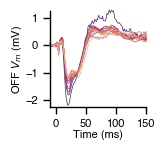

In [1286]:
plt.figure(figsize=(1.25,1.25))#0.75))
ax = plt.gca()

# d = 'OFF_vm_baseline'
# df_toplot = pd.concat([dfs['time_data'], dfs[d]], axis=1)
# df_toplot = df_toplot.melt(
#     id_vars='time',
#     var_name='condition',
#     value_name='rate'
# )
# sns.lineplot(data = df_toplot,x = 'time', y = 'rate', ax = ax,errorbar = 'se', linewidth = 0.5,clip_on=False,legend = False,color='black',err_kws={'linewidth': 0})

d = 'OFF_pair_mV'
df_toplot = pd.concat([dfs['time_data'], dfs[d]], axis=1)
df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)
sns.lineplot(data = df_toplot,x = 'time', y = 'rate', hue = 'condition',ax = ax, linewidth = 0.5,clip_on=False,legend = False,palette = cmap_dict['colorful'])

ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
ax.set_ylim(-2.25,1.25)
# ax.set_yticks([0,10,20])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylabel('OFF $V_m$ (mV)') 
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_data_color.svg', format='svg', transparent=True)

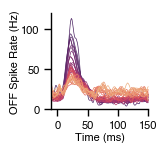

In [1287]:
plt.figure(figsize=(1.25,1.25))#0.75))
ax = plt.gca()

d = 'OFF_recovery'
df_toplot = pd.concat([dfs['time_data'], dfs[d]], axis=1)

df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)
sns.lineplot(data = df_toplot,x = 'time', y = 'rate', hue = 'condition',ax = ax, linewidth = 0.5,clip_on=False,legend = False,palette = cmap_dict['colorful'])
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
ax.set_ylim(0,120)
# ax.set_yticks([0,10,20])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylabel('OFF Spike Rate (Hz)') 
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_data_color.svg', format='svg', transparent=True)

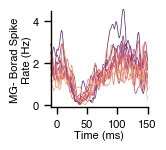

In [1288]:
plt.figure(figsize=(1.25,1.25))#0.75))
ax = plt.gca()

# d = 'mgM_baseline'
# df_toplot = pd.concat([dfs['time_data'], dfs[d]], axis=1)
# df_toplot = df_toplot.melt(
#     id_vars='time',
#     var_name='condition',
#     value_name='rate'
# )
# sns.lineplot(data = df_toplot,x = 'time', y = 'rate', ax = ax,errorbar='se', linewidth = 0.5,clip_on=False,legend = False,color='black',err_kws={'linewidth': 0})

d = 'mgM_pair'
df_toplot = pd.concat([dfs['time_data'], dfs[d]], axis=1)

df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)
sns.lineplot(data = df_toplot,x = 'time', y = 'rate', hue = 'condition',ax = ax, linewidth = 0.5,clip_on=False,legend = False,palette = cmap_dict['colorful'])
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
ax.set_ylim(-0.1,4.5)
# ax.set_yticks([0,10,20])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylabel('MG- Borad Spike\nRate (Hz)') 
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_data_color.svg', format='svg', transparent=True)

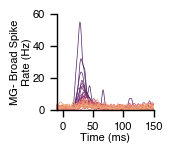

In [1290]:
plt.figure(figsize=(1.25,1.25))#0.75))
ax = plt.gca()

d = 'mgM_recovery'
df_toplot = pd.concat([dfs['time_data'], dfs[d]], axis=1)

df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)
sns.lineplot(data = df_toplot,x = 'time', y = 'rate', hue = 'condition',ax = ax, linewidth = 0.5,clip_on=False,legend = False,palette = cmap_dict['colorful'])
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
ax.set_ylim(-0.1,60)
# ax.set_yticks([0,10,20])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylabel('MG- Broad Spike\nRate (Hz)') 
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_data_color.svg', format='svg', transparent=True)

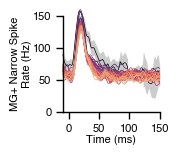

In [1437]:
plt.figure(figsize=(1.25,1.25))#0.75))
ax = plt.gca()

d = 'mgP_simple_baseline'
df_toplot = pd.concat([dfs['time_data'], dfs[d]], axis=1)
df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)
sns.lineplot(data = df_toplot,x = 'time', y = 'rate', ax = ax, errorbar='se',linewidth = 0.5,clip_on=False,legend = False,color='black',err_kws={'linewidth': 0})

d = 'mgP_simple_pair'
df_toplot = pd.concat([dfs['time_data'], dfs[d].transpose()], axis=1)

df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)
sns.lineplot(data = df_toplot,x = 'time', y = 'rate', hue = 'condition',ax = ax, linewidth = 0.5,clip_on=False,legend = False,palette = cmap_dict['colorful'])
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
ax.set_ylim(-0.1,150)
# ax.set_yticks([0,10,20])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylabel('MG+ Narrow Spike\nRate (Hz)') 
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_data_color.svg', format='svg', transparent=True)

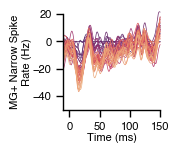

In [1301]:
########### MODEL
d = 'mgP_simple_pair_subtracted'
df_toplot = pd.concat([dfs['time_data'], dfs[d].transpose()], axis=1)

df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)

plt.figure(figsize=(1.25,1.25))#0.75))
ax = plt.gca()
sns.lineplot(data = df_toplot,x = 'time', y = 'rate', hue = 'condition',ax = ax, linewidth = 0.5,clip_on=False,legend = False,palette = cmap_dict['colorful'])
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
ax.set_ylim(-50,20)
ax.set_yticks([20,0,-20,-40])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylabel('MG+ Narrow Spike\nRate (Hz)') 
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_data_color.svg', format='svg', transparent=True)

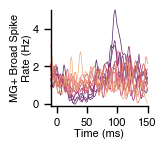

In [1302]:
plt.figure(figsize=(1.25,1.25))#0.75))
ax = plt.gca()

d = 'mgP_recovery'
df_toplot = pd.concat([dfs['time_data'], dfs[d]], axis=1)

df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)
sns.lineplot(data = df_toplot,x = 'time', y = 'rate', hue = 'condition',ax = ax, linewidth = 0.5,clip_on=False,legend = False,palette = cmap_dict['colorful'])
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
ax.set_ylim(-0.1,5)
# ax.set_yticks([0,10,20])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylabel('MG+ Broad Spike\nRate (Hz)') 
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_data_color.svg', format='svg', transparent=True)

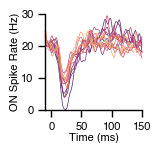

In [1303]:
plt.figure(figsize=(1.25,1.25))#0.75))
ax = plt.gca()

d = 'ON_recovery'
df_toplot = pd.concat([dfs['time_data'], dfs[d]], axis=1)

df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)
sns.lineplot(data = df_toplot,x = 'time', y = 'rate', hue = 'condition',ax = ax, linewidth = 0.5,clip_on=False,legend = False,palette = cmap_dict['colorful'])
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
ax.set_ylim(-0.1,30)
# ax.set_yticks([0,10,20])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylabel('ON Spike Rate (Hz)') 
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_data_color.svg', format='svg', transparent=True)

## Figure 7

For all the model traces there is a variable: data_fig7_for_krista.model_time
which gives the time in ms. it starts at -10ms till 150ms with a dt of 1ms.   

for Nate's data use the time vector in the MG data (multiply by 1k to turn it into ms) - it's the same as the model.  

For the output data the variable "data_fig7_for_krista.nate_data_output_time" gives the time. it's from -5 till 150 with a 1ms dt.

In [1505]:
svg_path = '/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/ms/revision_stage/svg/Fig7/'

### a

In [1354]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/fig7/data_fig_7a.mat')

In [1356]:
view_mat_file(data_mat_path)

dfs = {}

# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    dfs = recursively_load(dfs,f['data_for_krista_figure_7a'])

print(dfs.keys())

# # Transpose all DataFrames in the dictionary
# for key in dfs:
#     dfs[key] = dfs[key].transpose()

df_self = pd.DataFrame({
    't': np.arange(0,160,1),
    'self': dfs['model_diagram_self'].transpose()[0].to_list()
})

df_input = dfs['model_diagram_noise'].add(dfs['model_diagram_self'].transpose()[0],axis=0)

df_toplot = pd.concat([df_self,df_input],axis=1)

df_long = df_toplot.melt(id_vars='t', var_name='condition', value_name='mV')

Top-level keys: ['#refs#', 'data_for_krista_figure_7a']

Key: #refs#
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['a']

Key: data_for_krista_figure_7a
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['model_diagram_noise', 'model_diagram_self']
dict_keys(['model_diagram_noise', 'model_diagram_self'])


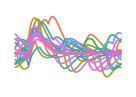

In [1338]:
plt.figure(figsize=(1.5,1))
ax = plt.gca()
mask = ~df_long['condition'].isin(['t', 'self'])
sns.lineplot(df_long[mask],x='t',y='mV',hue = 'condition',palette = sns.color_palette("husl", 20),legend=False)
# sns.lineplot(df_long[~mask],x='t',y='mV',color='black',legend=False)
sns.despine(bottom=True,left=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim([-4,5]);
# ax.set_xlim([0,120]);
plt.savefig(f'{svg_path}model_pairing.svg', format='svg', transparent=True)

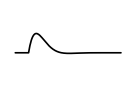

In [1339]:
plt.figure(figsize=(1.5,1))
ax = plt.gca()
mask = df_long['condition'].isin(['t', 'self'])
sns.lineplot(df_long[mask],x='t',y='mV',color='black',legend=False)
# sns.lineplot(df_long[~mask],x='t',y='mV',color='black',legend=False)
sns.despine(bottom=True,left=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim([-4,5]);
# ax.set_xlim([0,120]);
plt.savefig(f'{svg_path}model_self.svg', format='svg', transparent=True)

### b

In [1500]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/data_gc.mat')
view_mat_file(data_mat_path)

dfs = {}

# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    dfs = recursively_load(dfs,f['data_gc'])

print(dfs.keys())

# Transpose all DataFrames in the dictionary
for key in dfs:
    dfs[key] = dfs[key].transpose()

gc_time = dfs['time'].transpose()
gc_sum = dfs['gc_epsp'].sum(axis=1)

Top-level keys: ['#refs#', 'data_gc']

Key: #refs#
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['a']

Key: data_gc
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['gc_epsp', 'gc_rate', 'time']
dict_keys(['gc_epsp', 'gc_rate', 'time'])


In [1501]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/fig7/data_fig_7e.mat')

view_mat_file(data_mat_path)

dfs = {}
# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    dfs = recursively_load(dfs,f['data_for_krista_figure_7e'])

print(dfs.keys())

# Transpose all DataFrames in the dictionary
for key in dfs:
    dfs[key] = dfs[key].transpose()

Top-level keys: ['#refs#', 'data_for_krista_figure_7e']

Key: #refs#
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['a']

Key: data_for_krista_figure_7e
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['model_off_post', 'model_on_post', 'model_time', 'nate_data_off_avg', 'nate_data_off_sem', 'nate_data_on_avg', 'nate_data_on_sem', 'nate_data_output_time']
dict_keys(['model_off_post', 'model_on_post', 'model_time', 'nate_data_off_avg', 'nate_data_off_sem', 'nate_data_on_avg', 'nate_data_on_sem', 'nate_data_output_time'])


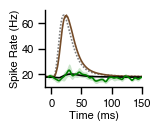

In [1506]:
t_data = np.asarray(dfs['nate_data_output_time'].transpose()[0].to_list())
avg_data = np.asarray(dfs['nate_data_on_avg'].transpose()[0].to_list())
sem_data = np.asarray(dfs['nate_data_on_sem'].transpose()[0].to_list())
t_model = np.asarray(dfs['model_time'].transpose()[0].to_list())
avg_model_mg = np.asarray(dfs['model_on_post'][1].to_list())
avg_model_mg_out = np.asarray(dfs['model_on_post'][0].to_list())

mg_min = np.min(avg_model_mg)
mg_max = np.max(avg_model_mg) - mg_min

norm_gc = gc_sum - np.min(gc_sum)
norm_gc = norm_gc/np.max(norm_gc)
norm_gc = (norm_gc * mg_max) + mg_min

hfig = plt.figure(figsize=(1.25,1))
ax = plt.gca()
ax.plot(gc_time,norm_gc,color='gray',dashes = [1,1])
ax.plot(t_model,avg_model_mg,color='#754C29')
ax.plot(t_model,avg_model_mg_out,color='black')
ax.fill_between(t_data,avg_data+ sem_data,avg_data- sem_data,alpha = 0.2,color='green',linewidth=0,zorder = 0)
ax.plot(t_data,avg_data,color='green')
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
ax.set_ylim(10,70)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Spike Rate (Hz)')
plt.savefig(f'{svg_path}ON_neg_image_conditions.svg', format='svg', transparent=True)

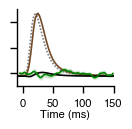

In [1507]:
t_data = np.asarray(dfs['nate_data_output_time'].transpose()[0].to_list())
avg_data = np.asarray(dfs['nate_data_off_avg'].transpose()[0].to_list())
sem_data = np.asarray(dfs['nate_data_off_sem'].transpose()[0].to_list())
t_model = np.asarray(dfs['model_time'].transpose()[0].to_list())
avg_model_mg = np.asarray(dfs['model_off_post'][1].to_list())
avg_model_mg_out = np.asarray(dfs['model_off_post'][0].to_list())

hfig = plt.figure(figsize=(1.25,1))
ax = plt.gca()
ax.plot(gc_time,norm_gc,color='gray',dashes = [1,1])
ax.plot(t_model,avg_model_mg,color='#754C29')
ax.plot(t_model,avg_model_mg_out,color='black')
ax.fill_between(t_data,avg_data+ sem_data,avg_data- sem_data,alpha = 0.2,color='green',linewidth=0,zorder = 0)
ax.plot(t_data,avg_data,color='green')
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
ax.set_ylim(10,70)
ax.set_yticklabels('')
ax.set_ylabel('') # this needs to match diff between ylims
ax.set_xlabel('Time (ms)')
plt.savefig(f'{svg_path}OFF_neg_image_conditions.svg', format='svg', transparent=True)

### c

In [1486]:
pal = sns.color_palette("flare_r", n_colors=4)

In [1344]:
# n_colors=4
# cmap_dict_7b = {
#     'MGm':sns.blend_palette(['#00CBFF','#004D63'], n_colors= n_colors),#sns.color_palette(f"ch:s=2.7,rot=0,hue=1,dark={dark}, light={light}", n_colors= n_colors),#, as_cmap=True),#
#     'MGp':sns.blend_palette(['#FB9902','#633C01'], n_colors= n_colors),#,as_cmap=True),#
# #sns.color_palette(f"ch:s=1.2,rot=0,hue=1,dark={dark}, light={light}",as_cmap=True),#
#     'ON':sns.blend_palette(['#FE2712','#630803'], n_colors= n_colors),#,as_cmap=True),#
#     'OFF':sns.blend_palette(['#0247FE','#001663'], n_colors= n_colors),#,as_cmap=True),#
# }

In [1487]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/fig7/data_fig_7c.mat')

view_mat_file(data_mat_path)

dfs = {}
# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    # print(f['data_for_krista_figure_7c'].keys())
    dfs = recursively_load(dfs,f['data_for_krista_figure_7c'])

# Transpose all DataFrames in the dictionary
for key in dfs.keys():
    dfs[key] = dfs[key].transpose()

Top-level keys: ['#refs#', 'data_for_krista_figure_7c']

Key: #refs#
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['a']

Key: data_for_krista_figure_7c
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['model_MGm_progression', 'model_MGp_progression', 'model_time', 'nate_data_MGm', 'nate_data_MGp']


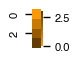

In [1467]:

data = np.asarray([0,1,2,3]).reshape(-1, 1)
# 3. create the figure
fig, ax = plt.subplots(figsize=(0.15,0.5))
sns.heatmap(data, cmap = cmap_dict['MGp'],ax = ax)
plt.savefig(f'{svg_path}colormap_cartoon_7c_p.svg', format='svg', transparent=True)

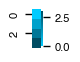

In [1468]:

data = np.asarray([0,1,2,3]).reshape(-1, 1)
# 3. create the figure
fig, ax = plt.subplots(figsize=(0.15,0.5))
sns.heatmap(data, cmap = cmap_dict['MGm'],ax = ax)
plt.savefig(f'{svg_path}colormap_cartoon_7c_m.svg', format='svg', transparent=True)

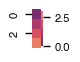

In [1488]:

data = np.asarray([0,1,2,3]).reshape(-1, 1)
# 3. create the figure
fig, ax = plt.subplots(figsize=(0.15,0.5))
sns.heatmap(data, cmap = pal,ax = ax)
plt.savefig(f'{svg_path}colormap_cartoon_7c_colorful.svg', format='svg', transparent=True)

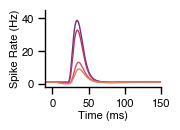

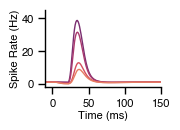

In [1490]:
# cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
for l,d in {'MGm':'model_MGm_progression','MGp':'model_MGp_progression'}.items():
    df = deepcopy(dfs[d])
    
    # Add a column for the row index (optional, usually x-axis)
    df['row'] = df.index
    df.rename(columns = {0:10,1:30,2:300,3:600},inplace=True)
    df['t'] = dfs['model_time'].transpose()[0].to_list() #df_long['row']*0.001*1000 - 10
    
    # Melt the DataFrame: columns become 'variable', values become 'value'
    df_long = df.melt(id_vars=['row','t'], var_name='param', value_name='Hz')
    
    
    plt.figure(figsize=(1.5,1))
    ax = plt.gca()
    sns.lineplot(data = df_long,x = 't', y = 'Hz', hue = 'param',ax = ax, legend = False,linewidth=1,palette = pal)#cmap_dict[l])
    ax.set_xlim(-10,150)
    ax.set_ylim(-2,45)
    ax.set_xticks([0,50,100,150])
    ax.set_ylabel('Spike Rate (Hz)')  # this needs to match diff between ylims
    # ax.set_yticks([])
    ax.set_xlabel('Time (ms)')

    plt.savefig(f'{svg_path}{d}_color.svg', format='svg', transparent=True)

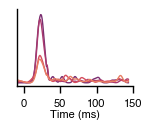

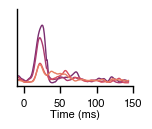

In [1492]:

# List of dfs to combine
keys_to_combine_dict = {'MGm':[
    'nate_data_MGm_mg10_avg', 
    'nate_data_MGm_mg300_avg', 
    'nate_data_MGm_mg30_avg', 
    'nate_data_MGm_mg600_avg'
],'MGp':[
    'nate_data_MGp_mg10_avg', 
    'nate_data_MGp_mg300_avg', 
    'nate_data_MGp_mg30_avg', 
    'nate_data_MGp_mg600_avg'
]}
for l,keys_to_combine in keys_to_combine_dict.items():
    combined_list = []
    
    for key in keys_to_combine:
        df = dfs[key].copy()
        df['row'] = df.index
        df.rename(columns={0:'t',1:'Hz'},inplace=True)
        df['t']= df['t']*1000
    
        # Extract number from key (10, 30, 300, 600) using regex
        match = re.search(r'mg(\d+)', key)
        if match:
            df['param'] = int(match.group(1))
    
        combined_list.append(df)
    
    # Concatenate all long-form DataFrames
    combined_df = pd.concat(combined_list, ignore_index=True)

    plt.figure(figsize=(1.5,1))
    ax = plt.gca()
    sns.lineplot(data = combined_df,x = 't', y = 'Hz', hue = 'param',linewidth=1,ax = ax, legend = False,palette = pal)#cmap_dict[l])
    ax.set_xlim(-10,150)
    ax.set_xticks([0,50,100,150])
    ax.set_ylim(-2,45)
    ax.set_ylabel('') # this needs to match diff between ylims
    ax.set_yticks([])
    ax.set_xlabel('Time (ms)')
    
    plt.savefig(f'{svg_path}{l}_data_rate_color.svg', format='svg', transparent=True)

### d and e

In [1364]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/fig7/data_fig_7d.mat')

view_mat_file(data_mat_path)

dfs = {}
# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    dfs = recursively_load(dfs,f['data_for_krista_figure_7d'])

print(dfs.keys())

# Transpose all DataFrames in the dictionary
for key in dfs:
    dfs[key] = dfs[key].transpose()

Top-level keys: ['#refs#', 'data_for_krista_figure_7d']

Key: #refs#
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['a']

Key: data_for_krista_figure_7d
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['OFF_gca_input', 'OFF_gca_input_std', 'OFF_rate', 'OFF_rate_mg_only', 'OFF_rate_std', 'OFF_rate_std_mg_only', 'OFF_vm', 'OFF_vm_std', 'ON_gca_input', 'ON_gca_input_std', 'ON_rate', 'ON_rate_mg_only', 'ON_rate_std', 'ON_rate_std_mg_only', 'ON_vm', 'ON_vm_std', 'baseline_op_firing_horizontal_dashed_line', 'mgM_input', 'mgM_input_std', 'mgP_input', 'mgP_input_std', 'time_min', 'transition_to_recovery_vertical_dashed_line']
dict_keys(['OFF_gca_input', 'OFF_gca_input_std', 'OFF_rate', 'OFF_rate_mg_only', 'OFF_rate_std', 'OFF_rate_std_mg_only', 'OFF_vm', 'OFF_vm_std', 'ON_gca_input', 'ON_gca_input_std', 'ON_rate', 'ON_rate_mg_only', 'ON_rate_std', 'ON_rate_std_mg_only', 'ON_vm', 'ON_vm_std', 'baseline_op_firing_horizontal_dashed_line', 'mgM_input', '

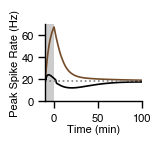

In [1367]:
t_ = np.asarray(dfs['time_min'].transpose()[0].to_list()) - dfs['transition_to_recovery_vertical_dashed_line'][0].values[0]
output_mg = np.mean( np.array([ np.asarray(dfs['OFF_rate'][0].to_list()), np.asarray(dfs['ON_rate'][0].to_list()) ]), axis=0 ) #- dfs['baseline_op_firingg_horizontal_dashed_line'][0].values[0]
mg = np.mean( np.array([ np.asarray(dfs['OFF_rate_mg_only'][0].to_list()), np.asarray(dfs['ON_rate_mg_only'][0].to_list())]), axis=0 ) #- dfs['baseline_op_firingg_horizontal_dashed_line'][0].values[0]

hfig = plt.figure(figsize=(1.25,1))
ax = plt.gca()
ax.plot(t_,mg,color='#754C29')
ax.plot(t_,output_mg,color='black')
ax.hlines(dfs['baseline_op_firing_horizontal_dashed_line'].values[0][0],t_[0],100,color = 'gray', linestyle='dotted')
# ax.vlines(0,10,70,color='gray',linewidth = 0.5,zorder=0)
# ax.vlines(4,10,65,color='gray',linewidth = 0.5,linestyle='dashed',zorder=0)
ax.fill_between([t_[0],0],[0,0],[70,70],alpha=0.2,color='black',zorder=0,linewidth=0)
ax.set_yticks([0,20,40,60])
ax.set_xticks([0,50,100])
ax.set_ylim(-0.1,70)
ax.set_xlim(t_[0],100)
# sns.despine(offset={'left':2})
ax.set_xlabel('Time (min)')
ax.set_ylabel('Peak Spike Rate (Hz)')
plt.savefig(f'{svg_path}Output_recovery_spks_manip.svg', format='svg', transparent=True)

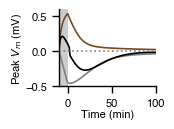

In [1368]:
gca_input = np.mean(np.array([dfs['ON_gca_input'],dfs['OFF_gca_input']]),axis=0)
mg_input = np.mean(np.array([dfs['mgM_input'],dfs['mgP_input']]),axis=0)
output_vm = np.mean(np.array([dfs['ON_vm'],dfs['OFF_vm']]),axis=0)


hfig = plt.figure(figsize=(1.25,1))
ax = plt.gca()
ax.plot(t_,gca_input,color='gray')
ax.plot(t_,mg_input,color='#754C29')
ax.plot(t_,output_vm,color='black')
ax.hlines(0,t_[0],100,color = 'gray', linestyle='dotted')
# ax.vlines(0,-0.5,0.5,color='gray',linewidth = 0.5,zorder=0)
# ax.vlines(4,-0.5,0.5,color='gray',linewidth = 0.5,linestyle='dashed',zorder=0)
ax.fill_between([t_[0],0],[-0.6,-0.6],[0.6,0.6],alpha=0.2,color='black',zorder=0,linewidth=0)
ax.set_xticks([0,50,100])
ax.set_ylim(-0.5,0.6)
ax.set_xlim(t_[0],100)
# sns.despine(offset={'left':2})
ax.set_xlabel('Time (min)')
ax.set_ylabel('Peak $V_m$ (mV)')

plt.savefig(f'{svg_path}Output_recovery_VM_manip.svg', format='svg', transparent=True)

### f

In [558]:
pal = sns.blend_palette(('Gray','#754C29'),n_colors=11)
pal

[(0.5019607843137255, 0.5019607843137255, 0.5019607843137255),
 (0.49773164167627837, 0.4819684736639754, 0.46851211072664356),
 (0.49333333333333335, 0.4611764705882353, 0.4337254901960784),
 (0.4891041906958862, 0.4411841599384852, 0.4002768166089965),
 (0.48470588235294115, 0.4203921568627451, 0.36549019607843136),
 (0.48030757400999613, 0.399600153787005, 0.3307035755478662),
 (0.476078431372549, 0.37960784313725493, 0.2972549019607843),
 (0.471680123029604, 0.3588158400615148, 0.26246828143021916),
 (0.4674509803921568, 0.3388235294117647, 0.22901960784313724),
 (0.4630526720492118, 0.3180315263360246, 0.19423298731257205),
 (0.4588235294117647, 0.2980392156862745, 0.1607843137254902)]

In [1431]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/fig7/data_fig_7f.mat')
view_mat_file(data_mat_path)

dfs = {}
# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    dfs = recursively_load(dfs,f['data_for_krista_figure_7f'])
print(dfs.keys())

dfs['time_model'] = dfs['time_model'].rename(columns={0: 'time'})

Top-level keys: ['#refs#', 'data_for_krista_figure_7f']

Key: #refs#
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['a']

Key: data_for_krista_figure_7f
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['bars_two_sided_echo_all_w_OFF', 'bars_two_sided_echo_all_w_ON', 'rate_all_OFF', 'rate_all_ON', 'time_model']
dict_keys(['bars_two_sided_echo_all_w_OFF', 'bars_two_sided_echo_all_w_ON', 'rate_all_OFF', 'rate_all_ON', 'time_model'])


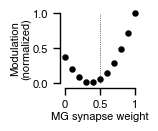

In [1433]:
hfig = plt.figure(figsize=(1,1))
ax = plt.gca()
# sns.pointplot(dfs['bars_two_sided_echo_all_w_OFF'],palette=pal,ax=ax)
# sns.pointplot(dfs['bars_two_sided_echo_all_w_ON'],palette=pal,ax=ax)
df_output = pd.concat([dfs['bars_two_sided_echo_all_w_ON'],dfs['bars_two_sided_echo_all_w_OFF']],ignore_index=True)
sns.pointplot(df_output,markersize = 3,errorbar = None,ax=ax,color='black',linestyle='none') #palette=pal,
ax.vlines(5,0,1,color='black',linewidth=0.5, linestyle='dotted',zorder=0)
ax.set_xticks([0,5,10])
ax.set_xticklabels([0,0.5,1]);
sns.despine(offset=1,trim=True)
ax.set_xlabel('MG synapse weight')
ax.set_ylabel('Modulation\n(normalized)')
plt.savefig(f'{svg_path}Output_Modulation_MGweight.svg', format='svg', transparent=True)

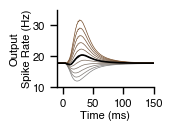

In [2093]:
pd.concat([dfs['rate_all_ON'].transpose(), dfs['rate_all_OFF'].transpose()])
df_output = df.groupby(df.index).mean()

df_toplot = pd.concat([dfs['time_model'], df_output], axis=1)
df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)

hfig = plt.figure(figsize=(1.25,1))
ax = plt.gca()
sns.lineplot(data = df_toplot,y = 'rate',x = 'time',hue='condition',linewidth=0.5, palette = pal,legend=False)
sns.lineplot(data = df_toplot[df_toplot['condition'].isin([5])],y = 'rate',x = 'time',color='black',legend=False)
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
ax.set_ylim(10,35)
ax.set_yticks([10,20,30])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylabel('Output\nSpike Rate (Hz)') # this needs to match diff between ylims
# ax.set_yticklabels('')
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}Output_SpikeRate_MGweight.svg', format='svg', transparent=True)

### g

In [1379]:
pal = sns.blend_palette(('Gray','black'),n_colors=11)

In [1376]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/fig7/data_fig_7g.mat')
view_mat_file(data_mat_path)

dfs = {}
# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    dfs = recursively_load(dfs,f['data_for_krista_figure_7g'])

print(dfs.keys())

dfs['time_model'] = dfs['time_model'].rename(columns={0: 'time'})


Top-level keys: ['#refs#', 'data_for_krista_figure_7g']

Key: #refs#
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['a']

Key: data_for_krista_figure_7g
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['bars_two_sided_echo_all_lr_OFF', 'bars_two_sided_echo_all_lr_ON', 'rate_all_lr_OFF', 'rate_all_lr_ON', 'time_model', 'x_label_params_all']
dict_keys(['bars_two_sided_echo_all_lr_OFF', 'bars_two_sided_echo_all_lr_ON', 'rate_all_lr_OFF', 'rate_all_lr_ON', 'time_model', 'x_label_params_all'])


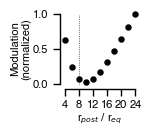

In [1381]:
hfig = plt.figure(figsize=(1,1))
ax = plt.gca()
# sns.pointplot(dfs['bars_two_sided_echo_all_w_OFF'],palette=pal,ax=ax)
# sns.pointplot(dfs['bars_two_sided_echo_all_w_ON'],palette=pal,ax=ax)
df_output = pd.concat([dfs['bars_two_sided_echo_all_lr_ON'],dfs['bars_two_sided_echo_all_lr_OFF']],ignore_index=True)
sns.pointplot(df_output,color='black',markersize = 3,errorbar = None,ax=ax,linestyle='none') #"RdYlBu"
ax.vlines(2,0,1,color='black',linewidth=0.5, linestyle='dotted',zorder=0)
ax.set_xticks([0,2,4,6,8,10])
ax.set_xticklabels([4,8,12,16,20,24]);
sns.despine(offset=1,trim=True)
ax.set_xlabel('r$_{post}$ / r$_{eq}$')
ax.set_ylabel('Modulation\n(normalized)')
plt.savefig(f'{svg_path}Output_Modulation_OutputStimSensitivity.svg', format='svg', transparent=True)

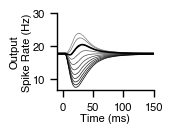

In [1380]:

df = pd.concat([dfs['rate_all_lr_ON'].transpose(), dfs['rate_all_lr_OFF'].transpose()])
df_output = df.groupby(df.index).mean()

df_toplot = pd.concat([dfs['time_model'], df_output], axis=1)
df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)



hfig = plt.figure(figsize=(1.25,1))
ax = plt.gca()
sns.lineplot(data = df_toplot,y = 'rate',x = 'time',hue='condition',linewidth=0.5, palette = pal,legend=False)
sns.lineplot(data = df_toplot[df_toplot['condition'].isin([2])],y = 'rate',x = 'time',color='black',legend=False)
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
# ax.set_ylim(10,35)
ax.set_yticks([10,20,30])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylabel('Output\nSpike Rate (Hz)') # this needs to match diff between ylims
# ax.set_yticklabels('')
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}Output_SpikeRate_OutputStimSensitivity.svg', format='svg', transparent=True)

## Figure 7S

In [1493]:
svg_path = '/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/ms/revision_stage/svg/S7/'

### b and c

In [1409]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/figS7/data_fig_7Sa.mat')

view_mat_file(data_mat_path)

dfs = {}
# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    dfs=recursively_load(dfs,f['data_for_krista_figure_7S_a'])

print(dfs.keys())

# Transpose all DataFrames in the dictionary
for key in dfs:
    if len(dfs[key].columns)>1:
        dfs[key] = dfs[key].transpose()

Top-level keys: ['#refs#', 'data_for_krista_figure_7S_a']

Key: #refs#
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['a']

Key: data_for_krista_figure_7S_a
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['OFF_gca_input', 'OFF_rate', 'OFF_rate_mg_only', 'OFF_vm', 'ON_gca_input', 'ON_rate', 'ON_rate_mg_only', 'ON_vm', 'baseline_op_firing_horizontal_dashed_line', 'mgM_input', 'mgP_input', 'time_min', 'transition_to_recovery_vertical_dashed_line']
dict_keys(['OFF_gca_input', 'OFF_rate', 'OFF_rate_mg_only', 'OFF_vm', 'ON_gca_input', 'ON_rate', 'ON_rate_mg_only', 'ON_vm', 'baseline_op_firing_horizontal_dashed_line', 'mgM_input', 'mgP_input', 'time_min', 'transition_to_recovery_vertical_dashed_line'])


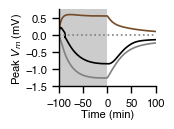

In [1410]:
t_ = np.asarray(dfs['time_min'][0].to_list())-100 #- dfs['transition_to_recovery_vertical_dashed_line'][0].values[0]

gca_input = np.mean(np.array([dfs['ON_gca_input'],dfs['OFF_gca_input']]),axis=0)
mg_input = np.mean(np.array([dfs['mgM_input'],dfs['mgP_input']]),axis=0)
output_vm = np.mean(np.array([dfs['ON_vm'],dfs['OFF_vm']]),axis=0)


hfig = plt.figure(figsize=(1.25,1))
ax = plt.gca()
ax.plot(t_,gca_input,color='gray')
ax.plot(t_,mg_input,color='#754C29')
ax.plot(t_,output_vm,color='black')
ax.hlines(0,t_[0],200,color = 'gray', linestyle='dotted')
# ax.vlines(0,-0.5,0.5,color='gray',linewidth = 0.5,zorder=0)
# ax.vlines(4,-0.5,0.5,color='gray',linewidth = 0.5,linestyle='dashed',zorder=0)
ax.fill_between([t_[0],0],[-1.5,-1.5],[0.75,0.75],alpha=0.2,color='black',zorder=0,linewidth=0)
ax.set_xticks([-100,-50,0,50,100])
ax.set_ylim(-1.5,0.75)
ax.set_yticks([-1.5,-1,-0.5,0,0.5])
ax.set_xlim(t_[0],100)
# sns.despine(offset={'left':2})
ax.set_xlabel('Time (min)')
ax.set_ylabel('Peak $V_m$ (mV)')

plt.savefig(f'{svg_path}Output_recovery_VM_manip.svg', format='svg', transparent=True)

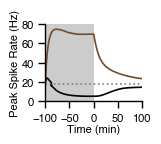

In [1411]:
t_ = np.asarray(dfs['time_min'][0].to_list())-100 #- dfs['transition_to_recovery_vertical_dashed_line'][0].values[0]
output_mg = np.mean( np.array([ np.asarray(dfs['OFF_rate'][0].to_list()), np.asarray(dfs['ON_rate'][0].to_list()) ]), axis=0 ) #- dfs['baseline_op_firingg_horizontal_dashed_line'][0].values[0]
mg = np.mean( np.array([ np.asarray(dfs['OFF_rate_mg_only'][0].to_list()), np.asarray(dfs['ON_rate_mg_only'][0].to_list())]), axis=0 ) #- dfs['baseline_op_firingg_horizontal_dashed_line'][0].values[0]

hfig = plt.figure(figsize=(1.25,1))
ax = plt.gca()
ax.plot(t_,mg,color='#754C29')
ax.plot(t_,output_mg,color='black')
ax.hlines(dfs['baseline_op_firing_horizontal_dashed_line'][0].values[0],t_[0],200,color = 'gray', linestyle='dotted')
# ax.vlines(0,10,70,color='gray',linewidth = 0.5,zorder=0)
# ax.vlines(4,10,65,color='gray',linewidth = 0.5,linestyle='dashed',zorder=0)
ax.fill_between([t_[0],0],[0,0],[80,80],alpha=0.2,color='black',zorder=0,linewidth=0)
ax.set_yticks([0,20,40,60,80])
ax.set_xticks([-100,-50,0,50,100])
ax.set_ylim(0,80)
ax.set_xlim(t_[0],100)
# sns.despine(offset={'left':2})
ax.set_xlabel('Time (min)')
ax.set_ylabel('Peak Spike Rate (Hz)')
plt.savefig(f'{svg_path}Output_recovery_spks_manip.svg', format='svg', transparent=True)

### e

In [1412]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/figS7/data_fig_7Sb.mat')

In [1413]:
view_mat_file(data_mat_path)

dfs = {}
# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    dfs=recursively_load(dfs,f['data_for_krista_figure_7Sb'])

print(dfs.keys())

Top-level keys: ['#refs#', 'data_for_krista_figure_7Sb']

Key: #refs#
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['a']

Key: data_for_krista_figure_7Sb
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['OFF_bars_recur_two_sided_echo', 'ON_bars_recur_two_sided_echo', 'x_parm']
dict_keys(['OFF_bars_recur_two_sided_echo', 'ON_bars_recur_two_sided_echo', 'x_parm'])


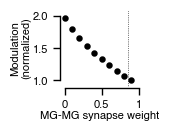

In [1415]:
hfig = plt.figure(figsize=(1,1))
ax = plt.gca()
# sns.pointplot(dfs['bars_two_sided_echo_all_w_OFF'],palette=pal,ax=ax)
# sns.pointplot(dfs['bars_two_sided_echo_all_w_ON'],palette=pal,ax=ax)
df_output = pd.concat([dfs['ON_bars_recur_two_sided_echo'],dfs['OFF_bars_recur_two_sided_echo']],ignore_index=True)
sns.pointplot(df_output,color='black',linestyle='none',markersize = 3,errorbar = None,ax=ax) #palette=pal
ax.vlines(8.5,0.9,2.1,color='black',linewidth=0.5, linestyle='dotted',zorder=0)
ax.set_xticks([0,5,10])
ax.set_xticklabels([0,0.5,1]);
ax.set_ylim(0.9,2.1)
sns.despine(offset=1,trim=True)
ax.set_xlabel('MG-MG synapse weight')
ax.set_ylabel('Modulation\n(normalized)')
plt.savefig(f'{svg_path}Output_Modulation_MGweight.svg', format='svg', transparent=True)

### d

In [1494]:
pal = sns.color_palette("flare_r", n_colors=4)

In [1495]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/figS7/data_fig_7Sd.mat')

view_mat_file(data_mat_path)

dfs = {}
# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    dfs = recursively_load(dfs,f['data_for_krista_figure_7S_d'])

print(dfs.keys())

# Transpose all DataFrames in the dictionary
for key in dfs:
    if len(dfs[key].columns)>1:
        dfs[key] = dfs[key].transpose()

dfs['model_time'] = dfs['model_time'].rename(columns={0: 'time'})

Top-level keys: ['#refs#', 'data_for_krista_figure_7S_d']

Key: #refs#
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['a']

Key: data_for_krista_figure_7S_d
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['model_OFF_progression', 'model_ON_progression', 'model_time']
dict_keys(['model_OFF_progression', 'model_ON_progression', 'model_time'])


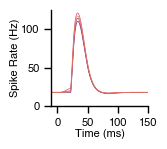

In [1496]:
d = 'model_ON_progression'
df_toplot = pd.concat([dfs['model_time'], dfs[d]], axis=1)

df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)

plt.figure(figsize=(1.25,1.25))#0.75))
ax = plt.gca()
sns.lineplot(data = df_toplot,x = 'time', y = 'rate', hue = 'condition',ax = ax, linewidth = 0.5,legend = False,palette = pal)#cmap_dict['colorful'])
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
ax.set_ylim(-.1,125)
# ax.set_yticks([0,50,100,150])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylabel('Spike Rate (Hz)') 
# ax.set_yticklabels('')
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_color.svg', format='svg', transparent=True)


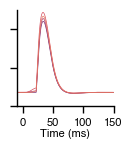

In [1497]:
d = 'model_OFF_progression'
df_toplot = pd.concat([dfs['model_time'], dfs[d]], axis=1)

df_toplot = df_toplot.melt(
    id_vars='time',
    var_name='condition',
    value_name='rate'
)

plt.figure(figsize=(1.25,1.25))#0.75))
ax = plt.gca()
sns.lineplot(data = df_toplot,x = 'time', y = 'rate', hue = 'condition',ax = ax, linewidth = 0.5,legend = False,palette = pal)#cmap_dict['colorful'])
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
ax.set_ylim(-.1,125)
# ax.set_yticks([0,50,100,150])
# sns.despine(offset={'left':1,'bottom':2})
ax.set_ylabel('') # this needs to match diff between ylims
ax.set_yticklabels('')
ax.set_xlabel('Time (ms)')

plt.savefig(f'{svg_path}{d}_color.svg', format='svg', transparent=True)


### e

In [1419]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/data_gc.mat')
view_mat_file(data_mat_path)

dfs = {}

# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    dfs = recursively_load(dfs,f['data_gc'])

print(dfs.keys())

# Transpose all DataFrames in the dictionary
for key in dfs:
    dfs[key] = dfs[key].transpose()

gc_time = dfs['time'].transpose()
gc_sum = dfs['gc_epsp'].sum(axis=1)

Top-level keys: ['#refs#', 'data_gc']

Key: #refs#
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['a']

Key: data_gc
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['gc_epsp', 'gc_rate', 'time']
dict_keys(['gc_epsp', 'gc_rate', 'time'])


In [1423]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/figS7/data_fig_7Sc.mat')

view_mat_file(data_mat_path)

dfs = {}
# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    dfs = recursively_load(dfs,f['data_for_krista_figure_7Sc'])

print(dfs.keys())

# Transpose all DataFrames in the dictionary
for key in dfs:
    if len(dfs[key].columns)>1:
        dfs[key] = dfs[key].transpose()

Top-level keys: ['#refs#', 'data_for_krista_figure_7Sc']

Key: #refs#
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['a']

Key: data_for_krista_figure_7Sc
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['model_off_post_noise', 'model_on_post_noise', 'model_time']
dict_keys(['model_off_post_noise', 'model_on_post_noise', 'model_time'])


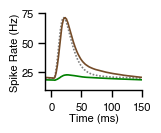

In [1424]:
t_model = np.asarray(dfs['model_time'][0].to_list())
avg_model_mg = np.mean( np.array([ np.asarray(dfs['model_off_post_noise'][1].to_list()), np.asarray(dfs['model_on_post_noise'][1].to_list()) ]), axis=0 )
avg_model_mg_out = np.mean( np.array([ np.asarray(dfs['model_off_post_noise'][0].to_list()), np.asarray(dfs['model_on_post_noise'][0].to_list()) ]), axis=0 )

mg_min = np.min(avg_model_mg)
mg_max = np.max(avg_model_mg) - mg_min

norm_gc = gc_sum - np.min(gc_sum)
norm_gc = norm_gc/np.max(norm_gc)
norm_gc = (norm_gc * mg_max) + mg_min

hfig = plt.figure(figsize=(1.25,1))
ax = plt.gca()
ax.plot(gc_time,norm_gc,color='gray',dashes = [1,1])
ax.plot(t_model,avg_model_mg,color='#754C29')
ax.plot(t_model,avg_model_mg_out,color='green')
ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
ax.set_ylim(10,75)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Spike Rate (Hz)')
plt.savefig(f'{svg_path}Output_neg_image_conditions_noise.svg', format='svg', transparent=True)

### f

In [1425]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/figS7/data_fig_7Sf.mat')

view_mat_file(data_mat_path)

dfs = {}
# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    dfs=recursively_load(dfs,f['data_for_krista_figure_7S_f'])

print(dfs.keys())

# Transpose all DataFrames in the dictionary
for key in dfs:
    if len(dfs[key].columns)>1:
        dfs[key] = dfs[key].transpose()

Top-level keys: ['#refs#', 'data_for_krista_figure_7S_f']

Key: #refs#
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['a']

Key: data_for_krista_figure_7S_f
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['OFF_rate', 'OFF_rate_w_eq_1', 'ON_rate', 'ON_rate_w_eq_1', 'baseline_op_firing_horizontal_dashed_line', 'time_min']
dict_keys(['OFF_rate', 'OFF_rate_w_eq_1', 'ON_rate', 'ON_rate_w_eq_1', 'baseline_op_firing_horizontal_dashed_line', 'time_min'])


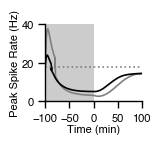

In [1426]:
t_ = np.asarray(dfs['time_min'][0].to_list()) - 100 #- dfs['transition_to_recovery_vertical_dashed_line'][0].values[0]
output_mg = np.mean( np.array([ np.asarray(dfs['OFF_rate'][0].to_list()), np.asarray(dfs['ON_rate'][0].to_list()) ]), axis=0 ) #- dfs['baseline_op_firingg_horizontal_dashed_line'][0].values[0]
mg = np.mean( np.array([ np.asarray(dfs['OFF_rate_w_eq_1'][0].to_list()), np.asarray(dfs['ON_rate_w_eq_1'][0].to_list())]), axis=0 ) #- dfs['baseline_op_firingg_horizontal_dashed_line'][0].values[0]

hfig = plt.figure(figsize=(1.25,1))
ax = plt.gca()
ax.plot(t_,mg,color='gray')
ax.plot(t_,output_mg,color='black')
ax.hlines(dfs['baseline_op_firing_horizontal_dashed_line'][0].values[0],t_[0],100,color = 'gray', linestyle='dotted')

# ax.vlines(0,10,70,color='gray',linewidth = 0.5,zorder=0)
# ax.vlines(4,10,65,color='gray',linewidth = 0.5,linestyle='dashed',zorder=0)
# ax.fill_between([t_[0],100],[0,0],[80,80],alpha=0.2,color='black',zorder=0,linewidth=0)
ax.fill_between([t_[0],0],[0,0],[40,40],alpha=0.2,color='black',zorder=0,linewidth=0)
ax.set_yticks([0,20,40])
ax.set_xticks([-100,-50,0,50,100])
ax.set_ylim(0,40)
ax.set_xlim(t_[0],100)
# sns.despine(offset={'left':2})
ax.set_xlabel('Time (min)')
ax.set_ylabel('Peak Spike Rate (Hz)')
plt.savefig(f'{svg_path}Output_recovery_spks_manip_MGweight.svg', format='svg', transparent=True)

### g

In [1428]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/figS7/data_fig_7Sg.mat')

view_mat_file(data_mat_path)

dfs = {}
# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    dfs=recursively_load(dfs,f['data_for_krista_figure_7S_g'])

print(dfs.keys())

# Transpose all DataFrames in the dictionary
for key in dfs:
    if len(dfs[key].columns)>1:
        dfs[key] = dfs[key].transpose()

Top-level keys: ['#refs#', 'data_for_krista_figure_7S_g']

Key: #refs#
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['a']

Key: data_for_krista_figure_7S_g
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['OFF_rate', 'OFF_rate_w_lr_eq_2', 'ON_rate', 'ON_rate_lr_eq_2', 'baseline_op_firing_horizontal_dashed_line', 'time_min']
dict_keys(['OFF_rate', 'OFF_rate_w_lr_eq_2', 'ON_rate', 'ON_rate_lr_eq_2', 'baseline_op_firing_horizontal_dashed_line', 'time_min'])


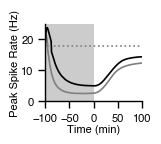

In [1429]:
t_ = np.asarray(dfs['time_min'][0].to_list()) - 100 #- dfs['transition_to_recovery_vertical_dashed_line'][0].values[0]
output_mg = np.mean( np.array([ np.asarray(dfs['OFF_rate'][0].to_list()), np.asarray(dfs['ON_rate'][0].to_list()) ]), axis=0 ) #- dfs['baseline_op_firingg_horizontal_dashed_line'][0].values[0]
mg = np.mean( np.array([ np.asarray(dfs['OFF_rate_w_lr_eq_2'][0].to_list()), np.asarray(dfs['ON_rate_lr_eq_2'][0].to_list())]), axis=0 ) #- dfs['baseline_op_firingg_horizontal_dashed_line'][0].values[0]

hfig = plt.figure(figsize=(1.25,1))
ax = plt.gca()
ax.plot(t_,mg,color='gray')
ax.plot(t_,output_mg,color='black')
ax.hlines(dfs['baseline_op_firing_horizontal_dashed_line'][0].values[0],t_[0],100,color = 'gray', linestyle='dotted')

# ax.vlines(0,10,70,color='gray',linewidth = 0.5,zorder=0)
# ax.vlines(4,10,65,color='gray',linewidth = 0.5,linestyle='dashed',zorder=0)
# ax.fill_between([t_[0],100],[0,0],[80,80],alpha=0.2,color='black',zorder=0,linewidth=0)
ax.fill_between([t_[0],0],[0,0],[40,40],alpha=0.2,color='black',zorder=0,linewidth=0)
ax.set_yticks([0,10,20])
ax.set_xticks([-100,-50,0,50,100])
ax.set_ylim(0,25)
ax.set_xlim(t_[0],100)
# sns.despine(offset={'left':2})
ax.set_xlabel('Time (min)')
ax.set_ylabel('Peak Spike Rate (Hz)')
plt.savefig(f'{svg_path}Output_recovery_spks_manip_OutputLR.svg', format='svg', transparent=True)

## Figure 8S

### 9Se

In [131]:
data_mat_path = Path('/Users/kperks/Documents/sawtell_lab/EM_data/fig9S/data_fig_8e.mat')

In [132]:
view_mat_file(data_mat_path)

Top-level keys: ['#refs#', 'data_for_krista_figure_8e']

Key: #refs#
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['a']

Key: data_for_krista_figure_8e
Type: <class 'h5py._hl.group.Group'>
Contains a group with sub-keys: ['all_sg', 'good_sg', 'initial', 'mean_all_sg', 'x_time']


In [133]:
dfs = {}
# Load the file and recurse
with h5py.File(data_mat_path, 'r') as f:
    recursively_load(f['data_for_krista_figure_8e'])

print(dfs.keys())

dict_keys(['all_sg', 'good_sg', 'initial', 'mean_all_sg', 'x_time'])


In [134]:
# Transpose all DataFrames in the dictionary
for key in dfs.keys():
    if len(dfs[key].columns)>1:
        dfs[key] = dfs[key].transpose()

In [135]:
dfs['x_time'].rename(columns={0:'time'},inplace=True)

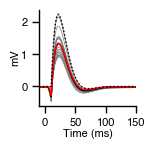

In [136]:
plt.figure(figsize=(1.25,1.25))
ax = plt.gca()

### seaborn lineplot estimator
# d = 'all_sg'
# df_toplot = pd.concat([dfs['x_time'], dfs[d]], axis=1)
# df_toplot = df_toplot.melt(
#     id_vars='time',
#     var_name='condition',
#     value_name='rate'
# )
# sns.lineplot(data = df_toplot,x = 'time',y = 'rate',color='black',estimator='mean',legend=False)

### manual plot from mat
d = 'all_sg'
plt.plot(dfs['x_time'],dfs[d],color='gray',linewidth=0.5);
d = 'mean_all_sg'
plt.plot(dfs['x_time'],dfs[d],color='black',linewidth=1);
d = 'good_sg'
plt.plot(dfs['x_time'],dfs[d],color='red',linewidth=1);
d = 'initial'
plt.plot(dfs['x_time'],dfs[d],color='black',linestyle='dotted',linewidth=1);

ax.set_xlim(-10,150)
ax.set_xticks([0,50,100,150])
# ax.set_ylim(10,35)
# ax.set_yticks([10,20,30])
# # sns.despine(offset={'left':1,'bottom':2})
ax.set_ylabel('mV') # this needs to match diff between ylims
# # ax.set_yticklabels('')
ax.set_xlabel('Time (ms)')

plt.savefig(f'/Users/kperks/Downloads/sg_mV.svg', format='svg', transparent=True)